# Importing modules and initializing setting preferences

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import os
from statistics import mean
from scipy import constants
from scipy import stats
from scipy.stats import norm
from astropy.io import fits
from xspec import *
XspecSettings.chatter = 0
Xset.parallel.error = 4
Xset.parallel.leven = 4
Plot.commands = ()
Plot.device = '/null'
Plot.xAxis = 'keV'
Plot.area=True
Plot.xLog=False
Plot.yLog=False
Fit.statMethod = "chi"

Plot command list is now empty
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.


In [10]:
os.chdir("/home/idies/workspace/Storage/victorliu09/persistent")

# Main functions

In [11]:
def pvalue_to_sigma(p_value):
    # Calculate the z-score (number of standard deviations from the mean)
    z_score = norm.ppf(1 - p_value)  # Divide p-value by 2 for a two-tailed test

    # Calculate the sigma level of confidence
    sigma_level = abs(z_score)

    return sigma_level

def analyze_spectra(model_name, obs_label, parameter_errors_to_compute_ind, plot_entire_range = True, fit_errors = True, find_eqwidth = True, plot_eqwidth=False, return_indiv_comp = True):
    Fit.renorm()
    Fit.perform()
    if fit_errors:
        Fit.error(f"1.0 {model_name}:{parameter_errors_to_compute_ind}")
    
    if find_eqwidth:
        if model_name == "simple_gauss":
            AllModels.eqwidth(f"{model_name}:4 err 500 68.26")
        elif model_name == "rdblur" or model_name == "rdblur_q_fixed":
            AllModels.eqwidth(f"{model_name}:5 err 500 68.26")
        elif model_name == "xillver":
            AllModels.eqwidth(f"{model_name}:4 err 500 68.26")
        elif model_name == "mytorus":
            AllModels.eqwidth(f"{model_name}:4 err 500 68.26")
        elif model_name == "rdblur_mytorus":
            AllModels.eqwidth(f"{model_name}:5 err 500 68.26")
    
    Plot("data delchi")
    
    fitstat = Fit.statistic
    dof = Fit.dof
    p = 1 - stats.chi2.cdf(fitstat,dof)

    sigma_level = pvalue_to_sigma(p)
    energy, counts, yerr, fit, delchi_err, labels = np.array(Plot.x()), np.array(Plot.y()), np.array(Plot.yErr()), np.array(Plot.model()), np.array(Plot.yErr(plotWindow=2)), Plot.labels()
    if plot_entire_range:
        fig1 = plt.figure()
        ax1 = fig1.add_subplot()
        ax1.set_yscale('log')
        ax1.set_xscale('log')
        ax1.errorbar(energy, counts, yerr,alpha=0.5,label="data")
        ax1.plot(energy, fit,label=model_name, alpha=0.75)
        ax1.set_xlabel(labels[0])
        ax1.set_ylabel(labels[1])
        ax1.axvline(6.346,linestyle="--",color="red",label='6.346 keV, redshifted')
        #ax1.axvline(6.4,linestyle="--",color="green",label='6.4 keV, intrinsic energy')
        plt.title(f"{obs_label}, 1.5-8.0 keV\nHEG, +/-1 order combined")
        plt.legend()
    
    # Assumes that the format of the model is continuum + line model
    Plot.add = True # Do not delete this line! Otherwise the Plot.addComp() command won't work
    Plot(f"data model {model_name}")
    fit_continuum = np.array(Plot.addComp(1))
    if model_name[:3] == "two":
        fit_line = np.array(Plot.addComp(2)) + np.array(Plot.addComp(3))
    else:
        fit_line = np.array(Plot.addComp(2))
    Plot.add = False
    data_minus_continuum = counts - fit_continuum
    
    # Focus only on regime with iron Fe Ka line
    zoomed_ind = np.where((energy >= 6.0) & (energy <= 7.0))[0]
    zoomed_energy = energy[zoomed_ind]
    zoomed_counts = counts[zoomed_ind]
    zoomed_yerr = yerr[zoomed_ind]
    zoomed_fit = fit[zoomed_ind]
    zoomed_delchi_err = delchi_err[zoomed_ind]
    
    # Plot fit for region with iron Fe Ka line
    fig2 = plt.figure()
    ax2 = fig2.add_subplot()
    ax2.errorbar(zoomed_energy, zoomed_counts, zoomed_yerr, alpha=0.5, label="data")
    ax2.plot(zoomed_energy, zoomed_fit, alpha=0.75, label=model_name)
    ax2.set_xlabel(labels[0])
    ax2.set_ylabel(labels[1])
    #ax2.axvline(6.346,linestyle="--",color="red",label='6.346 keV, redshifted')
    if plot_eqwidth and plot_entire_range:
        ax2.axvline(6.346-s.eqwidth[0],linestyle="--",color="purple",alpha=0.5,label=f'{round(6.346-s.eqwidth[0],3)} keV, eqwidth bound')
        ax2.axvline(6.346+s.eqwidth[0],linestyle="--",color="purple",alpha=0.5,label=f'{round(6.346+s.eqwidth[0],3)} keV, eqwidth bound')
    #ax2.axvline(6.4,linestyle="--",color="green",label='6.4 keV, intrinsic energy')
    plt.title(f"{obs_label}, 6.0-7.0 keV\nHEG, +/-1 order combined")
    plt.legend()    
    
    # Plot the data with background continuum subtracted
    zoomed_data_minus_continuum = data_minus_continuum[zoomed_ind]
    zoomed_line = fit_line[zoomed_ind]
    fig3 = plt.figure()
    ax3 = fig3.add_subplot()
    ax3.errorbar(zoomed_energy, zoomed_data_minus_continuum, zoomed_yerr, alpha=0.5, label="data")
    ax3.plot(zoomed_energy, zoomed_line, alpha=0.75, label=model_name)
    ax3.set_xlabel(labels[0])
    ax3.set_ylabel(labels[1])
    #ax3.axvline(6.346,linestyle="--",color="red",label='6.346 keV, redshifted')
    if plot_eqwidth and plot_entire_range:
        ax3.axvline(6.346-s.eqwidth[0],linestyle="--",color="purple",alpha=0.5,label=f'{round(6.346-s.eqwidth[0],3)} keV, eqwidth bound')
        ax3.axvline(6.346+s.eqwidth[0],linestyle="--",color="purple",alpha=0.5,label=f'{round(6.346+s.eqwidth[0],3)} keV, eqwidth bound')
    #ax3.axvline(6.4,linestyle="--",color="green",label='6.4 keV, intrinsic energy')
    plt.title(f"{obs_label}")#, Continuum Subtracted Off\nHEG, +/-1 order combined")
    plt.legend()
    
    print(f"p value: {p}")
    print(f"Sigma level of confidence: {sigma_level}")
    if find_eqwidth:
        print(f"equivalent width: {s.eqwidth}")
    if return_indiv_comp:
        return zoomed_energy, zoomed_counts, zoomed_yerr, zoomed_fit, zoomed_data_minus_continuum, zoomed_line, zoomed_delchi_err, s.flux, s.eqwidth, p, sigma_level, fitstat, dof
    else:
        return zoomed_energy, zoomed_counts, zoomed_yerr, zoomed_fit, zoomed_delchi_err, s.flux, s.eqwidth, p, sigma_level, fitstat, dof

In [12]:
nH_dict = {"old": {}, "new": {}, "total": {}}
pho_dict = {"old": {}, "new": {}, "total": {}}
powerlw_norm_dict = {"old": {}, "new": {}, "total": {}}
flux_dict = {"old": {}, "new": {}, "total": {}}
sigma_dict = {"old": {}, "new": {}, "total": {}}
second_sigma_dict = {"old": {}, "new": {}, "total": {}}
eqwidth_dict = {"old": {}, "new": {}, "total": {}}
q_dict = {"old": {}, "new": {}, "total": {}}
Rin_dict = {"old": {}, "new": {}, "total": {}}
incl_dict = {"old": {}, "new": {}, "total": {}}
redshift_dict = {"old": {}, "new": {}, "total": {}}
iron_abun_dict = {"old": {}, "new": {}, "total": {}}
log_ion_dict = {"old": {}, "new": {}, "total": {}}
reduced_chisq_dict = {"old": {}, "new": {}, "total": {}}

In [13]:
def print_model_parameters(m, model_name, spectrum_name, two_gauss_used = False, second_gauss_comp = None, plot_entire_range = True):
    if plot_entire_range:
        nH_val = m.zphabs.nH.values[0]
        nH_plus_err = m.zphabs.nH.error[1] - m.zphabs.nH.values[0]
        nH_minus_err = m.zphabs.nH.values[0] - m.zphabs.nH.error[0]
        nH_dict[spectrum_name][model_name] = [nH_val, nH_plus_err, nH_minus_err]
    
    pho_val = m.zpowerlw.PhoIndex.values[0]
    pho_plus_err = m.zpowerlw.PhoIndex.error[1] - m.zpowerlw.PhoIndex.values[0]
    pho_minus_err = m.zpowerlw.PhoIndex.values[0] - m.zpowerlw.PhoIndex.error[0]
    pho_dict[spectrum_name][model_name] = [pho_val, pho_plus_err, pho_minus_err]
    
    powerlw_norm_val = m.zpowerlw.norm.values[0]*1e02
    powerlw_norm_plus_err = (m.zpowerlw.norm.error[1] - m.zpowerlw.norm.values[0])*1e02
    powerlw_norm_minus_err = (m.zpowerlw.norm.values[0] - m.zpowerlw.norm.error[0])*1e02
    powerlw_norm_dict[spectrum_name][model_name] = [powerlw_norm_val, powerlw_norm_plus_err, powerlw_norm_minus_err]
    
    flux_val = 10**(m.cflux.lg10Flux.values[0])*1e13
    flux_plus_err = (10**(m.cflux.lg10Flux.error[1]) - 10**(m.cflux.lg10Flux.values[0]))*1e13
    flux_minus_err = (10**(m.cflux.lg10Flux.values[0]) - 10**(m.cflux.lg10Flux.error[0]))*1e13
    flux_dict[spectrum_name][model_name] = [flux_val, flux_plus_err, flux_minus_err]
    
    if model_name == "sigma_fixed" or model_name == "sigma_vary" or model_name == "rdblur" or model_name == "rdblur_q_fixed":
        sigma_val = m.zgauss.Sigma.values[0]*1e03
        sigma_plus_err = (m.zgauss.Sigma.error[1] - m.zgauss.Sigma.values[0])*1e03
        sigma_minus_err = (m.zgauss.Sigma.values[0] - m.zgauss.Sigma.error[0])*1e03
        sigma_dict[spectrum_name][model_name] = [sigma_val, sigma_plus_err, sigma_minus_err]
        
    if two_gauss_used:
        second_sigma_val = second_gauss_comp.Sigma.values[0]*1e03
        second_sigma_plus_err = (second_gauss_comp.Sigma.error[1] - second_gauss_comp.Sigma.values[0])*1e03
        second_sigma_minus_err = (second_gauss_comp.Sigma.values[0] - second_gauss_comp.Sigma.error[0])*1e03
        second_sigma_dict[spectrum_name][model_name] = [second_sigma_val, second_sigma_plus_err, second_sigma_minus_err]
    
    if plot_entire_range:
        eqwidth_val = s.eqwidth[0]*1e03
        eqwidth_plus_err = (s.eqwidth[2]-s.eqwidth[0])*1e03
        eqwidth_minus_err = (s.eqwidth[0]-s.eqwidth[1])*1e03
        eqwidth_dict[spectrum_name][model_name] = [eqwidth_val, eqwidth_plus_err, eqwidth_minus_err]
    
    if model_name == "sigma_fixed":
        if plot_entire_range:
            print("zphabs*(zpowerlw+cflux*zgauss), sigma fixed to 0")
        else:
            print("zpowerlw+cflux*zgauss, sigma fixed to 0")
    elif model_name == "sigma_vary":
        if plot_entire_range:
            print("zphabs*(zpowerlw+cflux*zgauss), sigma freely varying")
        else:
            print("zpowerlw+cflux*zgauss, sigma freely varying")
    elif model_name == "xillver":
        if plot_entire_range:
            print("zphabs*(zpowerlw+cflux*atable{xillver-a-Ec5.fits}), xillver")
        else:
            print("zpowerlw+cflux*xillver, xillver")
    elif model_name == "diskline":
        if plot_entire_range:
            print("zphabs*(zpowerlw+cflux*zmshift*diskline), diskline")
        else:
            print("zpowerlw+cflux*zmshift*diskline, diskline")
    elif model_name == "rdblur":
        if plot_entire_range:
            print("zphabs*(zpowerlw+cflux*rdblur*zgauss), rdblurred")
        else:
            print("zpowerlw+cflux*rdblur*zgauss, rdblurred")
    elif model_name == "rdblur_q_fixed":
        if plot_entire_range:
            print("zphabs*(zpowerlw+cflux*rdblur*zgauss), rdblurred with q fixed at -3")
        else:
            print("zpowerlw+cflux*rdblur*zgauss, rdblurred with q fixed at -3")
    
    print("1st number is parameter value, 2nd is plus 1sigma error, 3rd is minus 1sigma error\n")
    
    if plot_entire_range:
        print(f"nH (10^22 atoms cm^-2): {nH_val:.2f}, +{nH_plus_err:.2f}, -{nH_minus_err:.2f}")
    print(f"PhoIndex \u0393 (unitless): {pho_val:.2f}, +{pho_plus_err:.2f}, -{pho_minus_err:.2f}")
    print(f"Power law norm (10^-2 photons/keV/cm^2/s): {powerlw_norm_val:.2f}, +{powerlw_norm_plus_err:.2f}, -{powerlw_norm_minus_err:.2f}")

    if model_name == "sigma_vary":
        print(f"Gaussian sigma (eV): {sigma_val:.1f}, +{sigma_plus_err:.1f}, -{sigma_minus_err:.1f}")
        #print(f"Gaussian norm (10^-5 photons/cm^2/s): {gauss_norm_val:.2f}, +{gauss_norm_plus_err:.2f}, -{gauss_norm_minus_err:.2f}")
        if two_gauss_used:
            print(f"Second Gaussian sigma (eV): {second_sigma_val:.1f}, +{second_sigma_plus_err:.1f}, -{second_sigma_minus_err:.1f}")
        
    if model_name == "xillver":
        redshift_val = m.xillverEc.z.values[0]
        redshift_plus_err = m.xillverEc.z.error[1] - m.xillverEc.z.values[0]
        redshift_minus_err = m.xillverEc.z.values[0] - m.xillverEc.z.error[0]
        redshift_dict[spectrum_name][model_name] = [redshift_val, redshift_plus_err, redshift_minus_err]
    
        iron_abun_val = m.xillverEc.A_Fe.values[0]
        iron_abun_plus_err = m.xillverEc.A_Fe.error[1] - m.xillverEc.A_Fe.values[0]
        iron_abun_minus_err = m.xillverEc.A_Fe.values[0] - m.xillverEc.A_Fe.error[0]
        iron_abun_dict[spectrum_name][model_name] = [iron_abun_val, iron_abun_plus_err, iron_abun_minus_err]
        
        log_ion_val = m.xillverEc.logXi.values[0]
        log_ion_plus_err = m.xillverEc.logXi.error[1] - m.xillverEc.logXi.values[0]
        log_ion_minus_err = m.xillverEc.logXi.values[0] - m.xillverEc.logXi.error[0]
        log_ion_dict[spectrum_name][model_name] = [log_ion_val, log_ion_plus_err, log_ion_minus_err]
        
        incl_val = m.xillverEc.Incl.values[0]
        incl_plus_err = m.xillverEc.Incl.error[1] - m.xillverEc.Incl.values[0]
        incl_minus_err = m.xillverEc.Incl.values[0] - m.xillverEc.Incl.error[0]
        incl_dict[spectrum_name][model_name] = [incl_val, incl_plus_err, incl_minus_err]
        
        print(f"Redshift (unitless): {redshift_val:.7f}, +{redshift_plus_err:.7f}, -{redshift_minus_err:.7f}")
        print(f"Iron abundance (relative to solar abundance): {iron_abun_val:.3f}, +{iron_abun_plus_err:.3f}, -{iron_abun_minus_err:.3f}")
        print(f"Log of ionization log\u03BE: {log_ion_val:.3f}, +{log_ion_plus_err:.3f}, -{log_ion_minus_err:.3f}")
        print(f"Inclination (deg): {incl_val:.2f}, +{incl_plus_err:.2f}, -{incl_minus_err:.2f}")
    
    ##if model_name == "mytorus":
        #  mytorus cannot constrain inclination for our model, so we fix it at 60 deg
        #incl_val = m.MYTorusL.IncAng.values[0]
        #incl_plus_err = m.MYTorusL.IncAng.error[1] - m.MYTorusL.IncAng.values[0]
        #incl_minus_err = m.MYTorusL.IncAng.values[0] - m.MYTorusL.IncAng.error[0]
        #incl_dict[spectrum_name][model_name] = [incl_val, incl_plus_err, incl_minus_err]
        
        #print(f"Inclination (deg): {incl_val:.2f}, +{incl_plus_err:.2f}, -{incl_minus_err:.2f}")
        
    if model_name == "rdblur_mytorus":
        q_val = m.rdblur.Betor10.values[0]*-1
        q_plus_err = m.rdblur.Betor10.values[0] - m.rdblur.Betor10.error[0]
        q_minus_err = m.rdblur.Betor10.error[1] - m.rdblur.Betor10.values[0]
        q_dict[spectrum_name][model_name] = [q_val, q_plus_err, q_minus_err]
        
        Rin_val = m.rdblur.Rin_M.values[0]
        Rin_plus_err = m.rdblur.Rin_M.error[1] - m.rdblur.Rin_M.values[0]
        Rin_minus_err = m.rdblur.Rin_M.values[0] - m.rdblur.Rin_M.error[0]
        Rin_dict[spectrum_name][model_name] = [Rin_val, Rin_plus_err, Rin_minus_err]
        
        incl_val = m.MYTorusL.IncAng.values[0]
        incl_plus_err = m.MYTorusL.IncAng.error[1] - m.MYTorusL.IncAng.values[0]
        incl_minus_err = m.MYTorusL.IncAng.values[0] - m.MYTorusL.IncAng.error[0]
        incl_dict[spectrum_name][model_name] = [incl_val, incl_plus_err, incl_minus_err]
        
        print(f"Emissitivity index q (unitless): {q_val:.2f}, +{q_plus_err:.2f}, -{q_minus_err:.2f}")
        print(f"Inner radius R_in (GM/c^2): {Rin_val:.0f}, +{Rin_plus_err:.0f}, -{Rin_minus_err:.0f}")
        print(f"Inclination (deg): {incl_val:.2f}, +{incl_plus_err:.2f}, -{incl_minus_err:.2f}")
    
    if model_name == "rdblur_q_fixed":        
        Rin_val = m.rdblur.Rin_M.values[0]
        Rin_plus_err = m.rdblur.Rin_M.error[1] - m.rdblur.Rin_M.values[0]
        Rin_minus_err = m.rdblur.Rin_M.values[0] - m.rdblur.Rin_M.error[0]
        Rin_dict[spectrum_name][model_name] = [Rin_val, Rin_plus_err, Rin_minus_err]
        
        incl_val = m.rdblur.Incl.values[0]
        incl_plus_err = m.rdblur.Incl.error[1] - m.rdblur.Incl.values[0]
        incl_minus_err = m.rdblur.Incl.values[0] - m.rdblur.Incl.error[0]
        incl_dict[spectrum_name][model_name] = [incl_val, incl_plus_err, incl_minus_err]
        
        print(f"Inner radius R_in (GM/c^2): {Rin_val:.0f}, +{Rin_plus_err:.0f}, -{Rin_minus_err:.0f}")
        print(f"Inclination (deg): {incl_val:.2f}, +{incl_plus_err:.2f}, -{incl_minus_err:.2f}")
        
    if model_name == "rdblur":
        q_val = m.rdblur.Betor10.values[0]*-1
        q_plus_err = m.rdblur.Betor10.values[0] - m.rdblur.Betor10.error[0]
        q_minus_err = m.rdblur.Betor10.error[1] - m.rdblur.Betor10.values[0]
        q_dict[spectrum_name][model_name] = [q_val, q_plus_err, q_minus_err]
        
        Rin_val = m.rdblur.Rin_M.values[0]
        Rin_plus_err = m.rdblur.Rin_M.error[1] - m.rdblur.Rin_M.values[0]
        Rin_minus_err = m.rdblur.Rin_M.values[0] - m.rdblur.Rin_M.error[0]
        Rin_dict[spectrum_name][model_name] = [Rin_val, Rin_plus_err, Rin_minus_err]
        
        incl_val = m.rdblur.Incl.values[0]
        incl_plus_err = m.rdblur.Incl.error[1] - m.rdblur.Incl.values[0]
        incl_minus_err = m.rdblur.Incl.values[0] - m.rdblur.Incl.error[0]
        incl_dict[spectrum_name][model_name] = [incl_val, incl_plus_err, incl_minus_err]
        
        print(f"Emissitivity index q (unitless): {q_val:.2f}, +{q_plus_err:.2f}, -{q_minus_err:.2f}")
        print(f"Inner radius R_in (GM/c^2): {Rin_val:.0f}, +{Rin_plus_err:.0f}, -{Rin_minus_err:.0f}")
        print(f"Inclination (deg): {incl_val:.2f}, +{incl_plus_err:.2f}, -{incl_minus_err:.2f}")

    print(f"Line Flux (10^-13 ergs cm^-2 s^-1): {flux_val:.2f}, +{flux_plus_err:.2f}, -{flux_minus_err:.2f}")
    if plot_entire_range:
        print(f"Equivalent Width (eV): {eqwidth_val:.1f}, +{eqwidth_plus_err:.1f}, -{eqwidth_minus_err:.1f}")
    print(f"chi_sq/dof: {Fit.statistic:.1f}/{Fit.dof} = {(Fit.statistic/Fit.dof):.4f}")
    reduced_chisq_dict[spectrum_name][model_name] = [Fit.statistic, Fit.dof, Fit.statistic/Fit.dof]

In [14]:
def helper_line(dictionary, keyword, model, dec_number):
    if (round(dictionary[keyword][model][1],dec_number)) == (round(dictionary[keyword][model][2],dec_number)):
        return f'& {dictionary[keyword][model][0]:.{dec_number}f}$\pm{dictionary[keyword][model][1]:.{dec_number}f}$ '
    elif (round(dictionary[keyword][model][0],dec_number) - round(dictionary[keyword][model][2],dec_number) == 0.0):
        return f'& $\leq {dictionary[keyword][model][0]:.{dec_number}f}$'
    else:
        return f'& {dictionary[keyword][model][0]:.{dec_number}f}$^{{+{dictionary[keyword][model][1]:.{dec_number}f}}}_{{-{dictionary[keyword][model][2]:.{dec_number}f}}}$ '

def return_sigma_fixed_parameters(keyword, model):
    pho = helper_line(pho_dict, keyword, model, 2)
    powerlw_norm = helper_line(powerlw_norm_dict, keyword, model, 2)
    rest = "& 0* & – & – & – & – " + \
    "& – "
    eqwidth = "& – "
    #eqwidth = helper_line(eqwidth_dict, keyword, model, 1)
    reduced_chisq = f'& {reduced_chisq_dict[keyword][model][2]:.4f}\\\\'
    return f'{pho}{powerlw_norm}{rest}{eqwidth}{reduced_chisq}'

def return_sigma_vary_parameters(keyword, model):
    pho = helper_line(pho_dict, keyword, model, 2)
    powerlw_norm = helper_line(powerlw_norm_dict, keyword, model, 2)
    sigma = helper_line(sigma_dict, keyword, model, 1)
    rest = "& – & – & – & – "
    flux = helper_line(flux_dict, keyword, model, 2)
    eqwidth = "& – "
    #eqwidth = helper_line(eqwidth_dict, keyword, model, 1)
    reduced_chisq = f'& {reduced_chisq_dict[keyword][model][2]:.4f}\\\\'
    return f'{pho}{powerlw_norm}{sigma}{rest}{flux}{eqwidth}{reduced_chisq}'

def return_rdblur_q_fixed_parameters(keyword, model):
    pho = helper_line(pho_dict, keyword, model, 2)
    powerlw_norm = helper_line(powerlw_norm_dict, keyword, model, 2)
    rest = f'& 0* & – '
    incl = helper_line(incl_dict, keyword, model, 2)
    q = f'& 3.0* '
    Rin = helper_line(Rin_dict, keyword, model, 0)
    flux = helper_line(flux_dict, keyword, model, 2)
    eqwidth = "& – "
    #eqwidth = helper_line(eqwidth_dict, keyword, model, 1)
    reduced_chisq = f'& {reduced_chisq_dict[keyword][model][2]:.4f}\\\\'
    return f'{pho}{powerlw_norm}{rest}{incl}{q}{Rin}{flux}{eqwidth}{reduced_chisq}'

def return_rdblur_parameters(keyword, model):
    pho = helper_line(pho_dict, keyword, model, 2)
    powerlw_norm = helper_line(powerlw_norm_dict, keyword, model, 2)
    rest = f'& 0* & – '
    incl = helper_line(incl_dict, keyword, model, 2)
    q = helper_line(q_dict, keyword, model, 2)
    Rin = helper_line(Rin_dict, keyword, model, 0)
    flux = helper_line(flux_dict, keyword, model, 2)
    eqwidth = "& – "
    #eqwidth = helper_line(eqwidth_dict, keyword, model, 1)
    reduced_chisq = f'& {reduced_chisq_dict[keyword][model][2]:.4f}\\\\'
    return f'{pho}{powerlw_norm}{rest}{incl}{q}{Rin}{flux}{eqwidth}{reduced_chisq}'
    
def return_xillver_parameters(keyword, model):
    pho = helper_line(pho_dict, keyword, model, 2)
    powerlw_norm = helper_line(powerlw_norm_dict, keyword, model, 2)
    rest = "& – "
    iron_abun = helper_line(iron_abun_dict, keyword, model, 2)
    incl = helper_line(incl_dict, keyword, model, 2)
    rest_2 = "& – & – "
    flux = helper_line(flux_dict, keyword, model, 2)
    eqwidth = "& – "
    reduced_chisq = f'& {reduced_chisq_dict[keyword][model][2]:.4f}\\\\'
    return f'{pho}{powerlw_norm}{rest}{iron_abun}{incl}{rest_2}{flux}{eqwidth}{reduced_chisq}'

def return_mytorus_parameters(keyword, model):
    pho = helper_line(pho_dict, keyword, model, 2)
    powerlw_norm = helper_line(powerlw_norm_dict, keyword, model, 2)
    rest = "& – & – "
    if keyword=="old":
        incl = "& 6.42 "
    elif keyword=="new":
        incl = "& 9.02 "
    else:
        incl = "& 7.49 "
    rest_2 = "& – & – "
    flux = helper_line(flux_dict, keyword, model, 2)
    eqwidth = helper_line(eqwidth_dict, keyword, model, 1)
    reduced_chisq = f'& {reduced_chisq_dict[keyword][model][2]:.4f}\\\\'
    return f'{pho}{powerlw_norm}{rest}{incl}{rest_2}{flux}{eqwidth}{reduced_chisq}'

def return_rdblur_mytorus_parameters(keyword, model):
    pho = helper_line(pho_dict, keyword, model, 2)
    powerlw_norm = helper_line(powerlw_norm_dict, keyword, model, 2)
    rest = f'& – & – '
    incl = helper_line(incl_dict, keyword, model, 2)
    q = helper_line(q_dict, keyword, model, 2)
    Rin = helper_line(Rin_dict, keyword, model, 0)
    flux = helper_line(flux_dict, keyword, model, 2)
    eqwidth = helper_line(eqwidth_dict, keyword, model, 1)
    reduced_chisq = f'& {reduced_chisq_dict[keyword][model][2]:.4f}\\\\'
    return f'{pho}{powerlw_norm}{rest}{incl}{q}{Rin}{flux}{eqwidth}{reduced_chisq}'

def return_data(group, obsids, keyword, model):
    model = "sigma_fixed"
    sigma_fixed = f"\\multirow{{3}}{{4em}}{{{group}}} & Model A & {obsids} "
    sigma_fixed_params = return_sigma_fixed_parameters(keyword, model)
    sigma_fixed = f'{sigma_fixed}{sigma_fixed_params}'
    
    model = "sigma_vary"
    sigma_vary = f"& Model B & {obsids} "
    sigma_vary_params = return_sigma_vary_parameters(keyword, model)
    sigma_vary = f'{sigma_vary}{sigma_vary_params}'
    
    model = "rdblur_q_fixed"
    rdblur_q_fixed = f"& Model F & {obsids} "
    rdblur_q_fixed_parameters = return_rdblur_q_fixed_parameters(keyword, model)
    rdblur_q_fixed = f'{rdblur_q_fixed}{rdblur_q_fixed_parameters}'
    
    model = "rdblur"
    rdblur = f"& Model G & {obsids} "
    rdblur_parameters = return_rdblur_parameters(keyword, model)
    rdblur = f'{rdblur}{rdblur_parameters}'
    
    model = "xillver"
    xillver = f"& Model C & {obsids} "
    xillver_parameters = return_xillver_parameters(keyword, model)
    xillver = f'{xillver}{xillver_parameters}'
    
    model = "mytorus"
    mytorus = f"& Model D & {obsids} "
    mytorus_parameters = return_mytorus_parameters(keyword, model)
    mytorus = f'{mytorus}{mytorus_parameters}'
    
    model = "rdblur_mytorus"
    rdblur_mytorus = f"& Model E & {obsids} "
    rdblur_mytorus_parameters = return_mytorus_parameters(keyword, model)
    rdblur_mytorus = f'{rdblur_mytorus}{rdblur_mytorus_parameters}'
    
    data = f"{sigma_fixed}\n{sigma_vary}\n{rdblur_q_fixed}\n{rdblur}\n{xillver}\n{mytorus}\n{rdblur_mytorus}"
    return data
    
def print_deluxetable():
    a = "\\begin{deluxetable*}{llh||ll|lllll|ll|l}"
    b = "\\tabletypesize{\\scriptsize}"
    c = "\\tablecaption{Spectral Fits by Time\\label{tab:fits_by_time}}"
    
    table_head = "\\tablehead{\\colhead{Spectrum} & \\colhead{Model} & \\nocolhead{ObsID} & \\colhead{$\\Gamma$} & " + \
    "\\colhead{N$_{PL}$ (10$^{-2}$)} & \\colhead{$\\sigma$ (eV)} & \\A$_{Fe}$ & \\colhead{Incl. (deg.)} & \\colhead{q} & " + \
    "\\colhead{R$_{in}$} &  \\colhead{F$_l$ (10$^{-13}$)} & \\colhead{EW$_l$ (eV)} & " + \
    "\\colhead{$\\chi^2/\\upsilon$}}"
    
    e = "\\startdata"
    
    # Old data
    keyword = "old"
    old_obsids = "2121,6187,7240"
    old_data = return_data("2000,2005",old_obsids,keyword,model)
    
    i = "\\hline"
    
    # New data
    keyword = "new"
    new_obsids = "22553,24753,22554,24833,22555,24849,22556,24863,24864"
    
    new_data = return_data("2020",new_obsids,keyword,model)
        
    m = "\\hline"
    
    # Total data
    keyword = "total"
    total_obsids = "22553,24753,22554,24833,22555,24849,22556,24863,24864"
    
    total_data = return_data("Total",total_obsids,keyword,model)
        
    q = "\\enddata"
    
    print(f"{a}\n{b}\n{c}\n{table_head}\n{e}\n{old_data}\n{i}\n{new_data}\n{m}\n{total_data}\n{q}")

# Analyzing Old Observations

### Loading in data

In [15]:
AllData.clear()
AllModels.clear()
Plot.commands = ()
s = Spectrum("oldobs_grouped.pha")
AllData.ignore("bad")
s.ignore("**-1.5,8.0-**")

Plot command list is now empty

1 spectrum  in use
 
Spectral Data File: oldobs_grouped.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.079e-01 +/- 2.784e-03 (99.4 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-1061
  Telescope: CHANDRA Instrument: ACIS  Channel Type: PI
  Exposure Time: 1.087e+05 sec
 Using fit statistic: chi
 Using Background File                oldobs_comb_bkg.pha
  Background Exposure Time: 1.087e+05 sec
 Using Response (RMF) File            oldobs_comb.rmf for Source 1
 Using Auxiliary Response (ARF) File  oldobs_comb.arf


ignore:   233 channels ignored from  source number 1
    34 channels (1-34) ignored in spectrum #     1
   220 channels (842-1061) ignored in spectrum #     1



### Fitting Gaussian with sigma fixed to 0 keV

In [73]:
m = Model("zphabs*(zpowerlw+cflux*zgauss)","simple_gauss")
components = [m.zphabs, m.zpowerlw, m.zgauss]

# Set the redshifts for each component
for component in components:
    component.Redshift = 0.00849

# List of value floats [val,delta,min,bot,top,max]. Note: Cannot set min and max for frozen parameters.
# Also, need to set the min equal to bot, and top equal to max when setting values this way
m.zpowerlw.PhoIndex = 1.4
m.cflux.Emin = 6.2
m.cflux.Emax = 6.45
m.zgauss.LineE = 6.4
m.zgauss.LineE.frozen = True
m.zgauss.Sigma = 0
m.zgauss.Sigma.frozen = True
m.zgauss.norm.frozen = True


Previous model: rdblur_mytorus for source #: 1 has been rendered inactive.

Model simple_gauss:zphabs<1>(zpowerlw<2> + cflux<3>*zgauss<4>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   zphabs     nH         10^22    1.00000      +/-  0.0          
   2    1   zphabs     Redshift            0.0          frozen
   3    2   zpowerlw   PhoIndex            1.00000      +/-  0.0          
   4    2   zpowerlw   Redshift            0.0          frozen
   5    2   zpowerlw   norm                1.00000      +/-  0.0          
   6    3   cflux      Emin       keV      0.500000     frozen
   7    3   cflux      Emax       keV      10.0000      frozen
   8    3   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   9    4   zgauss     LineE      keV      6.50000      +/-  0.0          
  10    4   zgauss     Sigma      keV      0.100000     +/-  0.0          
  11    4   zgauss     Redshift            0.0          frozen
  12    4

In [74]:
m.show()


Model simple_gauss:zphabs<1>(zpowerlw<2> + cflux<3>*zgauss<4>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   zphabs     nH         10^22    1.00000      +/-  0.0          
   2    1   zphabs     Redshift            8.49000E-03  frozen
   3    2   zpowerlw   PhoIndex            1.40000      +/-  0.0          
   4    2   zpowerlw   Redshift            8.49000E-03  frozen
   5    2   zpowerlw   norm                1.00000      +/-  0.0          
   6    3   cflux      Emin       keV      6.20000      frozen
   7    3   cflux      Emax       keV      6.45000      frozen
   8    3   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   9    4   zgauss     LineE      keV      6.40000      frozen
  10    4   zgauss     Sigma      keV      0.0          frozen
  11    4   zgauss     Redshift            8.49000E-03  frozen
  12    4   zgauss     norm                1.00000      frozen
______________________________________________


Fit statistic  : Chi-Squared                  578.97     using 794 bins.

Test statistic : Chi-Squared                  578.97     using 794 bins.
 Null hypothesis probability of 1.00e+00 with 790 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
Chi-Squared  |beta|/N    Lvl simple_gauss: simple_gauss: simple_gauss: simple_gauss:
553.893      44.1529      -3       1.44536       1.60718     0.0206516      -12.1880
497.018      13607.4      -4       1.52028       1.64534     0.0229365      -12.2436
496.509      1222.54      -5       1.51941       1.64481     0.0230212      -12.2483
496.509      0.992233     -6       1.51941       1.64481     0.0230211      -12.2483
 Variances and Principal Axes
         simple_gauss:1simple_gauss:3simple_gauss:5simple_gauss:8  
 2.1035E-08| -0.0048  -0.0274   0.9996   0.0001  
 1.7678E-04|  0.4375  -0.8988  -0.0225   0.0131  
 4.4957E-03|  0.1919   0.0791   0.0032  -0.9782  
 6.5534E-03|  0.8785   0.43

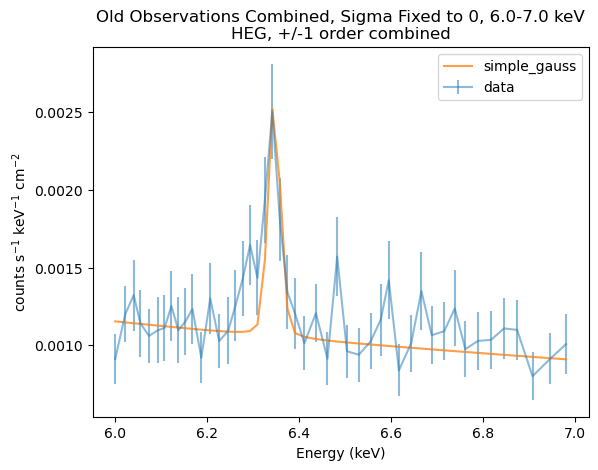

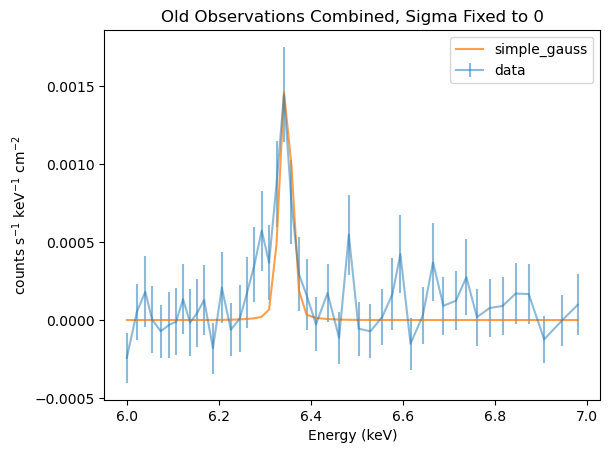

In [75]:
old_energy, old_counts, old_y_err, old_fit_sigma_fixed, old_data_minus_continuum, old_gauss_sigma_fixed, \
old_delchi_err_sigma_fixed, flux, eqwidth, p, sigma, oldobs_chisq_sigma_fixed, oldobs_dof_sigma_fixed \
    = analyze_spectra("simple_gauss", "Old Observations Combined, Sigma Fixed to 0", "1,3,5,8", \
    plot_entire_range = False, find_eqwidth = True, return_indiv_comp = True, plot_eqwidth=True)

In [76]:
p, sigma

(1.0, inf)

In [77]:
print_model_parameters(m, "sigma_fixed", "old")

zphabs*(zpowerlw+cflux*zgauss), sigma fixed to 0
1st number is parameter value, 2nd is plus 1sigma error, 3rd is minus 1sigma error

nH (10^22 atoms cm^-2): 1.52, +0.07, -0.07
PhoIndex Γ (unitless): 1.64, +0.04, -0.04
Power law norm (10^-2 photons/keV/cm^2/s): 2.30, +0.14, -0.13
Line Flux (10^-13 ergs cm^-2 s^-1): 5.64, +0.89, -0.89
Equivalent Width (eV): 51.0, +8.6, -8.1
chi_sq/dof: 496.5/790 = 0.6285


### Fitting two Gaussians, both with sigma fixed to 0 keV, to account for Fe Ka1 and Fe Ka2

In [ ]:
# This is how you define multiple components of same type in Pyxspec: https://heasarc.gsfc.nasa.gov/xanadu/xspec/python/html/extended.html#:~:text=However%20when%20a,it%20more%20simply%3A
m = Model("zphabs*(zpowerlw+cflux(zgauss+zgauss))","two_simple_gauss")

components = [m.zphabs, m.zpowerlw, m.zgauss, m.zgauss_5]

# Set the redshifts for each component
for component in components:
    component.Redshift = 0.00849

# List of value floats [val,delta,min,bot,top,max]. Note: Cannot set min and max for frozen parameters.
# Also, need to set the min equal to bot, and top equal to max when setting values this way
m.zpowerlw.PhoIndex = 1.4
m.cflux.Emin = 6.2
m.cflux.Emax = 6.45
m.zgauss.LineE = 6.404
m.zgauss.LineE.frozen = True
m.zgauss.Sigma = 0
m.zgauss.Sigma.frozen = True
m.zgauss.norm.frozen = True

m.zgauss_5.LineE = 6.391
m.zgauss_5.LineE.frozen = True
m.zgauss_5.Sigma = 0
m.zgauss_5.Sigma.frozen = True
m.zgauss_5.norm.frozen = True

In [ ]:
m.show()

In [ ]:
old_energy, old_counts, old_y_err, old_fit_two_sigma_fixed, old_data_minus_continuum, old_gauss_two_sigma_fixed, \
old_delchi_err_two_sigma_fixed, flux, eqwidth, p, sigma, oldobs_chisq_two_sigma_fixed, oldobs_dof_two_sigma_fixed \
    = analyze_spectra("two_simple_gauss", "2000,2005, Double Gaussians with Sigma Fixed to 0", "1,3,5,9,13", \
    fit_errors=False, plot_entire_range = True, find_eqwidth = True, return_indiv_comp = True, plot_eqwidth=True)

In [ ]:
p, sigma

In [ ]:
print_model_parameters(m, "sigma_fixed", "old", True, m.zgauss_5)

### Fitting Gaussian with sigma allowed to vary

In [78]:
m.zgauss.Sigma.frozen = False
m.show()


Fit statistic  : Chi-Squared                  496.51     using 794 bins.

Test statistic : Chi-Squared                  496.51     using 794 bins.
 Null hypothesis probability of 1.00e+00 with 789 degrees of freedom
 Current data and model not fit yet.

Model simple_gauss:zphabs<1>(zpowerlw<2> + cflux<3>*zgauss<4>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   zphabs     nH         10^22    1.51941      +/-  7.25038E-02  
   2    1   zphabs     Redshift            8.49000E-03  frozen
   3    2   zpowerlw   PhoIndex            1.64481      +/-  3.72014E-02  
   4    2   zpowerlw   Redshift            8.49000E-03  frozen
   5    2   zpowerlw   norm                2.30211E-02  +/-  1.35462E-03  
   6    3   cflux      Emin       keV      6.20000      frozen
   7    3   cflux      Emax       keV      6.45000      frozen
   8    3   cflux      lg10Flux   cgs      -12.2483     +/-  6.77001E-02  
   9    4   zgauss     LineE      keV      6


Fit statistic  : Chi-Squared                  496.51     using 794 bins.

Test statistic : Chi-Squared                  496.51     using 794 bins.
 Null hypothesis probability of 1.00e+00 with 789 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
Chi-Squared  |beta|/N    Lvl simple_gauss: simple_gauss: simple_gauss: simple_gauss: simple_gauss:
494.805      14.5554       0       1.51926       1.64492     0.0230199      -12.2241     0.0191561
493.426      37.9397      -1       1.51847       1.64586     0.0230284      -12.1426     0.0186403
493.401      1.3806       -2       1.52329       1.64879     0.0231309      -12.1411     0.0186977
493.387      11.8288      -3       1.53039       1.65263     0.0232719      -12.1398     0.0187827
493.387      5.21968      -4       1.53160       1.65327     0.0232961      -12.1393     0.0188440
 Variances and Principal Axes
         simple_gauss:1simple_gauss:3simple_gauss:5simple_gauss:8simple_gaus

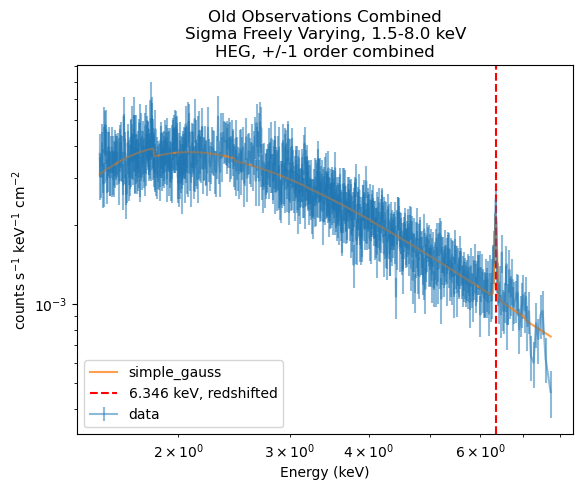

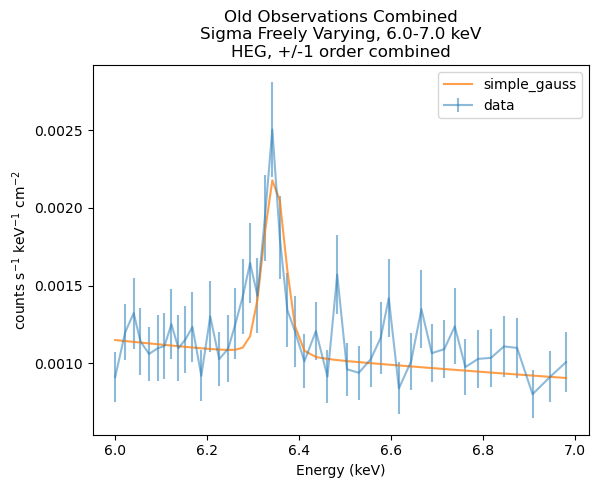

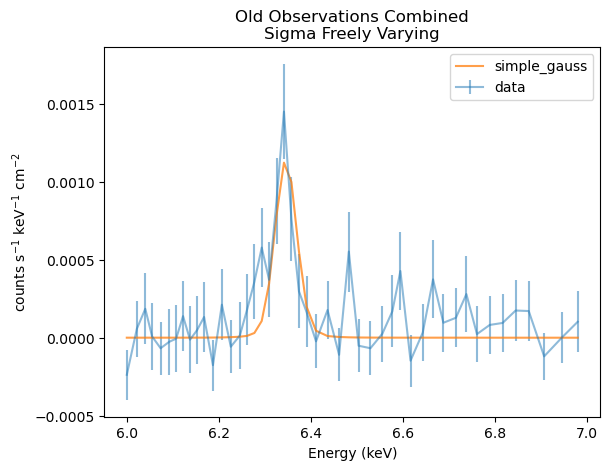

In [79]:
energy, counts, y_err, old_fit_sigma_vary, data_continuum, old_gauss_sigma_vary, \
    old_delchi_err_sigma_vary, flux, eqwidth, p, sigma, oldobs_chisq_sigma_vary, \
    oldobs_dof_sigma_vary = analyze_spectra("simple_gauss", \
    "Old Observations Combined\nSigma Freely Varying", "1,3,5,8,10", \
    return_indiv_comp=True, find_eqwidth = True)

In [80]:
p, sigma

(1.0, inf)

In [81]:
print_model_parameters(m, "sigma_vary", "old")

zphabs*(zpowerlw+cflux*zgauss), sigma freely varying
1st number is parameter value, 2nd is plus 1sigma error, 3rd is minus 1sigma error

nH (10^22 atoms cm^-2): 1.53, +0.07, -0.07
PhoIndex Γ (unitless): 1.65, +0.04, -0.04
Power law norm (10^-2 photons/keV/cm^2/s): 2.33, +0.14, -0.13
Gaussian sigma (eV): 18.8, +11.2, -8.6
Line Flux (10^-13 ergs cm^-2 s^-1): 7.26, +1.53, -1.35
Equivalent Width (eV): 65.8, +10.9, -11.0
chi_sq/dof: 493.4/789 = 0.6253


### Fitting two Gaussians with sigma allowed to vary

m.zgauss.Sigma.frozen = False
m.zgauss_5.Sigma.frozen = False
m.show()

energy, counts, y_err, old_fit_two_sigma_vary, data_continuum, old_gauss_two_sigma_vary, \
    old_delchi_err_two_sigma_vary, flux, eqwidth, p, sigma, oldobs_chisq_two_sigma_vary, \
    oldobs_dof_two_sigma_vary = analyze_spectra("two_simple_gauss", \
    "2000,2005\nBoth Sigmas Freely Varying", "1,3,5,8,10,14", \
    fit_errors=True, return_indiv_comp=True, find_eqwidth = True)

p, sigma

print_model_parameters(m, "sigma_vary", "old", True, m.zgauss_5)

### Doing F-test to see significance value of thawing sigma actually makes a difference in the fit.

In [ ]:
oldobs_dof_sigma_vary, oldobs_dof_sigma_fixed # Looks right

In [ ]:
oldobs_p_ftest_thawing_sigma = Fit.ftest(oldobs_chisq_sigma_vary, oldobs_dof_sigma_vary, oldobs_chisq_sigma_fixed, oldobs_dof_sigma_fixed)

In [ ]:
pvalue_to_sigma(oldobs_p_ftest_thawing_sigma)

### xillver

In [ ]:
m_xillver = Model("zphabs*(zpowerlw+cflux*atable{xillver-a-Ec5.fits})","xillver")
m_xillver.zphabs.Redshift = 0.00849
m_xillver.zpowerlw.Redshift = 0.00849
m_xillver.zpowerlw.PhoIndex.link = m_xillver.xillverEc.Gamma
m_xillver.cflux.Emin = 6.2
m_xillver.cflux.Emax = 6.45
#m_xillver.xillverEc.A_Fe.frozen = True
m_xillver.xillverEc.logXi = 0
m_xillver.xillverEc.logXi.frozen = True
m_xillver.xillverEc.Ecut.frozen = True
#m_xillver.xillverEc.Incl.frozen = True
m_xillver.xillverEc.z = 0.00849
m_xillver.xillverEc.norm.frozen = True

In [ ]:
m_xillver.show()

In [ ]:
energy, counts, y_err, old_fit_xillver, data_continuum, old_xillver, old_delchi_err_xillver, flux, eqwidth, p, sigma, \
oldobs_chisq_xillver, oldobs_dof_xillver = analyze_spectra("xillver", "Old Observations Combined, \
xillver", "1,5,8,9,10,13", fit_errors=True, find_eqwidth = True, return_indiv_comp=True, plot_eqwidth=False)

In [ ]:
p, sigma

In [ ]:
print_model_parameters(m_xillver, "xillver", "old")

### F-test between xillver and Gaussian with sigma fixed

In [ ]:
#oldobs_dof_xillver, oldobs_dof_sigma_fixed

In [ ]:
#oldobs_p_ftest_xillver_vs_sigma_fixed = Fit.ftest(oldobs_chisq_xillver, oldobs_dof_xillver, oldobs_chisq_sigma_fixed, oldobs_dof_sigma_fixed)

In [ ]:
#pvalue_to_sigma(oldobs_p_ftest_xillver_vs_sigma_fixed)

### F-test between xillver and Gaussian with free sigma

In [ ]:
#oldobs_dof_xillver, oldobs_dof_sigma_vary

In [ ]:
#oldobs_p_ftest_xillver_vs_sigma_vary = Fit.ftest(oldobs_chisq_xillver, oldobs_dof_xillver, oldobs_chisq_sigma_vary, oldobs_dof_sigma_vary)

In [ ]:
#pvalue_to_sigma(oldobs_p_ftest_xillver_vs_sigma_vary)

### rdblur*mytorus

In [16]:
m_rdblur_mytorus = Model("zphabs(zpowerlw + cflux*rdblur*atable{mytl_V000010nEp000H500_v00.fits})","rdblur_mytorus")

components = [m_rdblur_mytorus.zphabs, m_rdblur_mytorus.zpowerlw]
for component in components:
    component.Redshift = 0.00849

components_2 = [m_rdblur_mytorus.MYTorusL]
for component in components_2:
    component.z = 0.00849

m_rdblur_mytorus.zpowerlw.PhoIndex = 1.9
m_rdblur_mytorus.MYTorusL.PhoIndx.link = m_rdblur_mytorus.zpowerlw.PhoIndex
m_rdblur_mytorus.MYTorusL.NH.link = m_rdblur_mytorus.zphabs.nH
m_rdblur_mytorus.MYTorusL.IncAng = 60
m_rdblur_mytorus.MYTorusL.IncAng.frozen = False
m_rdblur_mytorus.MYTorusL.norm.frozen = True
m_rdblur_mytorus.cflux.Emin = 6.2
m_rdblur_mytorus.cflux.Emax = 6.45
m_rdblur_mytorus.rdblur.Betor10 = "-2.5,,-4.0,-4.0,-2.0,-2.0"
m_rdblur_mytorus.rdblur.Betor10.frozen = False
m_rdblur_mytorus.rdblur.Rin_M = 100
m_rdblur_mytorus.rdblur.Rin_M.frozen = False
m_rdblur_mytorus.rdblur.Rout_M = 1e6
m_rdblur_mytorus.rdblur.Incl.link = m_rdblur_mytorus.MYTorusL.IncAng


Model rdblur_mytorus:zphabs<1>(zpowerlw<2> + cflux<3>*rdblur<4>*atable{mytl_V000010nEp000H500_v00.fits}<5>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   zphabs     nH         10^22    1.00000      +/-  0.0          
   2    1   zphabs     Redshift            0.0          frozen
   3    2   zpowerlw   PhoIndex            1.00000      +/-  0.0          
   4    2   zpowerlw   Redshift            0.0          frozen
   5    2   zpowerlw   norm                1.00000      +/-  0.0          
   6    3   cflux      Emin       keV      0.500000     frozen
   7    3   cflux      Emax       keV      10.0000      frozen
   8    3   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   9    4   rdblur     Betor10             -2.00000     frozen
  10    4   rdblur     Rin_M               10.0000      frozen
  11    4   rdblur     Rout_M              1000.00      frozen
  12    4   rdblur     Incl       deg      30.0000      +/-  0.0

In [17]:
m_rdblur_mytorus.show()


Model rdblur_mytorus:zphabs<1>(zpowerlw<2> + cflux<3>*rdblur<4>*atable{mytl_V000010nEp000H500_v00.fits}<5>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   zphabs     nH         10^22    1.00000      +/-  0.0          
   2    1   zphabs     Redshift            8.49000E-03  frozen
   3    2   zpowerlw   PhoIndex            1.90000      +/-  0.0          
   4    2   zpowerlw   Redshift            8.49000E-03  frozen
   5    2   zpowerlw   norm                1.00000      +/-  0.0          
   6    3   cflux      Emin       keV      6.20000      frozen
   7    3   cflux      Emax       keV      6.45000      frozen
   8    3   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   9    4   rdblur     Betor10             -2.50000     +/-  0.0          
  10    4   rdblur     Rin_M               100.000      +/-  0.0          
  11    4   rdblur     Rout_M              1.00000E+06  frozen
  12    4   rdblur     Incl       deg   


Fit statistic  : Chi-Squared                 1686.16     using 794 bins.

Test statistic : Chi-Squared                 1686.16     using 794 bins.
 Null hypothesis probability of 1.63e-67 with 787 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
Chi-Squared  |beta|/N    Lvl rdblur_mytoru rdblur_mytoru rdblur_mytoru rdblur_mytoru rdblur_mytoru rdblur_mytoru rdblur_mytoru
512.435      368.496      -3       1.36384       1.57570     0.0204772      -12.0114      -2.20584       123.691       84.4694
496.327      814.6        -4       1.59785       1.70104     0.0244783      -12.0084      -2.01462       29.5090       89.3167
496.2        2284.58      -2       1.58954       1.69497     0.0246749      -12.0213      -2.20039       13.9312       41.2968
490.634      478.666      -3       1.59674       1.70000     0.0248455      -11.9900      -2.09062       6.42290       32.9968
488.419      199.196      -4       1.58148       1.68551     0.02

***Warning: New best fit found, fit parameters will be set to new values.
***Warning: Identical values of the parameter give different values of the statistic.
Please check your result for the high end of the confidence range.
***Warning: Parameter pegged at hard limit: -2
***Warning: Parameter pegged at hard limit: 6


p value: 1.0
Sigma level of confidence: inf
equivalent width: (0.09617829944, 0.08347469457, 0.1264009382)


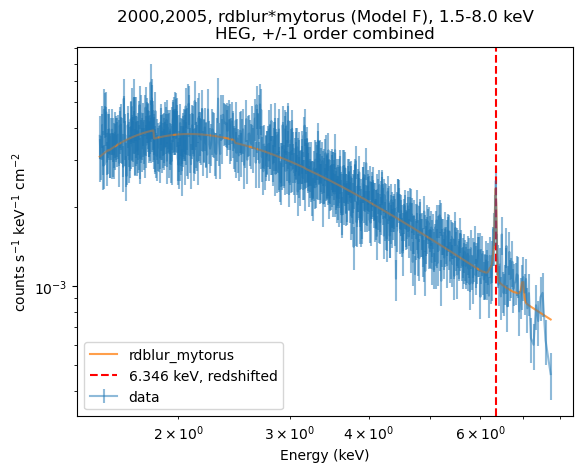

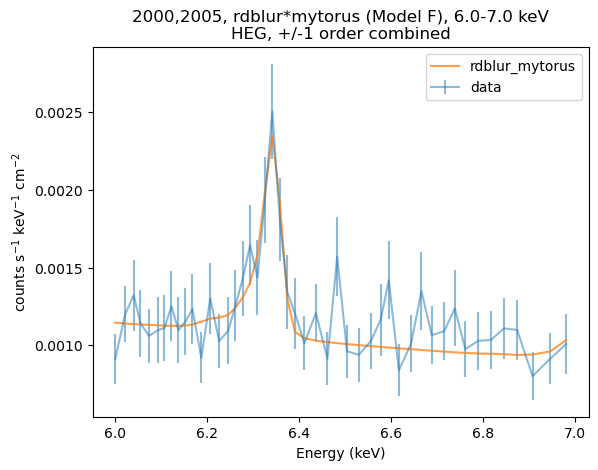

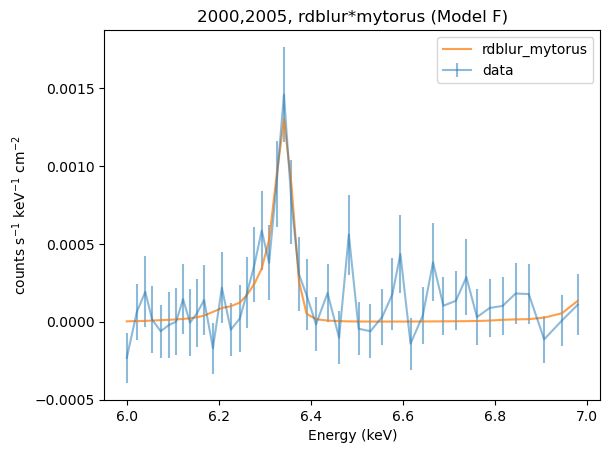

In [18]:
energy, counts, y_err, old_fit_rdblur_mytorus, data_continuum, old_rdblur_mytorus, old_delchi_err_rdblur_mytorus, flux, eqwidth, p, sigma, \
oldobs_chisq_rdblur_mytorus, oldobs_dof_rdblur_mytorus = analyze_spectra("rdblur_mytorus", "2000,2005, \
rdblur*mytorus (Model F)", "1,3,5,8,9,10,14", fit_errors=True, find_eqwidth = True, return_indiv_comp=True, plot_eqwidth=False)

In [19]:
p, sigma

(1.0, inf)

In [20]:
print_model_parameters(m_rdblur_mytorus,"rdblur_mytorus","old")

1st number is parameter value, 2nd is plus 1sigma error, 3rd is minus 1sigma error

nH (10^22 atoms cm^-2): 1.55, +0.08, -0.07
PhoIndex Γ (unitless): 1.66, +0.04, -0.03
Power law norm (10^-2 photons/keV/cm^2/s): 2.37, +0.17, -0.12
Emissitivity index q (unitless): 2.26, +0.39, -2.26
Inner radius R_in (GM/c^2): 228, +5429, -228
Inclination (deg): 6.95, +15.44, -6.95
Line Flux (10^-13 ergs cm^-2 s^-1): 8.62, +1.36, -1.25
Equivalent Width (eV): 96.2, +30.2, -12.7
chi_sq/dof: 486.2/787 = 0.6178


### F-test between rdblur*mytorus and Gaussian with free sigma

In [209]:
oldobs_dof_rdblur_mytorus, oldobs_dof_sigma_vary

(787, 789)

In [210]:
oldobs_p_ftest_rdblur_mytorus_vs_sigma_vary = Fit.ftest(oldobs_chisq_rdblur_mytorus, oldobs_dof_rdblur_mytorus, oldobs_chisq_sigma_vary, oldobs_dof_sigma_vary)

 F statistic value = 5.7909 and probability 0.00318692


In [211]:
pvalue_to_sigma(oldobs_p_ftest_rdblur_mytorus_vs_sigma_vary)

2.7279028076760374

### mytorus

In [85]:
m_mytorus = Model("zphabs(zpowerlw + cflux*atable{mytl_V000010nEp000H500_v00.fits})","mytorus")

components = [m_mytorus.zphabs, m_mytorus.zpowerlw]
for component in components:
    component.Redshift = 0.00849

components_2 = [m_mytorus.MYTorusL]
for component in components_2:
    component.z = 0.00849

m_mytorus.zpowerlw.PhoIndex = 1.9
m_mytorus.MYTorusL.PhoIndx.link = m_mytorus.zpowerlw.PhoIndex
m_mytorus.MYTorusL.NH.link = m_mytorus.zphabs.nH
m_mytorus.MYTorusL.IncAng = 60
m_mytorus.MYTorusL.norm.frozen = True
m_mytorus.cflux.Emin = 6.2
m_mytorus.cflux.Emax = 6.45


Previous model: simple_gauss for source #: 1 has been rendered inactive.

Model mytorus:zphabs<1>(zpowerlw<2> + cflux<3>*atable{mytl_V000010nEp000H500_v00.fits}<4>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   zphabs     nH         10^22    1.00000      +/-  0.0          
   2    1   zphabs     Redshift            0.0          frozen
   3    2   zpowerlw   PhoIndex            1.00000      +/-  0.0          
   4    2   zpowerlw   Redshift            0.0          frozen
   5    2   zpowerlw   norm                1.00000      +/-  0.0          
   6    3   cflux      Emin       keV      0.500000     frozen
   7    3   cflux      Emax       keV      10.0000      frozen
   8    3   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   9    4   MYTorusL   NH         10^24    0.100000     +/-  0.0          
  10    4   MYTorusL   IncAng     Degrees  90.0000      frozen
  11    4   MYTorusL   PhoIndx             1.90000      +/

In [86]:
m_mytorus.show()


Model mytorus:zphabs<1>(zpowerlw<2> + cflux<3>*atable{mytl_V000010nEp000H500_v00.fits}<4>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   zphabs     nH         10^22    1.00000      +/-  0.0          
   2    1   zphabs     Redshift            8.49000E-03  frozen
   3    2   zpowerlw   PhoIndex            1.90000      +/-  0.0          
   4    2   zpowerlw   Redshift            8.49000E-03  frozen
   5    2   zpowerlw   norm                1.00000      +/-  0.0          
   6    3   cflux      Emin       keV      6.20000      frozen
   7    3   cflux      Emax       keV      6.45000      frozen
   8    3   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   9    4   MYTorusL   NH         10^24    1.00000      = mytorus:p1
  10    4   MYTorusL   IncAng     Degrees  60.0000      frozen
  11    4   MYTorusL   PhoIndx             1.90000      = mytorus:p3
  12    4   MYTorusL   z                   8.49000E-03  frozen
  13  


Fit statistic  : Chi-Squared                 1773.36     using 794 bins.

Test statistic : Chi-Squared                 1773.36     using 794 bins.
 Null hypothesis probability of 2.42e-77 with 790 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
Chi-Squared  |beta|/N    Lvl  mytorus:1:nH mytorus:3:Pho mytorus:5:nor mytorus:8:lg1
504.104      679.75       -3       1.31817       1.54213     0.0192751      -12.1202
496.98       3625.36      -4       1.53598       1.65734     0.0230340      -12.1443
490.171      4414.59      -5       1.54085       1.65943     0.0235004      -12.1450
490.171      16.9644      -6       1.54086       1.65944     0.0235020      -12.1450
 Variances and Principal Axes
         mytorus:1mytorus:3mytorus:5mytorus:8  
 2.1975E-08| -0.0049  -0.0279   0.9996   0.0002  
 1.7761E-04|  0.4378  -0.8985  -0.0230   0.0224  
 3.8261E-03|  0.2104   0.0781   0.0034  -0.9745  
 6.7103E-03|  0.8741   0.4311   0.0163   0.2234

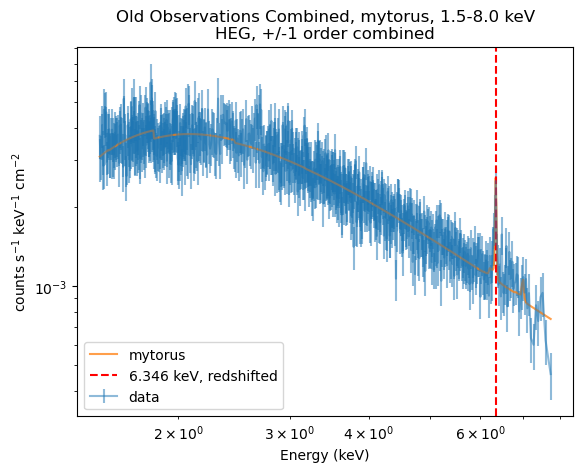

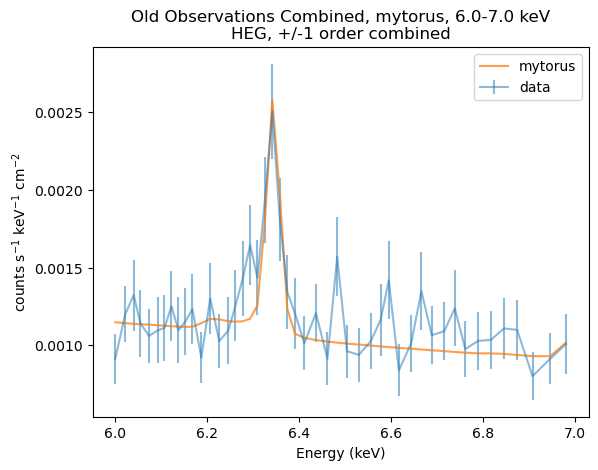

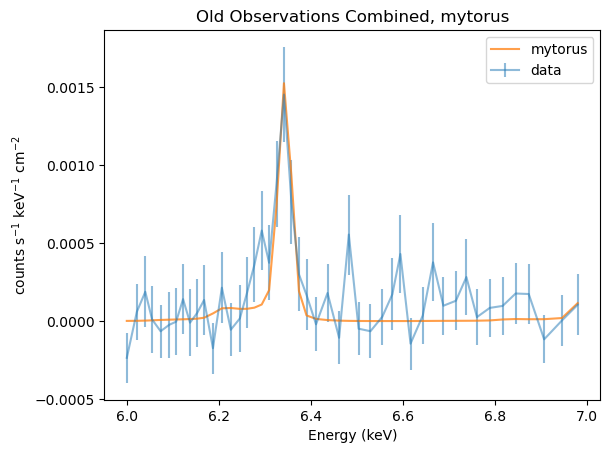

In [87]:
# Plotting WITH obtaining errors
energy, counts, y_err, old_fit_mytorus, data_continuum, old_mytorus, old_delchi_err_mytorus, flux, eqwidth, p, sigma, \
oldobs_chisq_mytorus, oldobs_dof_mytorus = analyze_spectra("mytorus", "Old Observations Combined, \
mytorus", "1,3,5,8", fit_errors=True, find_eqwidth = True, return_indiv_comp=True, plot_eqwidth=False)

In [88]:
p, sigma

(1.0, inf)

In [89]:
print_model_parameters(m_mytorus,"mytorus","old")

1st number is parameter value, 2nd is plus 1sigma error, 3rd is minus 1sigma error

nH (10^22 atoms cm^-2): 1.54, +0.07, -0.07
PhoIndex Γ (unitless): 1.66, +0.04, -0.04
Power law norm (10^-2 photons/keV/cm^2/s): 2.35, +0.14, -0.14
Line Flux (10^-13 ergs cm^-2 s^-1): 7.16, +1.05, -1.05
Equivalent Width (eV): 78.9, +13.0, -9.7
chi_sq/dof: 490.2/790 = 0.6205


### F-test between rdblur*mytorus and mytorus without rdblur's line broadening

In [212]:
oldobs_dof_rdblur_mytorus, oldobs_dof_mytorus

(787, 790)

In [213]:
oldobs_p_ftest_rdblur_mytorus_vs_mytorus = Fit.ftest(oldobs_chisq_rdblur_mytorus, oldobs_dof_rdblur_mytorus, oldobs_chisq_mytorus, oldobs_dof_mytorus)

 F statistic value = 2.12563 and probability 0.09555


In [214]:
pvalue_to_sigma(oldobs_p_ftest_rdblur_mytorus_vs_mytorus)

1.3073320444930916

### F-test between mytorus and Gaussian with free sigma

In [8]:
oldobs_dof_mytorus, oldobs_dof_sigma_vary

NameError: name 'oldobs_dof_mytorus' is not defined

In [ ]:
oldobs_p_ftest_mytorus_vs_sigma_vary = Fit.ftest(oldobs_chisq_mytorus, oldobs_dof_mytorus, oldobs_chisq_sigma_vary, oldobs_dof_sigma_vary)

In [ ]:
pvalue_to_sigma(oldobs_p_ftest_xillver_vs_sigma_vary)

### Fitting Gaussian convolved by rdblur with q fixed at -3

In [ ]:
m_rdblur = Model("zphabs*(zpowerlw+cflux*rdblur*zgauss)","rdblur")
components = [m_rdblur.zphabs, m_rdblur.zpowerlw, m_rdblur.zgauss]

# Set the redshifts for each component
for component in components:
    component.Redshift = 0.00849

# List of value floats [val,delta,min,bot,top,max]. Note: Cannot set min and max for frozen parameters.
# Also, need to set the min equal to bot, and top equal to max when setting values this way
m_rdblur.zpowerlw.PhoIndex = 1.4
m_rdblur.zgauss.LineE = 6.4
m_rdblur.zgauss.LineE.frozen = True
m_rdblur.zgauss.Sigma = 0
m_rdblur.zgauss.Sigma.frozen = True
m_rdblur.zgauss.norm.frozen = True
m_rdblur.cflux.Emin = 6.2
m_rdblur.cflux.Emax = 6.45
m_rdblur.rdblur.Betor10 = -3
m_rdblur.rdblur.Rin_M = 100
m_rdblur.rdblur.Rin_M.frozen = False
m_rdblur.rdblur.Rout_M = 1e06
m_rdblur.rdblur.Rout_M.frozen = True
m_rdblur.rdblur.Incl.values = 10
m_rdblur.rdblur.Incl.frozen = False

In [ ]:
m_rdblur.show()

In [ ]:
energy, counts, y_err, old_fit_rdblur_q_fixed, data_continuum, old_gauss_rdblur_q_fixed, old_delchi_err_rdblur_q_fixed, \
flux, eqwidth, p, sigma, oldobs_chisq_rdblur_q_fixed, oldobs_dof_rdblur_q_fixed \
= analyze_spectra("rdblur", "Old Observations Combined, rdblurred", "1,3,5,8,10,12", fit_errors=True, \
                  find_eqwidth=True, return_indiv_comp=True)

In [ ]:
p, sigma

In [ ]:
print_model_parameters(m_rdblur, "rdblur_q_fixed", "old")

### Fitting two Gaussians convolved by rdblur with q fixed at -3

m_rdblur = Model("zphabs*(zpowerlw+cflux*rdblur*(zgauss+zgauss))","rdblur")
components = [m_rdblur.zphabs, m_rdblur.zpowerlw, m_rdblur.zgauss, m]

Set the redshifts for each component
for component in components:
    component.Redshift = 0.00849

 List of value floats [val,delta,min,bot,top,max]. Note: Cannot set min and max for frozen parameters.
 Also, need to set the min equal to bot, and top equal to max when setting values this way
m_rdblur.zpowerlw.PhoIndex = 1.4
m_rdblur.zgauss.LineE = 6.4
m_rdblur.zgauss.LineE.frozen = True
m_rdblur.zgauss.Sigma = 0
m_rdblur.zgauss.Sigma.frozen = True
m_rdblur.zgauss.norm.frozen = True
m_rdblur.cflux.Emin = 6.2
m_rdblur.cflux.Emax = 6.45
m_rdblur.rdblur.Betor10 = -3
m_rdblur.rdblur.Rin_M = 100
m_rdblur.rdblur.Rin_M.frozen = False
m_rdblur.rdblur.Rout_M = 1e06
m_rdblur.rdblur.Rout_M.frozen = True
m_rdblur.rdblur.Incl.values = 10
m_rdblur.rdblur.Incl.frozen = False

m_rdblur.show()

energy, counts, y_err, old_fit_rdblur_q_fixed, data_continuum, old_gauss_rdblur_q_fixed, old_delchi_err_rdblur_q_fixed, \
flux, eqwidth, p, sigma, oldobs_chisq_rdblur_q_fixed, oldobs_dof_rdblur_q_fixed \
= analyze_spectra("rdblur", "Old Observations Combined, rdblurred", "1,3,5,8,10,12", fit_errors=True, \
                  find_eqwidth=True, return_indiv_comp=True)

p, sigma

print_model_parameters(m_rdblur, "rdblur_q_fixed", "old")

### Fitting Gaussian convolved by rdblur

In [ ]:
m_rdblur.rdblur.Betor10.frozen = False
m_rdblur.rdblur.Betor10.values = "-2.5,,-4.0,-4.0,-2.0,-2.0"
m_rdblur.rdblur.Incl.values = "10,,3,3,87,87"
m_rdblur.rdblur.Incl.frozen = False

In [ ]:
m_rdblur.show()

In [ ]:
energy, counts, y_err, old_fit_rdblur, data_continuum, old_gauss_rdblur, old_delchi_err_rdblur, \
flux, eqwidth, p, sigma, oldobs_chisq_rdblur, oldobs_dof_rdblur \
= analyze_spectra("rdblur", "Old Observations Combined, rdblurred", "1,3,5,8,9,10,12", fit_errors=True, \
                  find_eqwidth=True, return_indiv_comp=True)

In [ ]:
p, sigma

In [ ]:
print_model_parameters(m_rdblur, "rdblur", "old")

### F-test between rdblur of mytorus and rdblur of zgauss with q fixed

In [ ]:
oldobs_dof_rdblur_mytorus, oldobs_dof_rdblur_q_fixed

In [ ]:
oldobs_p_ftest_rdblur_mytorus_vs_rdblur_q_fixed = Fit.ftest(oldobs_chisq_rdblur_mytorus, oldobs_dof_rdblur_mytorus, oldobs_chisq_rdblur_q_fixed, oldobs_dof_rdblur_q_fixed)

In [ ]:
pvalue_to_sigma(oldobs_p_ftest_rdblur_mytorus_vs_rdblur_q_fixed)

### F-test between fixed q and free q

In [ ]:
oldobs_dof_rdblur, oldobs_dof_rdblur_q_fixed

In [ ]:
oldobs_p_ftest_q_vary = Fit.ftest(oldobs_chisq_rdblur, oldobs_dof_rdblur, oldobs_chisq_rdblur_q_fixed, oldobs_dof_rdblur_q_fixed)

In [ ]:
pvalue_to_sigma(oldobs_p_ftest_q_vary)

### F-test between Gaussian w/ sigma varying and rdblur q fixed

In [ ]:
#oldobs_dof_rdblur_q_fixed, oldobs_dof_sigma_vary

In [ ]:
#oldobs_p_ftest_addrdblur = Fit.ftest(oldobs_chisq_rdblur_q_fixed, oldobs_dof_rdblur_q_fixed, oldobs_chisq_sigma_vary, oldobs_dof_sigma_vary)
oldobs_p_ftest_addrdblur = Fit.ftest(487.94, 788, 493.39, 789)

In [ ]:
pvalue_to_sigma(oldobs_p_ftest_addrdblur)

### F-test between Gaussian w/ sigma varying and Gaussian convolved by rdblur

In [ ]:
oldobs_dof_rdblur, oldobs_dof_sigma_vary

In [ ]:
oldobs_p_ftest_addrdblur = Fit.ftest(oldobs_chisq_rdblur, oldobs_dof_rdblur, oldobs_chisq_sigma_vary, oldobs_dof_sigma_vary)

In [ ]:
pvalue_to_sigma(oldobs_p_ftest_addrdblur)

### Quick Look Plots

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(20,5))
axs[0].errorbar(old_energy, old_counts, old_y_err, color="black",alpha=0.5)
axs[0].plot(old_energy, old_fit_sigma_fixed,alpha=0.75)
axs[0].set_title("Gaussian fit\nSigma Fixed to Zero")
axs[1].errorbar(old_energy, old_counts, old_y_err, color="black",alpha=0.5)
axs[1].plot(old_energy, old_fit_sigma_vary,alpha=0.75)
axs[1].set_title("Gaussian fit\nSigma freely varying")
axs[2].errorbar(old_energy, old_counts, old_y_err, color="black",alpha=0.5)
axs[2].plot(old_energy, old_fit_xillver,alpha=0.75)
axs[2].set_title("xillver")
axs[3].errorbar(old_energy, old_counts, old_y_err, color="black",alpha=0.5)
axs[3].plot(old_energy, old_fit_rdblur_q_fixed,alpha=0.75)
axs[3].set_title("Gaussian convolved w/ rdblur q fixed")
fig.supylabel("Counts/sec/keV")
fig.supxlabel("Energy (keV)")
fig.suptitle("Old Observations")
plt.savefig("oldobs_with_xillver.png")

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(20,5))
axs[0].errorbar(old_energy, old_data_minus_continuum, old_y_err, color="black", alpha=0.5)
axs[0].plot(old_energy, old_gauss_sigma_fixed, alpha=0.75)
axs[0].set_title("Gaussian fit\nSigma Fixed to Zero")
axs[1].errorbar(old_energy, old_data_minus_continuum, old_y_err, color="black", alpha=0.5)
axs[1].plot(old_energy, old_gauss_sigma_vary, alpha=0.75)
axs[1].set_title("Gaussian fit\nSigma freely varying")
axs[2].errorbar(old_energy, old_data_minus_continuum, old_y_err, color="black", alpha=0.5)
axs[2].plot(old_energy, old_xillver, alpha=0.75)
axs[2].set_title("xillver")
axs[3].errorbar(old_energy, old_data_minus_continuum, old_y_err, color="black", alpha=0.5)
axs[3].plot(old_energy, old_gauss_rdblur_q_fixed, alpha=0.75)
axs[3].set_title("Gaussian convolved w/ rdblur")
fig.supylabel("Counts/sec/keV/cm^2")
fig.supxlabel("Energy (keV)")
fig.suptitle("2000+2005 Flux Observations with Continuum Subtracted")
plt.savefig("oldobs_continuum_subtracted_with_xillver.png")

# Analyzing New Observations

### Load in spectra

In [26]:
AllData.clear()
AllModels.clear()
s = Spectrum("newobs_grouped.pha")
AllData.ignore("bad")
s.ignore("**-1.5,8.0-**")


1 spectrum  in use
 
Spectral Data File: newobs_grouped.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.903e-01 +/- 1.517e-03 (99.1 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-1247
  Telescope: CHANDRA Instrument: ACIS  Channel Type: PI
  Exposure Time: 2.264e+05 sec
 Using fit statistic: chi
 Using Background File                newobs_comb_bkg.pha
  Background Exposure Time: 2.264e+05 sec
 Using Response (RMF) File            newobs_comb.rmf for Source 1
 Using Auxiliary Response (ARF) File  newobs_comb.arf


ignore:   231 channels ignored from  source number 1
    30 channels (1-30) ignored in spectrum #     1
   220 channels (1028-1247) ignored in spectrum #     1



### Fitting Gaussian with sigma fixed to 0 keV

In [39]:
m = Model("zphabs*(zpowerlw+cflux*zgauss)","simple_gauss")
components = [m.zphabs, m.zpowerlw, m.zgauss]

# Set the redshifts for each component
for component in components:
    component.Redshift = 0.00849

# List of value floats [val,delta,min,bot,top,max]. Note: Cannot set min and max for frozen parameters.
# Also, need to set the min equal to bot, and top equal to max when setting values this way
m.zpowerlw.PhoIndex = 1.4
m.cflux.Emin = 6.2
m.cflux.Emax = 6.45
m.zgauss.LineE = 6.4
m.zgauss.LineE.frozen = True
m.zgauss.Sigma = 0
m.zgauss.Sigma.frozen = True
m.zgauss.norm.frozen = True


Previous model: mytorus for source #: 1 has been rendered inactive.

Model simple_gauss:zphabs<1>(zpowerlw<2> + cflux<3>*zgauss<4>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   zphabs     nH         10^22    1.00000      +/-  0.0          
   2    1   zphabs     Redshift            0.0          frozen
   3    2   zpowerlw   PhoIndex            1.00000      +/-  0.0          
   4    2   zpowerlw   Redshift            0.0          frozen
   5    2   zpowerlw   norm                1.00000      +/-  0.0          
   6    3   cflux      Emin       keV      0.500000     frozen
   7    3   cflux      Emax       keV      10.0000      frozen
   8    3   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   9    4   zgauss     LineE      keV      6.50000      +/-  0.0          
  10    4   zgauss     Sigma      keV      0.100000     +/-  0.0          
  11    4   zgauss     Redshift            0.0          frozen
  12    4   zgau

In [40]:
m.show()


Model simple_gauss:zphabs<1>(zpowerlw<2> + cflux<3>*zgauss<4>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   zphabs     nH         10^22    1.00000      +/-  0.0          
   2    1   zphabs     Redshift            8.49000E-03  frozen
   3    2   zpowerlw   PhoIndex            1.40000      +/-  0.0          
   4    2   zpowerlw   Redshift            8.49000E-03  frozen
   5    2   zpowerlw   norm                1.00000      +/-  0.0          
   6    3   cflux      Emin       keV      6.20000      frozen
   7    3   cflux      Emax       keV      6.45000      frozen
   8    3   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   9    4   zgauss     LineE      keV      6.40000      frozen
  10    4   zgauss     Sigma      keV      0.0          frozen
  11    4   zgauss     Redshift            8.49000E-03  frozen
  12    4   zgauss     norm                1.00000      frozen
______________________________________________


Fit statistic  : Chi-Squared                  884.71     using 986 bins.

Test statistic : Chi-Squared                  884.71     using 986 bins.
 Null hypothesis probability of 9.88e-01 with 982 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
Chi-Squared  |beta|/N    Lvl simple_gauss: simple_gauss: simple_gauss: simple_gauss:
833.266      142.056      -3       1.47655       1.64586     0.0176574      -12.2177
676.983      33472.7      -4       1.55941       1.68736     0.0199680      -12.2975
675.522      3035.19      -5       1.55662       1.68580     0.0200369      -12.3071
675.522      6.38721      -6       1.55664       1.68582     0.0200372      -12.3073
 Variances and Principal Axes
         simple_gauss:1simple_gauss:3simple_gauss:5simple_gauss:8  
 9.5688E-09| -0.0037  -0.0247   0.9997   0.0001  
 1.1662E-04|  0.4169  -0.9086  -0.0209   0.0149  
 2.2446E-03|  0.1120   0.0351   0.0014  -0.9931  
 4.2046E-03|  0.9020   0.41

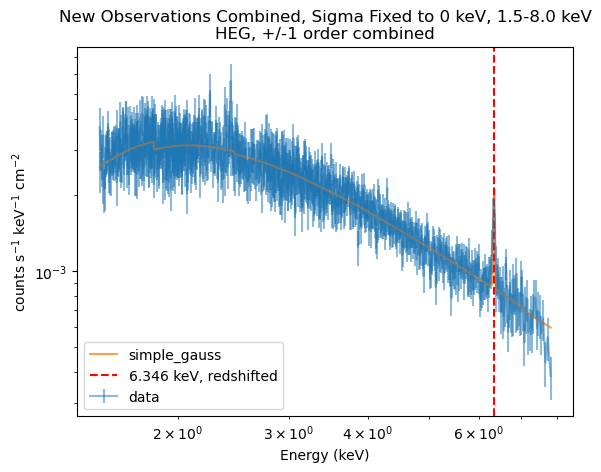

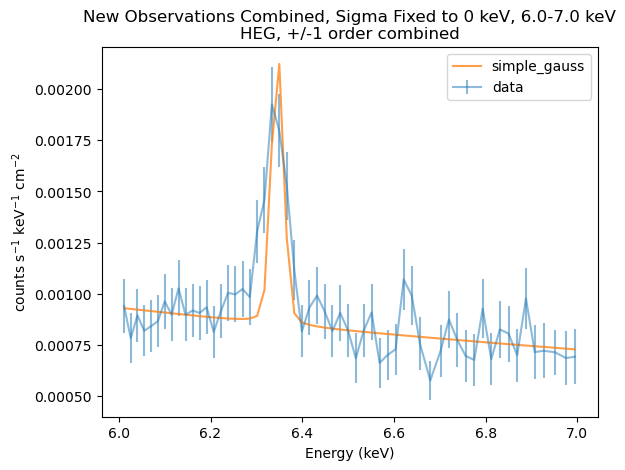

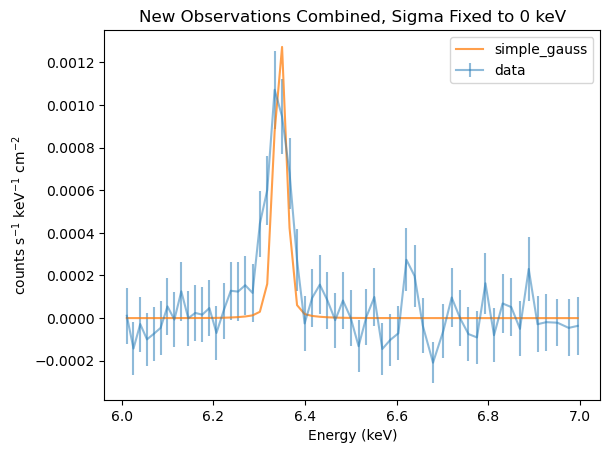

In [41]:
new_energy, new_counts, new_y_err, new_fit_sigma_fixed, new_data_minus_continuum, new_gauss_sigma_fixed, new_delchi_err_sigma_fixed, \
flux, eqwidth, p, sigma, newobs_chisq_sigma_fixed, newobs_dof_sigma_fixed = \
analyze_spectra("simple_gauss", "New Observations Combined, Sigma Fixed to 0 keV", \
                "1,3,5,8", find_eqwidth = True, plot_eqwidth=False)

In [42]:
p, sigma

(0.9999999999999966, 7.786604801354373)

In [43]:
print_model_parameters(m, "sigma_fixed", "new")

zphabs*(zpowerlw+cflux*zgauss), sigma fixed to 0
1st number is parameter value, 2nd is plus 1sigma error, 3rd is minus 1sigma error

nH (10^22 atoms cm^-2): 1.56, +0.06, -0.06
PhoIndex Γ (unitless): 1.69, +0.03, -0.03
Power law norm (10^-2 photons/keV/cm^2/s): 2.00, +0.09, -0.09
Line Flux (10^-13 ergs cm^-2 s^-1): 4.93, +0.55, -0.55
Equivalent Width (eV): 55.2, +7.4, -5.3
chi_sq/dof: 675.5/982 = 0.6879


### Fitting two Gaussians, both with sigma fixed to 0 keV, to account for Fe Ka1 and Fe Ka2

In [ ]:
# This is how you define multiple components of same type in Pyxspec: https://heasarc.gsfc.nasa.gov/xanadu/xspec/python/html/extended.html#:~:text=However%20when%20a,it%20more%20simply%3A
m = Model("zphabs*(zpowerlw+cflux(zgauss+zgauss))","two_simple_gauss")

components = [m.zphabs, m.zpowerlw, m.zgauss, m.zgauss_5]

# Set the redshifts for each component
for component in components:
    component.Redshift = 0.00849

# List of value floats [val,delta,min,bot,top,max]. Note: Cannot set min and max for frozen parameters.
# Also, need to set the min equal to bot, and top equal to max when setting values this way
m.zpowerlw.PhoIndex = 1.4
m.cflux.Emin = 6.2
m.cflux.Emax = 6.45
m.zgauss.LineE = 6.404
m.zgauss.LineE.frozen = True
m.zgauss.Sigma = 0
m.zgauss.Sigma.frozen = True
m.zgauss.norm.frozen = True

m.zgauss_5.LineE = 6.391
m.zgauss_5.LineE.frozen = True
m.zgauss_5.Sigma = 0
m.zgauss_5.Sigma.frozen = True
m.zgauss_5.norm.frozen = True

In [ ]:
m.show()

In [ ]:
new_energy, new_counts, new_y_err, new_fit_two_sigma_fixed, new_data_minus_continuum, new_gauss_two_sigma_fixed, \
new_delchi_err_two_sigma_fixed, flux, eqwidth, p, sigma, newobs_chisq_two_sigma_fixed, newobs_dof_two_sigma_fixed \
    = analyze_spectra("two_simple_gauss", "2020, Double Gaussians with Sigma Fixed to 0", "1,3,5,9,13", \
    fit_errors=False, plot_entire_range = True, find_eqwidth = True, return_indiv_comp = True, plot_eqwidth=True)

In [ ]:
p, sigma

In [ ]:
print_model_parameters(m, "sigma_fixed", "new", True, m.zgauss_5)

### Fitting Gaussian with sigma allowed to vary

In [44]:
m.zgauss.Sigma.frozen = False
m.show()


Fit statistic  : Chi-Squared                  675.52     using 986 bins.

Test statistic : Chi-Squared                  675.52     using 986 bins.
 Null hypothesis probability of 1.00e+00 with 981 degrees of freedom
 Current data and model not fit yet.

Model simple_gauss:zphabs<1>(zpowerlw<2> + cflux<3>*zgauss<4>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   zphabs     nH         10^22    1.55664      +/-  5.89031E-02  
   2    1   zphabs     Redshift            8.49000E-03  frozen
   3    2   zpowerlw   PhoIndex            1.68582      +/-  2.87175E-02  
   4    2   zpowerlw   Redshift            8.49000E-03  frozen
   5    2   zpowerlw   norm                2.00372E-02  +/-  9.16498E-04  
   6    3   cflux      Emin       keV      6.20000      frozen
   7    3   cflux      Emax       keV      6.45000      frozen
   8    3   cflux      lg10Flux   cgs      -12.3073     +/-  4.76514E-02  
   9    4   zgauss     LineE      keV      6


Fit statistic  : Chi-Squared                  675.52     using 986 bins.

Test statistic : Chi-Squared                  675.52     using 986 bins.
 Null hypothesis probability of 1.00e+00 with 981 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
Chi-Squared  |beta|/N    Lvl simple_gauss: simple_gauss: simple_gauss: simple_gauss: simple_gauss:
663.338      35.7808       0       1.55642       1.68596     0.0200356      -12.2779     0.0227857
655.555      97.0991      -1       1.55490       1.68743     0.0200464      -12.1358     0.0212737
655.379      31.0772      -2       1.56285       1.69217     0.0201905      -12.1408     0.0218427
655.317      40.2164      -3       1.57486       1.69840     0.0203914      -12.1389     0.0220169
655.316      23.8705      -4       1.57676       1.69936     0.0204239      -12.1385     0.0220555
 Variances and Principal Axes
         simple_gauss:1simple_gauss:3simple_gauss:5simple_gauss:8simple_gaus

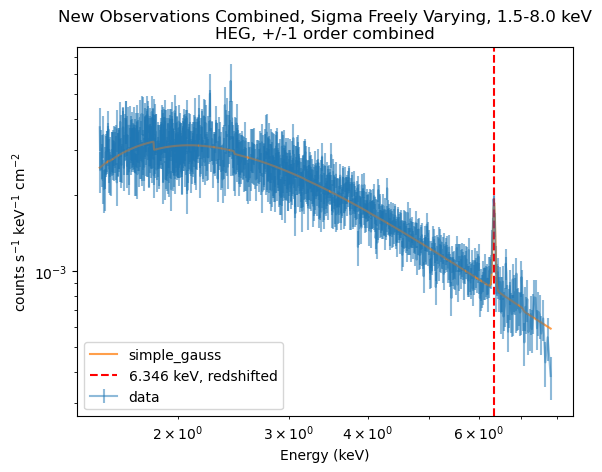

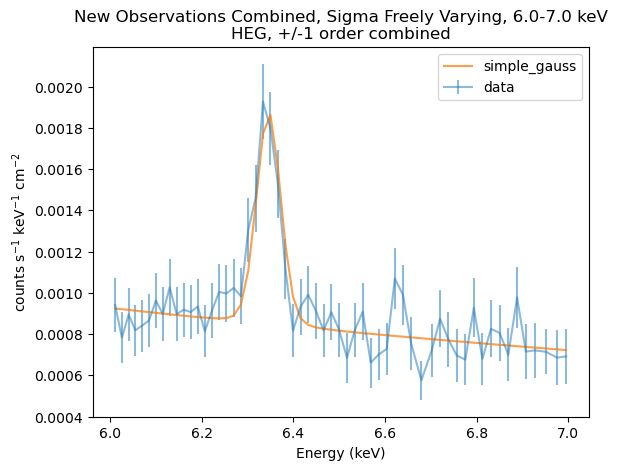

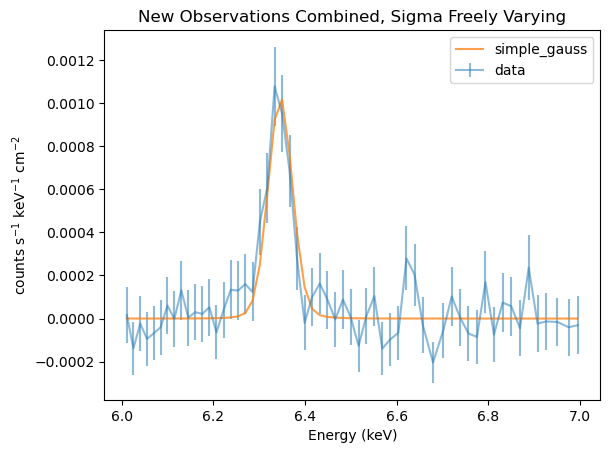

In [45]:
energy, counts, y_err, new_fit_sigma_vary, data_minus_continuum, new_gauss_sigma_vary, \
new_delchi_err_sigma_vary, flux, eqwidth, p, sigma, newobs_chisq_sigma_vary, \
newobs_dof_sigma_vary = analyze_spectra("simple_gauss", "New Observations Combined, \
Sigma Freely Varying", "1,3,5,8,10", find_eqwidth = True, plot_eqwidth=False)

In [46]:
p, sigma

(1.0, inf)

In [47]:
print_model_parameters(m, "sigma_vary", "new")

zphabs*(zpowerlw+cflux*zgauss), sigma freely varying
1st number is parameter value, 2nd is plus 1sigma error, 3rd is minus 1sigma error

nH (10^22 atoms cm^-2): 1.58, +0.06, -0.06
PhoIndex Γ (unitless): 1.70, +0.03, -0.03
Power law norm (10^-2 photons/keV/cm^2/s): 2.04, +0.10, -0.09
Gaussian sigma (eV): 22.1, +4.6, -4.1
Line Flux (10^-13 ergs cm^-2 s^-1): 7.27, +0.84, -0.81
Equivalent Width (eV): 81.9, +9.3, -8.2
chi_sq/dof: 655.3/981 = 0.6680


### Fitting two Gaussians with sigma allowed to vary

In [ ]:
m.zgauss.Sigma.frozen = False
m.zgauss_5.Sigma.frozen = False
m.show()

In [ ]:
energy, counts, y_err, new_fit_two_sigma_vary, data_continuum, new_gauss_two_sigma_vary, \
    new_delchi_err_two_sigma_vary, flux, eqwidth, p, sigma, newobs_chisq_two_sigma_vary, \
    newobs_dof_two_sigma_vary = analyze_spectra("two_simple_gauss", \
    "2020\nBoth Sigmas Freely Varying", "1,3,5,8,10,14", \
    fit_errors=False, return_indiv_comp=True, find_eqwidth = True)

In [ ]:
p, sigma

In [ ]:
print_model_parameters(m, "sigma_vary", "new", True, m.zgauss_5)

### Doing F-test to see significance value of thawing sigma actually makes a difference in the fit.

In [ ]:
newobs_dof_sigma_vary, newobs_dof_sigma_fixed # Looks right

In [ ]:
newobs_p_ftest_thawing_sigma = Fit.ftest(newobs_chisq_sigma_vary, newobs_dof_sigma_vary, newobs_chisq_sigma_fixed, newobs_dof_sigma_fixed)

In [ ]:
pvalue_to_sigma(newobs_p_ftest_thawing_sigma)

### xillver

In [ ]:
m_xillver = Model("zphabs*(zpowerlw+cflux*atable{xillver-a-Ec5.fits})","xillver")
m_xillver.zphabs.Redshift = 0.00849
m_xillver.zpowerlw.Redshift = 0.00849
m_xillver.zpowerlw.PhoIndex.link = m_xillver.xillverEc.Gamma
m_xillver.cflux.Emin = 6.2
m_xillver.cflux.Emax = 6.45
#m_xillver.xillverEc.A_Fe.frozen = True
m_xillver.xillverEc.logXi = 0
m_xillver.xillverEc.logXi.frozen = True
m_xillver.xillverEc.Ecut.frozen = True
#m_xillver.xillverEc.Incl.frozen = True
m_xillver.xillverEc.z.link = m_xillver.zpowerlw.Redshift
m_xillver.xillverEc.norm.frozen = True

In [ ]:
m_xillver.show()

In [ ]:
energy, counts, y_err, new_fit_xillver, data_continuum, new_xillver, new_delchi_err_xillver, flux, eqwidth, p, sigma, \
newobs_chisq_xillver, newobs_dof_xillver = analyze_spectra("xillver", "New Observations Combined, \
xillver", "1,5,8,9,10,13", fit_errors=True, find_eqwidth = False, return_indiv_comp=True, plot_eqwidth=False)

In [ ]:
p, sigma

In [ ]:
print_model_parameters(m_xillver, "xillver", "new")

### F-test between xillver and Gaussian with sigma fixed

In [ ]:
newobs_dof_xillver, newobs_dof_sigma_fixed

In [ ]:
newobs_p_ftest_xillver_vs_sigma_fixed = Fit.ftest(newobs_chisq_xillver, newobs_dof_xillver, newobs_chisq_sigma_fixed, newobs_dof_sigma_fixed)

In [ ]:
pvalue_to_sigma(newobs_p_ftest_xillver_vs_sigma_fixed)

### F-test between xillver and Gaussian with free sigma

In [ ]:
newobs_dof_xillver, newobs_dof_sigma_vary

In [ ]:
newobs_p_ftest_xillver_vs_sigma_vary = Fit.ftest(newobs_chisq_xillver, newobs_dof_xillver, newobs_chisq_sigma_vary, newobs_dof_sigma_vary)

In [ ]:
pvalue_to_sigma(newobs_p_ftest_xillver_vs_sigma_vary)

### mytorus

In [34]:
m_mytorus = Model("zphabs(zpowerlw + cflux*atable{mytl_V000010nEp000H500_v00.fits})","mytorus")

components = [m_mytorus.zphabs, m_mytorus.zpowerlw]
for component in components:
    component.Redshift = 0.00849

components_2 = [m_mytorus.MYTorusL]
for component in components_2:
    component.z = 0.00849

m_mytorus.zpowerlw.PhoIndex = 1.9
m_mytorus.MYTorusL.PhoIndx.link = m_mytorus.zpowerlw.PhoIndex
m_mytorus.MYTorusL.NH.link = m_mytorus.zphabs.nH
m_mytorus.MYTorusL.IncAng = 60
m_mytorus.MYTorusL.norm.frozen = True
m_mytorus.cflux.Emin = 6.2
m_mytorus.cflux.Emax = 6.45


Previous model: rdblur_mytorus for source #: 1 has been rendered inactive.

Model mytorus:zphabs<1>(zpowerlw<2> + cflux<3>*atable{mytl_V000010nEp000H500_v00.fits}<4>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   zphabs     nH         10^22    1.00000      +/-  0.0          
   2    1   zphabs     Redshift            0.0          frozen
   3    2   zpowerlw   PhoIndex            1.00000      +/-  0.0          
   4    2   zpowerlw   Redshift            0.0          frozen
   5    2   zpowerlw   norm                1.00000      +/-  0.0          
   6    3   cflux      Emin       keV      0.500000     frozen
   7    3   cflux      Emax       keV      10.0000      frozen
   8    3   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   9    4   MYTorusL   NH         10^24    0.100000     +/-  0.0          
  10    4   MYTorusL   IncAng     Degrees  90.0000      frozen
  11    4   MYTorusL   PhoIndx             1.90000      

In [35]:
m_mytorus.show()


Model mytorus:zphabs<1>(zpowerlw<2> + cflux<3>*atable{mytl_V000010nEp000H500_v00.fits}<4>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   zphabs     nH         10^22    1.00000      +/-  0.0          
   2    1   zphabs     Redshift            8.49000E-03  frozen
   3    2   zpowerlw   PhoIndex            1.90000      +/-  0.0          
   4    2   zpowerlw   Redshift            8.49000E-03  frozen
   5    2   zpowerlw   norm                1.00000      +/-  0.0          
   6    3   cflux      Emin       keV      6.20000      frozen
   7    3   cflux      Emax       keV      6.45000      frozen
   8    3   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   9    4   MYTorusL   NH         10^24    1.00000      = mytorus:p1
  10    4   MYTorusL   IncAng     Degrees  60.0000      frozen
  11    4   MYTorusL   PhoIndx             1.90000      = mytorus:p3
  12    4   MYTorusL   z                   8.49000E-03  frozen
  13  


Fit statistic  : Chi-Squared                 2455.18     using 986 bins.

Test statistic : Chi-Squared                 2455.18     using 986 bins.
 Null hypothesis probability of 3.85e-127 with 982 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
Chi-Squared  |beta|/N    Lvl  mytorus:1:nH mytorus:3:Pho mytorus:5:nor mytorus:8:lg1
681.671      1013.5       -3       1.36443       1.60550     0.0174140      -12.1625
670.655      2199.65      -4       1.57578       1.69996     0.0202007      -12.2069
665.264      5803.21      -5       1.58070       1.70170     0.0204945      -12.2099
665.264      19.7039      -6       1.58071       1.70170     0.0204953      -12.2100
 Variances and Principal Axes
         mytorus:1mytorus:3mytorus:5mytorus:8  
 1.0039E-08| -0.0038  -0.0252   0.9997   0.0002  
 1.1719E-04|  0.4172  -0.9082  -0.0213   0.0259  
 1.9675E-03|  0.1512   0.0412   0.0018  -0.9876  
 4.3027E-03|  0.8962   0.4157   0.0139   0.154

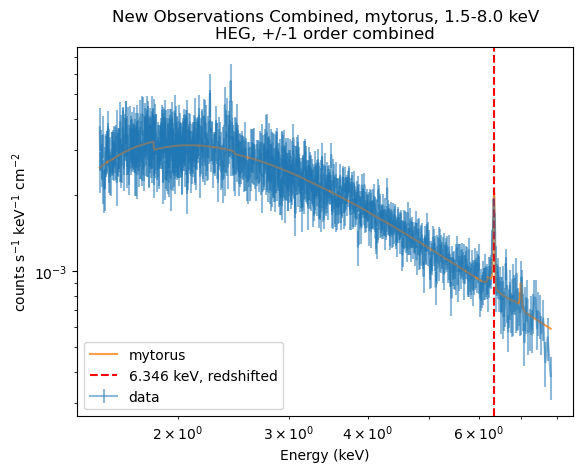

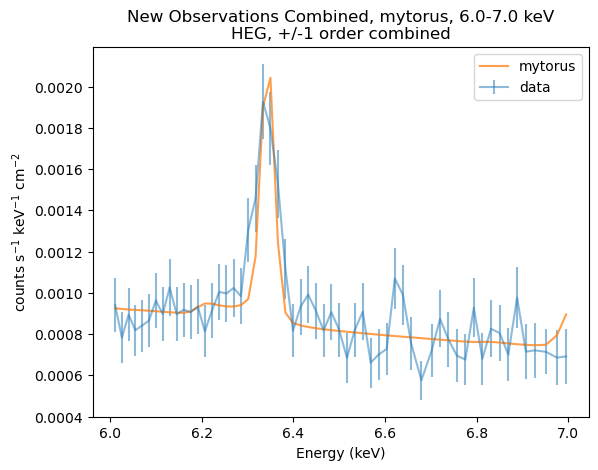

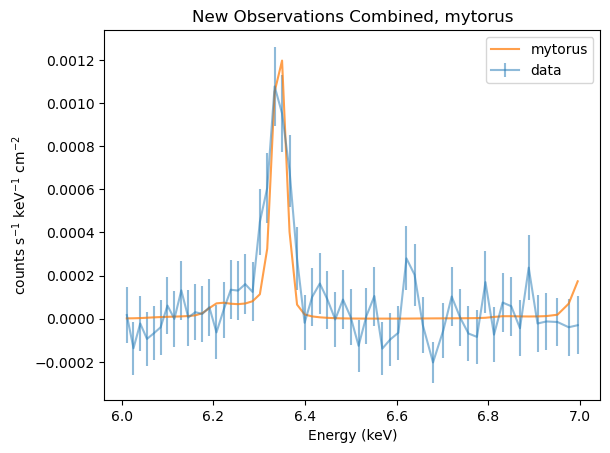

In [36]:
energy, counts, y_err, new_fit_mytorus, data_continuum, new_mytorus, new_delchi_err_mytorus, flux, eqwidth, p, sigma, \
newobs_chisq_mytorus, newobs_dof_mytorus = analyze_spectra("mytorus", "New Observations Combined, \
mytorus", "1,3,5,8", fit_errors=True, find_eqwidth = True, return_indiv_comp=True, plot_eqwidth=False)

In [37]:
p, sigma

(0.9999999999999997, 8.076571004130123)

In [38]:
print_model_parameters(m_mytorus, "mytorus", "new")

1st number is parameter value, 2nd is plus 1sigma error, 3rd is minus 1sigma error

nH (10^22 atoms cm^-2): 1.58, +0.06, -0.06
PhoIndex Γ (unitless): 1.70, +0.03, -0.03
Power law norm (10^-2 photons/keV/cm^2/s): 2.05, +0.10, -0.09
Line Flux (10^-13 ergs cm^-2 s^-1): 6.17, +0.65, -0.65
Equivalent Width (eV): 84.3, +10.0, -8.8
chi_sq/dof: 665.3/982 = 0.6775


### rdblur*mytorus

In [29]:
m_rdblur_mytorus = Model("zphabs(zpowerlw + cflux*rdblur*atable{mytl_V000010nEp000H500_v00.fits})","rdblur_mytorus")

components = [m_rdblur_mytorus.zphabs, m_rdblur_mytorus.zpowerlw]
for component in components:
    component.Redshift = 0.00849

components_2 = [m_rdblur_mytorus.MYTorusL]
for component in components_2:
    component.z = 0.00849

m_rdblur_mytorus.zpowerlw.PhoIndex = 1.71
m_rdblur_mytorus.MYTorusL.PhoIndx.link = m_rdblur_mytorus.zpowerlw.PhoIndex
m_rdblur_mytorus.MYTorusL.NH.link = m_rdblur_mytorus.zphabs.nH
m_rdblur_mytorus.MYTorusL.IncAng = 29
m_rdblur_mytorus.MYTorusL.IncAng.frozen = False
m_rdblur_mytorus.MYTorusL.norm.frozen = True
m_rdblur_mytorus.cflux.Emin = 6.2
m_rdblur_mytorus.cflux.Emax = 6.45
m_rdblur_mytorus.rdblur.Betor10 = "-2.71,,-4.0,-4.0,-2.0,-2.0"
m_rdblur_mytorus.rdblur.Betor10.frozen = False
m_rdblur_mytorus.rdblur.Rin_M = 6419
m_rdblur_mytorus.rdblur.Rin_M.frozen = False
m_rdblur_mytorus.rdblur.Rout_M = 1e6
m_rdblur_mytorus.rdblur.Incl.link = m_rdblur_mytorus.MYTorusL.IncAng


Model rdblur_mytorus:zphabs<1>(zpowerlw<2> + cflux<3>*rdblur<4>*atable{mytl_V000010nEp000H500_v00.fits}<5>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   zphabs     nH         10^22    1.00000      +/-  0.0          
   2    1   zphabs     Redshift            0.0          frozen
   3    2   zpowerlw   PhoIndex            1.00000      +/-  0.0          
   4    2   zpowerlw   Redshift            0.0          frozen
   5    2   zpowerlw   norm                1.00000      +/-  0.0          
   6    3   cflux      Emin       keV      0.500000     frozen
   7    3   cflux      Emax       keV      10.0000      frozen
   8    3   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   9    4   rdblur     Betor10             -2.00000     frozen
  10    4   rdblur     Rin_M               10.0000      frozen
  11    4   rdblur     Rout_M              1000.00      frozen
  12    4   rdblur     Incl       deg      30.0000      +/-  0.0

In [30]:
m_rdblur_mytorus.show()


Model rdblur_mytorus:zphabs<1>(zpowerlw<2> + cflux<3>*rdblur<4>*atable{mytl_V000010nEp000H500_v00.fits}<5>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   zphabs     nH         10^22    1.00000      +/-  0.0          
   2    1   zphabs     Redshift            8.49000E-03  frozen
   3    2   zpowerlw   PhoIndex            1.71000      +/-  0.0          
   4    2   zpowerlw   Redshift            8.49000E-03  frozen
   5    2   zpowerlw   norm                1.00000      +/-  0.0          
   6    3   cflux      Emin       keV      6.20000      frozen
   7    3   cflux      Emax       keV      6.45000      frozen
   8    3   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   9    4   rdblur     Betor10             -2.71000     +/-  0.0          
  10    4   rdblur     Rin_M               6419.00      +/-  0.0          
  11    4   rdblur     Rout_M              1.00000E+06  frozen
  12    4   rdblur     Incl       deg   


Fit statistic  : Chi-Squared                 1326.05     using 986 bins.

Test statistic : Chi-Squared                 1326.05     using 986 bins.
 Null hypothesis probability of 6.94e-13 with 979 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
Chi-Squared  |beta|/N    Lvl rdblur_mytoru rdblur_mytoru rdblur_mytoru rdblur_mytoru rdblur_mytoru rdblur_mytoru rdblur_mytoru
682.798      348.334      -3       1.47180       1.66557     0.0192832      -12.0927      -2.73021       336.344      0.765811
660.924      1590.59      -4       1.58732       1.70758     0.0206092      -12.1421      -2.12726       90.1337      0.659837
659.539      554.522      -5       1.59110       1.70889     0.0207024      -12.1509      -2.06332       93.7597      0.640406
659.192      27.2247      -6       1.59204       1.70952     0.0207209      -12.1478      -2.00614       95.2591      0.637429
659.192      0.937039      0       1.59204       1.70953     0.02

***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: Parameter pegged at hard limit: -4
***Warning: New best fit found, fit parameters will be set to new values.


p value: 1.0
Sigma level of confidence: inf
equivalent width: (0.1112518321, 0.1016908291, 0.151795848)


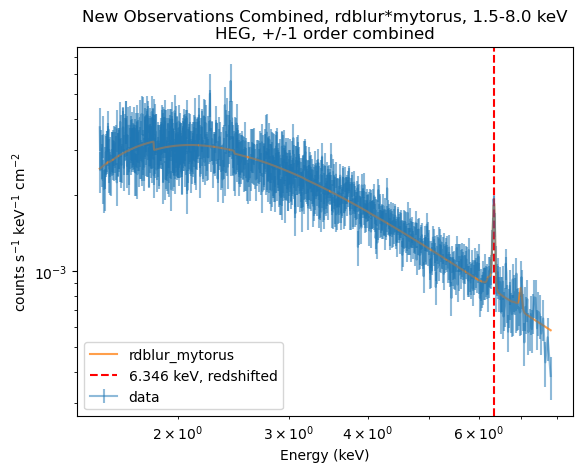

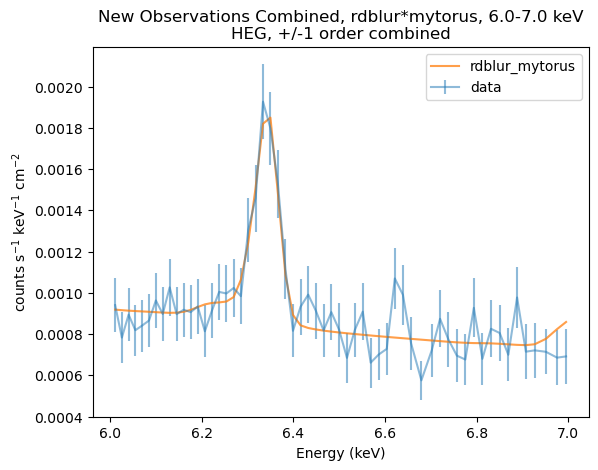

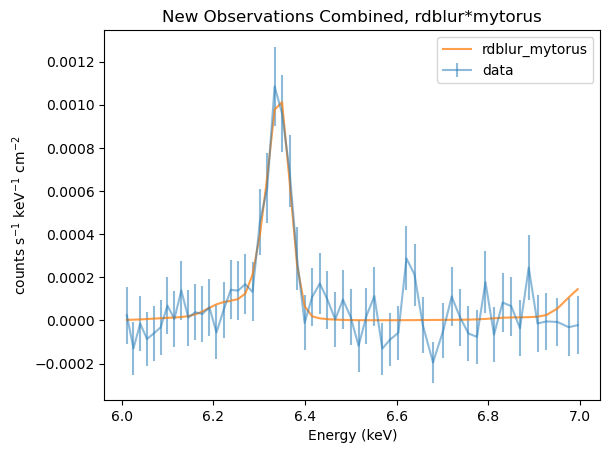

In [31]:
energy, counts, y_err, new_fit_rdblur_mytorus, data_continuum, new_rdblur_mytorus, new_delchi_err_rdblur_mytorus, flux, eqwidth, p, sigma, \
newobs_chisq_rdblur_mytorus, newobs_dof_rdblur_mytorus = analyze_spectra("rdblur_mytorus", "New Observations Combined, \
rdblur*mytorus", "1,3,5,8,9,10,14", fit_errors=True, find_eqwidth = True, return_indiv_comp=True, plot_eqwidth=False)

In [32]:
p, sigma

(1.0, inf)

In [33]:
print_model_parameters(m_rdblur_mytorus,"rdblur_mytorus","new")

1st number is parameter value, 2nd is plus 1sigma error, 3rd is minus 1sigma error

nH (10^22 atoms cm^-2): 1.62, +0.03, -0.03
PhoIndex Γ (unitless): 1.72, +0.02, -0.02
Power law norm (10^-2 photons/keV/cm^2/s): 2.12, +0.03, -0.12
Emissitivity index q (unitless): 2.49, +0.70, -0.36
Inner radius R_in (GM/c^2): 946, +-946, -621
Inclination (deg): 13.16, +8.69, -4.17
Line Flux (10^-13 ergs cm^-2 s^-1): 8.04, +0.82, -0.82
Equivalent Width (eV): 111.3, +40.5, -9.6
chi_sq/dof: 650.9/979 = 0.6649


### F-test between rdblur*mytorus and mytorus without rdblur's line broadening

In [48]:
#newobs_chisq_rdblur_mytorus, newobs_chisq_mytorus = 650.97, 665.26
#newobs_dof_rdblur_mytorus, newobs_dof_mytorus = 979, 982
newobs_dof_rdblur_mytorus, newobs_dof_mytorus

(979, 982)

In [49]:
newobs_p_ftest_rdblur_mytorus_vs_mytorus = Fit.ftest(newobs_chisq_rdblur_mytorus, newobs_dof_rdblur_mytorus, newobs_chisq_mytorus, newobs_dof_mytorus)

 F statistic value = 7.20151 and probability 8.77573e-05


In [50]:
pvalue_to_sigma(newobs_p_ftest_rdblur_mytorus_vs_mytorus)

3.75187843763565

### F-test between rdblur*mytorus and Gaussian with free sigma

In [51]:
newobs_dof_rdblur_mytorus, newobs_dof_sigma_vary

(979, 981)

In [52]:
newobs_p_ftest_rdblur_mytorus_vs_sigma_vary = Fit.ftest(newobs_chisq_rdblur_mytorus, newobs_dof_rdblur_mytorus, newobs_chisq_sigma_vary, newobs_dof_sigma_vary)

 F statistic value = 3.32092 and probability 0.0365269


In [53]:
pvalue_to_sigma(newobs_p_ftest_rdblur_mytorus_vs_sigma_vary)

1.7924943031592817

### Fitting Gaussian convolved by rdblur with q fixed at -3

In [ ]:
m_rdblur = Model("zphabs*(zpowerlw+cflux*rdblur*zgauss)","rdblur")
components = [m_rdblur.zphabs, m_rdblur.zpowerlw, m_rdblur.zgauss]

# Set the redshifts for each component
for component in components:
    component.Redshift = 0.00849

# List of value floats [val,delta,min,bot,top,max]. Note: Cannot set min and max for frozen parameters.
# Also, need to set the min equal to bot, and top equal to max when setting values this way
m_rdblur.zpowerlw.PhoIndex = 1.4
m_rdblur.zgauss.LineE = 6.4
m_rdblur.zgauss.LineE.frozen = True
m_rdblur.zgauss.Sigma = 0
m_rdblur.zgauss.Sigma.frozen = True
m_rdblur.zgauss.norm.frozen = True
m_rdblur.cflux.Emin = 6.2
m_rdblur.cflux.Emax = 6.45
m_rdblur.rdblur.Betor10 = -3
m_rdblur.rdblur.Rin_M = 100
m_rdblur.rdblur.Rin_M.frozen = False
m_rdblur.rdblur.Rout_M = 1e06
m_rdblur.rdblur.Rout_M.frozen = True
m_rdblur.rdblur.Incl.values = 10
m_rdblur.rdblur.Incl.frozen = False

In [ ]:
m_rdblur.show()

In [ ]:
energy, counts, y_err, new_fit_rdblur_q_fixed, data_continuum, new_gauss_rdblur_q_fixed, new_delchi_err_rdblur_q_fixed, \
flux, eqwidth, p, sigma, newobs_chisq_rdblur_q_fixed, newobs_dof_rdblur_q_fixed \
= analyze_spectra("rdblur", "New Observations Combined, rdblurred", "1,3,5,8,10,12", fit_errors=True, \
                  find_eqwidth=True, return_indiv_comp=True)

In [ ]:
p, sigma

In [ ]:
print_model_parameters(m_rdblur, "rdblur_q_fixed", "new")

### Fitting Gaussian convolved by rdblur

In [ ]:
m_rdblur.rdblur.Betor10.frozen = False
m_rdblur.rdblur.Betor10 = "-2.5,,-4.0,-4.0,-2.0,-2.0"

In [ ]:
m_rdblur.show()

In [ ]:
energy, counts, y_err, new_fit_rdblur, data_minus_continuum, new_gauss_rdblur, \
new_delchi_err_rdblur, flux, eqwidth, p, sigma, newobs_chisq_rdblur, newobs_dof_rdblur = \
analyze_spectra("rdblur", "New Observations Combined, rdblurred", "1,3,5,8,9,10,12", find_eqwidth = \
                True, plot_eqwidth=False)

In [ ]:
p, sigma

In [ ]:
print_model_parameters(m_rdblur,"rdblur", "new")

### F-test between Gaussian w/ sigma varying and rdblur q fixed

In [ ]:
#newobs_dof_rdblur_q_fixed, newobs_dof_sigma_vary

In [ ]:
#newobs_p_ftest_addrdblur = Fit.ftest(newobs_chisq_rdblur_q_fixed, newobs_dof_rdblur_q_fixed, newobs_chisq_sigma_vary, newobs_dof_sigma_vary)
newobs_p_ftest_addrdblur = Fit.ftest(651.95, 980, 655.32, 981)

In [ ]:
pvalue_to_sigma(newobs_p_ftest_addrdblur)

### F-test between fixed q and free q

In [ ]:
newobs_dof_rdblur, newobs_dof_rdblur_q_fixed

In [ ]:
newobs_p_ftest_q_vary = Fit.ftest(newobs_chisq_rdblur, newobs_dof_rdblur, newobs_chisq_rdblur_q_fixed, newobs_dof_rdblur_q_fixed)

In [ ]:
pvalue_to_sigma(newobs_p_ftest_q_vary)

### F-test between Gaussian w/ sigma varying and Gaussian convolved by rdblur

In [ ]:
newobs_dof_rdblur, newobs_dof_sigma_vary

In [ ]:
newobs_p_ftest_addrdblur = Fit.ftest(newobs_chisq_rdblur, newobs_dof_rdblur, newobs_chisq_sigma_vary, newobs_dof_sigma_vary)

In [ ]:
pvalue_to_sigma(newobs_p_ftest_addrdblur)

### Quick Look Plots

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(20,5))
axs[0].errorbar(new_energy, new_counts, new_y_err, color="black", alpha=0.5)
axs[0].plot(new_energy, new_fit_sigma_fixed, alpha=0.75)
axs[0].set_title("Gaussian fit\nSigma Fixed to Zero")
axs[1].errorbar(new_energy, new_counts, new_y_err, color="black", alpha=0.5)
axs[1].plot(new_energy, new_fit_sigma_vary, alpha=0.75)
axs[1].set_title("Gaussian fit\nSigma freely varying")
axs[2].errorbar(new_energy, new_counts, new_y_err, color="black", alpha=0.5)
axs[2].plot(new_energy, new_fit_xillver, alpha=0.75)
axs[2].set_title("xillver")
axs[3].errorbar(new_energy, new_counts, new_y_err, color="black", alpha=0.5)
axs[3].plot(new_energy, new_fit_rdblur_q_fixed, alpha=0.75)
axs[3].set_title("Gaussian convolved w/ rdblur")
fig.supylabel("Counts/sec/keV")
fig.supxlabel("Energy (keV)")
fig.suptitle("2020 Flux Observations")
plt.savefig("newobs_with_xillver.png")

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(20,5))
axs[0].errorbar(new_energy, new_data_minus_continuum, new_y_err, color="black", alpha=0.5)
axs[0].plot(new_energy, new_gauss_sigma_fixed, alpha=0.75)
axs[0].set_title("Gaussian fit\nSigma Fixed to Zero")
axs[1].errorbar(new_energy, new_data_minus_continuum, new_y_err, color="black", alpha=0.5)
axs[1].plot(new_energy, new_gauss_sigma_vary, alpha=0.75)
axs[1].set_title("Gaussian fit\nSigma freely varying")
axs[2].errorbar(new_energy, new_data_minus_continuum, new_y_err, color="black", alpha=0.5)
axs[2].plot(new_energy, new_xillver, alpha=0.75)
axs[2].set_title("xillver")
axs[3].errorbar(new_energy, new_data_minus_continuum, new_y_err, color="black", alpha=0.5)
axs[3].plot(new_energy, new_gauss_rdblur_q_fixed, alpha=0.75)
axs[3].set_title("Gaussian convolved w/ rdblur")
fig.supylabel("Counts/sec/keV/cm^2")
fig.supxlabel("Energy (keV)")
fig.suptitle("2020 Flux Observations with Continuum Subtracted")
plt.savefig("newobs_continuum_subtracted_with_xillver.png")

# Total Observations

### Load in observation

In [57]:
AllData.clear()
AllModels.clear()
s = Spectrum("allobs_grouped.pha")
AllData.ignore("bad")
s.ignore("**-1.5,8.0-**")


1 spectrum  in use
 
Spectral Data File: allobs_grouped.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.285e-01 +/- 1.236e-03 (99.2 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-1547
  Telescope: CHANDRA Instrument: ACIS  Channel Type: PI
  Exposure Time: 3.351e+05 sec
 Using fit statistic: chi
 Using Background File                allobs_comb_bkg.pha
  Background Exposure Time: 3.351e+05 sec
 Using Response (RMF) File            allobs_comb.rmf for Source 1
 Using Auxiliary Response (ARF) File  allobs_comb.arf


ignore:   216 channels ignored from  source number 1
    83 channels (1-83) ignored in spectrum #     1
   217 channels (1331-1547) ignored in spectrum #     1



### Fitting Gaussian with sigma fixed to 0 keV to see if Gaussian is due to instrumental broadening.

In [58]:
m = Model("zphabs*(zpowerlw+cflux*zgauss)","simple_gauss")
components = [m.zphabs, m.zpowerlw, m.zgauss]

# Set the redshifts for each component
for component in components:
    component.Redshift = 0.00849

# List of value floats [val,delta,min,bot,top,max]. Note: Cannot set min and max for frozen parameters.
# Also, need to set the min equal to bot, and top equal to max when setting values this way
m.zpowerlw.PhoIndex = 1.4
m.cflux.Emin = 6.2
m.cflux.Emax = 6.45
m.zgauss.LineE = 6.4
m.zgauss.LineE.frozen = True
m.zgauss.Sigma = 0
m.zgauss.Sigma.frozen = True
m.zgauss.norm.frozen = True


Model simple_gauss:zphabs<1>(zpowerlw<2> + cflux<3>*zgauss<4>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   zphabs     nH         10^22    1.00000      +/-  0.0          
   2    1   zphabs     Redshift            0.0          frozen
   3    2   zpowerlw   PhoIndex            1.00000      +/-  0.0          
   4    2   zpowerlw   Redshift            0.0          frozen
   5    2   zpowerlw   norm                1.00000      +/-  0.0          
   6    3   cflux      Emin       keV      0.500000     frozen
   7    3   cflux      Emax       keV      10.0000      frozen
   8    3   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   9    4   zgauss     LineE      keV      6.50000      +/-  0.0          
  10    4   zgauss     Sigma      keV      0.100000     +/-  0.0          
  11    4   zgauss     Redshift            0.0          frozen
  12    4   zgauss     norm                1.00000      +/-  0.0          
__________

In [59]:
m.show()


Model simple_gauss:zphabs<1>(zpowerlw<2> + cflux<3>*zgauss<4>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   zphabs     nH         10^22    1.00000      +/-  0.0          
   2    1   zphabs     Redshift            8.49000E-03  frozen
   3    2   zpowerlw   PhoIndex            1.40000      +/-  0.0          
   4    2   zpowerlw   Redshift            8.49000E-03  frozen
   5    2   zpowerlw   norm                1.00000      +/-  0.0          
   6    3   cflux      Emin       keV      6.20000      frozen
   7    3   cflux      Emax       keV      6.45000      frozen
   8    3   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   9    4   zgauss     LineE      keV      6.40000      frozen
  10    4   zgauss     Sigma      keV      0.0          frozen
  11    4   zgauss     Redshift            8.49000E-03  frozen
  12    4   zgauss     norm                1.00000      frozen
______________________________________________


Fit statistic  : Chi-Squared                 1263.82     using 1247 bins.

Test statistic : Chi-Squared                 1263.82     using 1247 bins.
 Null hypothesis probability of 3.34e-01 with 1243 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
Chi-Squared  |beta|/N    Lvl simple_gauss: simple_gauss: simple_gauss: simple_gauss:
1189.16      200.059      -3       1.45234       1.63227     0.0187558      -12.2051
957.333      51928.1      -4       1.52872       1.67114     0.0210124      -12.2741
955.393      4487.13      -5       1.52672       1.66997     0.0210808      -12.2813
955.392      7.20058      -6       1.52673       1.66998     0.0210809      -12.2814
 Variances and Principal Axes
         simple_gauss:1simple_gauss:3simple_gauss:5simple_gauss:8  
 5.8799E-09| -0.0042  -0.0254   0.9997   0.0001  
 6.1259E-05|  0.4275  -0.9037  -0.0212   0.0137  
 1.3719E-03|  0.1464   0.0542   0.0021  -0.9877  
 2.2049E-03|  0.8921   0

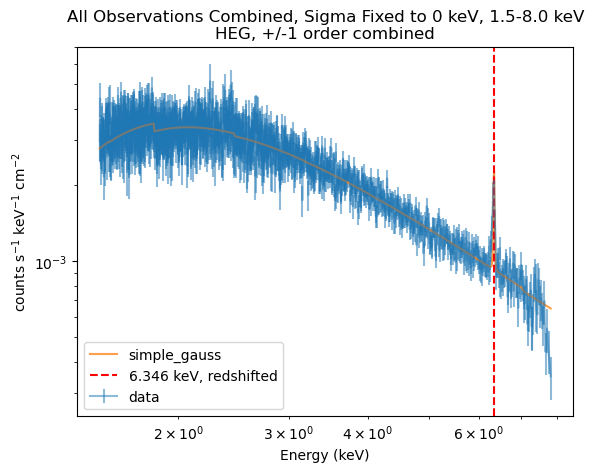

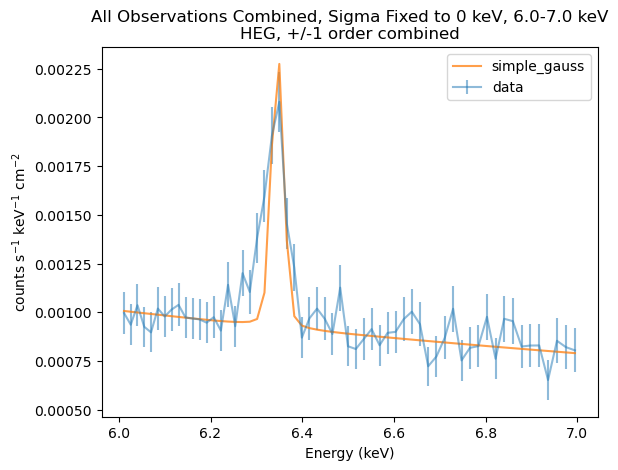

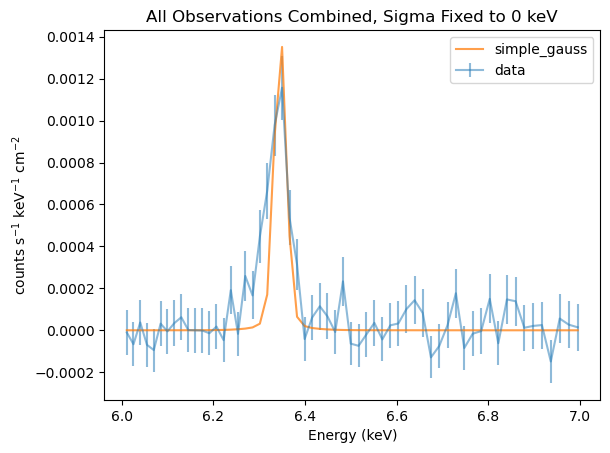

In [60]:
all_energy, all_counts, all_y_err, all_fit_sigma_fixed, all_data_minus_continuum, \
all_gauss_sigma_fixed, all_delchi_err_sigma_fixed, flux, eqwidth, p, sigma, allobs_chisq_sigma_fixed, \
allobs_dof_sigma_fixed = analyze_spectra("simple_gauss", "All Observations Combined, \
Sigma Fixed to 0 keV", "1,3,5,8", find_eqwidth=True, plot_eqwidth=False)

In [61]:
p, sigma

(0.9999999998210531, 6.271366224737164)

In [62]:
print_model_parameters(m, "sigma_fixed", "total")

zphabs*(zpowerlw+cflux*zgauss), sigma fixed to 0
1st number is parameter value, 2nd is plus 1sigma error, 3rd is minus 1sigma error

nH (10^22 atoms cm^-2): 1.53, +0.04, -0.04
PhoIndex Γ (unitless): 1.67, +0.02, -0.02
Power law norm (10^-2 photons/keV/cm^2/s): 2.11, +0.07, -0.07
Line Flux (10^-13 ergs cm^-2 s^-1): 5.23, +0.46, -0.45
Equivalent Width (eV): 54.1, +4.8, -4.6
chi_sq/dof: 955.4/1243 = 0.7686


### Fitting two Gaussians, both with sigma fixed to 0 keV, to account for Fe Ka1 and Fe Ka2

In [ ]:
# This is how you define multiple components of same type in Pyxspec: https://heasarc.gsfc.nasa.gov/xanadu/xspec/python/html/extended.html#:~:text=However%20when%20a,it%20more%20simply%3A
m = Model("zphabs*(zpowerlw+cflux(zgauss+zgauss))","two_simple_gauss")

components = [m.zphabs, m.zpowerlw, m.zgauss, m.zgauss_5]

# Set the redshifts for each component
for component in components:
    component.Redshift = 0.00849

# List of value floats [val,delta,min,bot,top,max]. Note: Cannot set min and max for frozen parameters.
# Also, need to set the min equal to bot, and top equal to max when setting values this way
m.zpowerlw.PhoIndex = 1.4
m.cflux.Emin = 6.2
m.cflux.Emax = 6.45
m.zgauss.LineE = 6.404
m.zgauss.LineE.frozen = True
m.zgauss.Sigma = 0
m.zgauss.Sigma.frozen = True
m.zgauss.norm.frozen = True

m.zgauss_5.LineE = 6.391
m.zgauss_5.LineE.frozen = True
m.zgauss_5.Sigma = 0
m.zgauss_5.Sigma.frozen = True
m.zgauss_5.norm.frozen = True

In [ ]:
m.show()

In [ ]:
all_energy, all_counts, all_y_err, all_fit_two_sigma_fixed, all_data_minus_continuum, all_gauss_two_sigma_fixed, \
all_delchi_err_two_sigma_fixed, flux, eqwidth, p, sigma, allobs_chisq_two_sigma_fixed, allobs_dof_two_sigma_fixed \
    = analyze_spectra("two_simple_gauss", "Total, Double Gaussians with Sigma Fixed to 0", "1,3,5,9,13", \
    fit_errors=False, plot_entire_range = True, find_eqwidth = True, return_indiv_comp = True, plot_eqwidth=True)

In [ ]:
p, sigma

In [ ]:
print_model_parameters(m, "sigma_fixed", "total", True, m.zgauss_5)

### Fitting two Gaussians with sigma allowed to vary

In [121]:
m.zgauss.Sigma.frozen = False
m.zgauss_5.Sigma.frozen = False
m.show()


Fit statistic  : Chi-Squared                  955.39     using 1247 bins.

Test statistic : Chi-Squared                  955.39     using 1247 bins.
 Null hypothesis probability of 1.00e+00 with 1242 degrees of freedom
 Current data and model not fit yet.


AttributeError: 'Model' object has no attribute 'zgauss_5'

In [ ]:
energy, counts, y_err, all_fit_two_sigma_vary, data_continuum, all_gauss_two_sigma_vary, \
    all_delchi_err_two_sigma_vary, flux, eqwidth, p, sigma, allobs_chisq_two_sigma_vary, \
    allobs_dof_two_sigma_vary = analyze_spectra("two_simple_gauss", \
    "Total\nBoth Sigmas Freely Varying", "1,3,5,8,10,14", \
    fit_errors=True, return_indiv_comp=True, find_eqwidth = True)

In [ ]:
p, sigma

In [ ]:
print_model_parameters(m, "sigma_vary", "total", True, m.zgauss_5)

### Fitting Gaussian with sigma freely varying

In [63]:
m.zgauss.Sigma.frozen = False
m.show()


Fit statistic  : Chi-Squared                  955.39     using 1247 bins.

Test statistic : Chi-Squared                  955.39     using 1247 bins.
 Null hypothesis probability of 1.00e+00 with 1242 degrees of freedom
 Current data and model not fit yet.

Model simple_gauss:zphabs<1>(zpowerlw<2> + cflux<3>*zgauss<4>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   zphabs     nH         10^22    1.52673      +/-  4.23708E-02  
   2    1   zphabs     Redshift            8.49000E-03  frozen
   3    2   zpowerlw   PhoIndex            1.66998      +/-  2.12250E-02  
   4    2   zpowerlw   Redshift            8.49000E-03  frozen
   5    2   zpowerlw   norm                2.10809E-02  +/-  7.09944E-04  
   6    3   cflux      Emin       keV      6.20000      frozen
   7    3   cflux      Emax       keV      6.45000      frozen
   8    3   cflux      lg10Flux   cgs      -12.2814     +/-  3.73068E-02  
   9    4   zgauss     LineE      keV    


Fit statistic  : Chi-Squared                  955.39     using 1247 bins.

Test statistic : Chi-Squared                  955.39     using 1247 bins.
 Null hypothesis probability of 1.00e+00 with 1242 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
Chi-Squared  |beta|/N    Lvl simple_gauss: simple_gauss: simple_gauss: simple_gauss: simple_gauss:
940.664      52.9817       0       1.52655       1.67010     0.0210795      -12.2550     0.0208076
932.383      133.539      -1       1.52540       1.67135     0.0210894      -12.1383     0.0208616
932.217      26.3906      -2       1.53195       1.67537     0.0212168      -12.1377     0.0213218
932.139      55.8772      -3       1.54166       1.68053     0.0213912      -12.1357     0.0215044
932.137      28.9414      -4       1.54321       1.68133     0.0214192      -12.1353     0.0215580
 Variances and Principal Axes
         simple_gauss:1simple_gauss:3simple_gauss:5simple_gauss:8simple_g

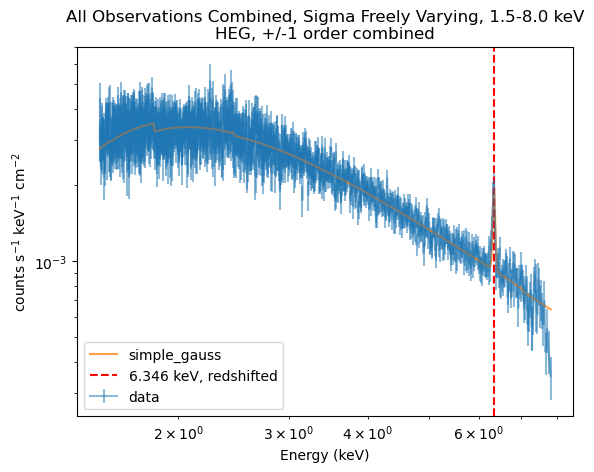

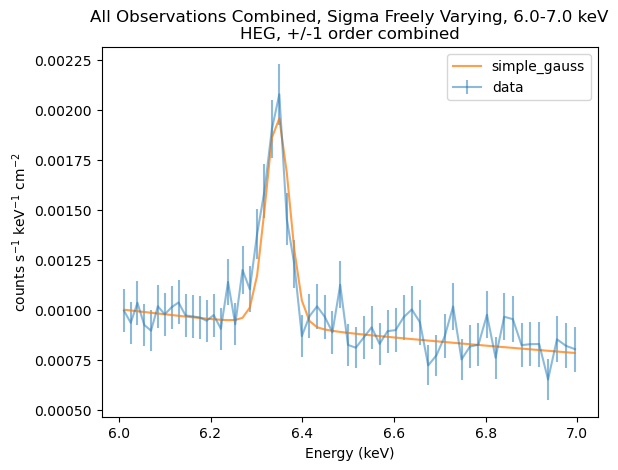

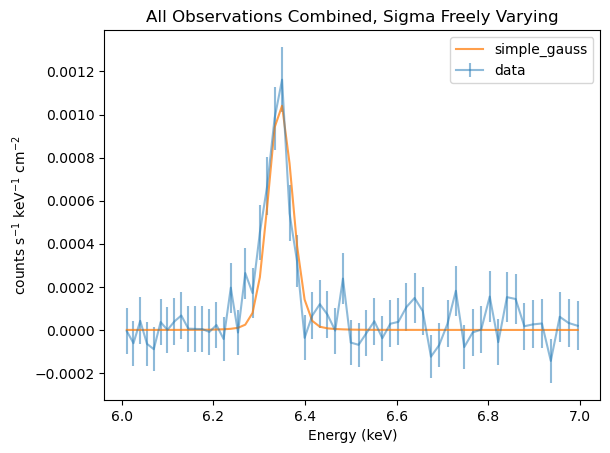

In [64]:
energy, counts, y_err, all_fit_sigma_vary, data_minus_continuum, all_gauss_sigma_vary, \
all_delchi_err_sigma_vary, flux, eqwidth, p, sigma, allobs_chisq_sigma_vary, allobs_dof_sigma_vary = \
analyze_spectra("simple_gauss", "All Observations Combined, Sigma Freely Varying", "1,3,5,8,10", \
               find_eqwidth=True, plot_eqwidth=False)

In [65]:
p, sigma

(0.9999999999951856, 6.811945746412872)

In [66]:
print_model_parameters(m, "sigma_vary", "total")

zphabs*(zpowerlw+cflux*zgauss), sigma freely varying
1st number is parameter value, 2nd is plus 1sigma error, 3rd is minus 1sigma error

nH (10^22 atoms cm^-2): 1.54, +0.04, -0.04
PhoIndex Γ (unitless): 1.68, +0.02, -0.02
Power law norm (10^-2 photons/keV/cm^2/s): 2.14, +0.07, -0.07
Gaussian sigma (eV): 21.6, +3.8, -3.5
Line Flux (10^-13 ergs cm^-2 s^-1): 7.32, +0.69, -0.67
Equivalent Width (eV): 76.1, +7.3, -6.8
chi_sq/dof: 932.1/1242 = 0.7505


### Doing F-test to see significance value of thawing sigma actually makes a difference in the fit.

In [ ]:
allobs_dof_sigma_vary, allobs_dof_sigma_fixed # Looks right

In [ ]:
allobs_p_ftest_thawing_sigma = Fit.ftest(allobs_chisq_sigma_vary, allobs_dof_sigma_vary, allobs_chisq_sigma_fixed, allobs_dof_sigma_fixed)

In [ ]:
pvalue_to_sigma(allobs_p_ftest_thawing_sigma)

### xillver

In [ ]:
m_xillver = Model("zphabs*(zpowerlw+cflux*atable{xillver-a-Ec5.fits})","xillver")
m_xillver.zphabs.Redshift = 0.00849
m_xillver.zpowerlw.Redshift = 0.00849
m_xillver.zpowerlw.PhoIndex.link = m_xillver.xillverEc.Gamma
m_xillver.cflux.Emin = 6.2
m_xillver.cflux.Emax = 6.45
#m_xillver.xillverEc.A_Fe.frozen = True
m_xillver.xillverEc.logXi = 0
m_xillver.xillverEc.logXi.frozen = True
m_xillver.xillverEc.Ecut.frozen = True
#m_xillver.xillverEc.Incl.frozen = True
m_xillver.xillverEc.z = 0.00849
m_xillver.xillverEc.norm.frozen = True

In [ ]:
m_xillver.show()

In [ ]:
energy, counts, y_err, all_fit_xillver, data_continuum, all_xillver, all_delchi_err_xillver, flux, eqwidth, p, sigma, \
allobs_chisq_xillver, allobs_dof_xillver = analyze_spectra("xillver", "All Observations Combined, \
xillver", "1,5,8,9,10,13", fit_errors=True, find_eqwidth = True, return_indiv_comp=True, plot_eqwidth=False)

In [ ]:
p, sigma

In [ ]:
print_model_parameters(m_xillver, "xillver", "total")

### F-test between xillver and Gaussian with sigma fixed

In [ ]:
allobs_dof_xillver, allobs_dof_sigma_fixed

In [ ]:
allobs_p_ftest_xillver_vs_sigma_fixed = Fit.ftest(allobs_chisq_xillver, allobs_dof_xillver, allobs_chisq_sigma_fixed, allobs_dof_sigma_fixed)

In [ ]:
pvalue_to_sigma(allobs_p_ftest_xillver_vs_sigma_fixed)

### F-test between xillver and Gaussian with free sigma

In [ ]:
allobs_dof_xillver, allobs_dof_sigma_vary

In [ ]:
allobs_p_ftest_xillver_vs_sigma_vary = Fit.ftest(allobs_chisq_xillver, allobs_dof_xillver, allobs_chisq_sigma_vary, allobs_dof_sigma_vary)

In [ ]:
pvalue_to_sigma(allobs_p_ftest_xillver_vs_sigma_vary)

### mytorus

In [126]:
m_mytorus = Model("zphabs(zpowerlw + cflux*atable{mytl_V000010nEp000H500_v00.fits})","mytorus")

components = [m_mytorus.zphabs, m_mytorus.zpowerlw]
for component in components:
    component.Redshift = 0.00849

components_2 = [m_mytorus.MYTorusL]
for component in components_2:
    component.z = 0.00849

m_mytorus.zpowerlw.PhoIndex = 1.9
m_mytorus.MYTorusL.PhoIndx.link = m_mytorus.zpowerlw.PhoIndex
m_mytorus.MYTorusL.NH.link = m_mytorus.zphabs.nH
m_mytorus.MYTorusL.IncAng = 60
m_mytorus.MYTorusL.norm.frozen = True
m_mytorus.cflux.Emin = 6.2
m_mytorus.cflux.Emax = 6.45


Previous model: simple_gauss for source #: 1 has been rendered inactive.

Model mytorus:zphabs<1>(zpowerlw<2> + cflux<3>*atable{mytl_V000010nEp000H500_v00.fits}<4>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   zphabs     nH         10^22    1.00000      +/-  0.0          
   2    1   zphabs     Redshift            0.0          frozen
   3    2   zpowerlw   PhoIndex            1.00000      +/-  0.0          
   4    2   zpowerlw   Redshift            0.0          frozen
   5    2   zpowerlw   norm                1.00000      +/-  0.0          
   6    3   cflux      Emin       keV      0.500000     frozen
   7    3   cflux      Emax       keV      10.0000      frozen
   8    3   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   9    4   MYTorusL   NH         10^24    0.100000     +/-  0.0          
  10    4   MYTorusL   IncAng     Degrees  90.0000      frozen
  11    4   MYTorusL   PhoIndx             1.90000      +/

In [127]:
m_mytorus.show()


Model mytorus:zphabs<1>(zpowerlw<2> + cflux<3>*atable{mytl_V000010nEp000H500_v00.fits}<4>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   zphabs     nH         10^22    1.00000      +/-  0.0          
   2    1   zphabs     Redshift            8.49000E-03  frozen
   3    2   zpowerlw   PhoIndex            1.90000      +/-  0.0          
   4    2   zpowerlw   Redshift            8.49000E-03  frozen
   5    2   zpowerlw   norm                1.00000      +/-  0.0          
   6    3   cflux      Emin       keV      6.20000      frozen
   7    3   cflux      Emax       keV      6.45000      frozen
   8    3   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   9    4   MYTorusL   NH         10^24    1.00000      = mytorus:p1
  10    4   MYTorusL   IncAng     Degrees  60.0000      frozen
  11    4   MYTorusL   PhoIndx             1.90000      = mytorus:p3
  12    4   MYTorusL   z                   8.49000E-03  frozen
  13  


Fit statistic  : Chi-Squared                 4343.96     using 1247 bins.

Test statistic : Chi-Squared                 4343.96     using 1247 bins.
 Null hypothesis probability of 0.00e+00 with 1243 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
Chi-Squared  |beta|/N    Lvl  mytorus:1:nH mytorus:3:Pho mytorus:5:nor mytorus:8:lg1
972.723      1901.73      -3       1.33418       1.58065     0.0180561      -12.1499
953.155      6957.88      -4       1.54406       1.68304     0.0211797      -12.1870
940.114      11542.4      -5       1.54840       1.68463     0.0215213      -12.1892
940.114      35.1278      -6       1.54842       1.68464     0.0215223      -12.1892
 Variances and Principal Axes
         mytorus:1mytorus:3mytorus:5mytorus:8  
 6.1443E-09| -0.0043  -0.0259   0.9997   0.0002  
 6.1545E-05|  0.4278  -0.9033  -0.0216   0.0236  
 1.2116E-03|  0.1867   0.0627   0.0026  -0.9804  
 2.2593E-03|  0.8844   0.4236   0.0148   0.1

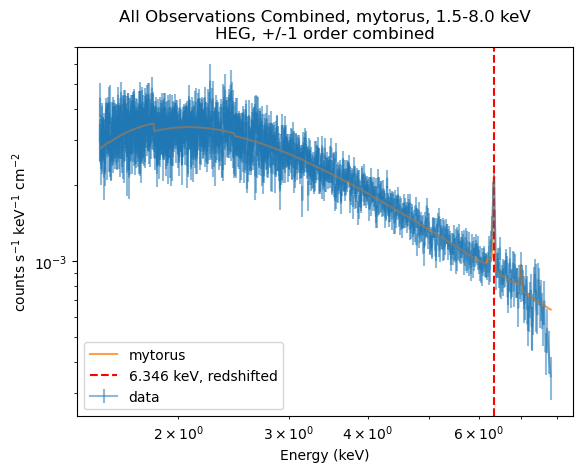

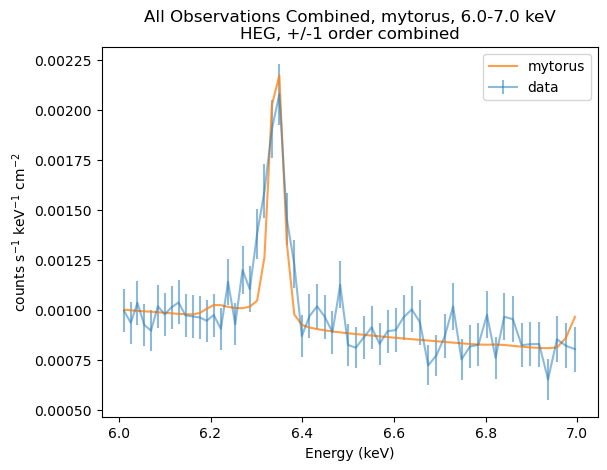

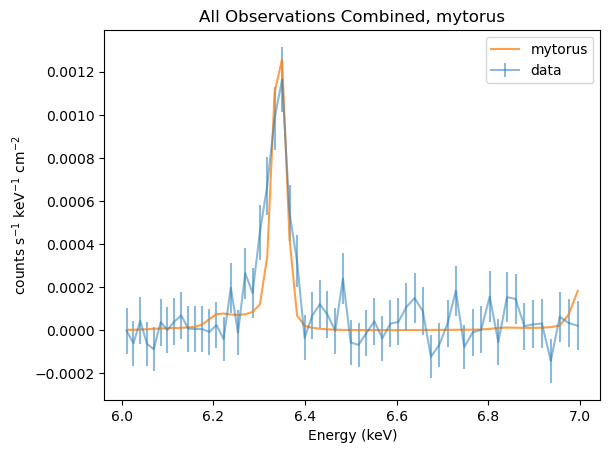

In [128]:
energy, counts, y_err, all_fit_mytorus, data_continuum, all_mytorus, all_delchi_err_mytorus, flux, eqwidth, p, sigma, \
allobs_chisq_mytorus, allobs_dof_mytorus = analyze_spectra("mytorus", "All Observations Combined, \
mytorus", "1,3,5,8", fit_errors=True, find_eqwidth = True, return_indiv_comp=True, plot_eqwidth=False)

In [129]:
p, sigma

(0.9999999999842384, 6.639273833849519)

In [130]:
print_model_parameters(m_mytorus, "mytorus", "total")

1st number is parameter value, 2nd is plus 1sigma error, 3rd is minus 1sigma error

nH (10^22 atoms cm^-2): 1.55, +0.04, -0.04
PhoIndex Γ (unitless): 1.68, +0.02, -0.02
Power law norm (10^-2 photons/keV/cm^2/s): 2.15, +0.07, -0.07
Line Flux (10^-13 ergs cm^-2 s^-1): 6.47, +0.53, -0.53
Equivalent Width (eV): 81.5, +7.1, -6.8
chi_sq/dof: 940.1/1243 = 0.7563


### rdblur*mytorus

In [67]:
m_rdblur_mytorus = Model("zphabs(zpowerlw + cflux*rdblur*atable{mytl_V000010nEp000H500_v00.fits})","rdblur_mytorus")

components = [m_rdblur_mytorus.zphabs, m_rdblur_mytorus.zpowerlw]
for component in components:
    component.Redshift = 0.00849

components_2 = [m_rdblur_mytorus.MYTorusL]
for component in components_2:
    component.z = 0.00849

m_rdblur_mytorus.zpowerlw.PhoIndex = 1.9
m_rdblur_mytorus.MYTorusL.PhoIndx.link = m_rdblur_mytorus.zpowerlw.PhoIndex
m_rdblur_mytorus.MYTorusL.NH.link = m_rdblur_mytorus.zphabs.nH
m_rdblur_mytorus.MYTorusL.IncAng = 60
m_rdblur_mytorus.MYTorusL.IncAng.frozen = False
m_rdblur_mytorus.MYTorusL.norm.frozen = True
m_rdblur_mytorus.cflux.Emin = 6.2
m_rdblur_mytorus.cflux.Emax = 6.45
m_rdblur_mytorus.rdblur.Betor10 = "-2.5,,-4.0,-4.0,-2.0,-2.0"
m_rdblur_mytorus.rdblur.Betor10.frozen = False
m_rdblur_mytorus.rdblur.Rin_M = 100
m_rdblur_mytorus.rdblur.Rin_M.frozen = False
m_rdblur_mytorus.rdblur.Rout_M = 1e6
m_rdblur_mytorus.rdblur.Incl.link = m_rdblur_mytorus.MYTorusL.IncAng


Previous model: simple_gauss for source #: 1 has been rendered inactive.

Model rdblur_mytorus:zphabs<1>(zpowerlw<2> + cflux<3>*rdblur<4>*atable{mytl_V000010nEp000H500_v00.fits}<5>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   zphabs     nH         10^22    1.00000      +/-  0.0          
   2    1   zphabs     Redshift            0.0          frozen
   3    2   zpowerlw   PhoIndex            1.00000      +/-  0.0          
   4    2   zpowerlw   Redshift            0.0          frozen
   5    2   zpowerlw   norm                1.00000      +/-  0.0          
   6    3   cflux      Emin       keV      0.500000     frozen
   7    3   cflux      Emax       keV      10.0000      frozen
   8    3   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   9    4   rdblur     Betor10             -2.00000     frozen
  10    4   rdblur     Rin_M               10.0000      frozen
  11    4   rdblur     Rout_M              1000.00   

In [68]:
m_rdblur_mytorus.show()


Model rdblur_mytorus:zphabs<1>(zpowerlw<2> + cflux<3>*rdblur<4>*atable{mytl_V000010nEp000H500_v00.fits}<5>) Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   zphabs     nH         10^22    1.00000      +/-  0.0          
   2    1   zphabs     Redshift            8.49000E-03  frozen
   3    2   zpowerlw   PhoIndex            1.90000      +/-  0.0          
   4    2   zpowerlw   Redshift            8.49000E-03  frozen
   5    2   zpowerlw   norm                1.00000      +/-  0.0          
   6    3   cflux      Emin       keV      6.20000      frozen
   7    3   cflux      Emax       keV      6.45000      frozen
   8    3   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   9    4   rdblur     Betor10             -2.50000     +/-  0.0          
  10    4   rdblur     Rin_M               100.000      +/-  0.0          
  11    4   rdblur     Rout_M              1.00000E+06  frozen
  12    4   rdblur     Incl       deg   


Fit statistic  : Chi-Squared                 4070.91     using 1247 bins.

Test statistic : Chi-Squared                 4070.91     using 1247 bins.
 Null hypothesis probability of 1.62e-297 with 1240 degrees of freedom
 Current data and model not fit yet.
                                   Parameters
Chi-Squared  |beta|/N    Lvl rdblur_mytoru rdblur_mytoru rdblur_mytoru rdblur_mytoru rdblur_mytoru rdblur_mytoru rdblur_mytoru
1029.91      1014.23      -3       1.36480       1.60136     0.0187544      -12.0454      -2.21069       35.9336       58.1407
955.519      4275.63      -4       1.58136       1.71143     0.0220010      -12.0415      -2.07268       20.6481      0.963851
932.2        6600.59      -5       1.56824       1.69862     0.0219456      -12.1113      -2.03454       18.7761       21.6060
927.63       477.266      -6       1.58857       1.71331     0.0223857      -12.0609      -2.01242       7.92151       22.7887
926.388      99.6326      -7       1.58930       1.71571     

***Warning: New best fit found, fit parameters will be set to new values.
***Warning: Parameter pegged at hard limit: -4
***Warning: Parameter pegged at hard limit: -2
***Warning: New best fit found, fit parameters will be set to new values.
***Warning: New best fit found, fit parameters will be set to new values.


   0.0000   0.0000   0.0000   0.0002  -1.0000  -0.0057  
--------------------------------------------------------------------------------

  Covariance Matrix
        1           2           3           4           5           6           7   
   1.854e-03   8.589e-04   3.066e-05   2.579e-04   2.678e-04  -8.319e-01   4.638e-03
   8.589e-04   4.753e-04   1.623e-05   1.734e-04   1.803e-04  -6.158e-01   2.843e-03
   3.066e-05   1.623e-05   5.667e-07   5.369e-06   5.580e-06  -1.842e-02   9.140e-05
   2.579e-04   1.734e-04   5.369e-06   1.383e-03   1.143e-03  -3.128e+00   2.470e-02
   2.678e-04   1.803e-04   5.580e-06   1.143e-03   9.738e-02  -8.418e+01   4.921e-01
  -8.319e-01  -6.158e-01  -1.842e-02  -3.128e+00  -8.418e+01   4.441e+05   2.534e+03
   4.638e-03   2.843e-03   9.140e-05   2.470e-02   4.921e-01   2.534e+03   3.131e+01
------------------------------------------------------------------------------------

Model rdblur_mytorus:zphabs<1>(zpowerlw<2> + cflux<3>*rdblur<4>*atable{mytl

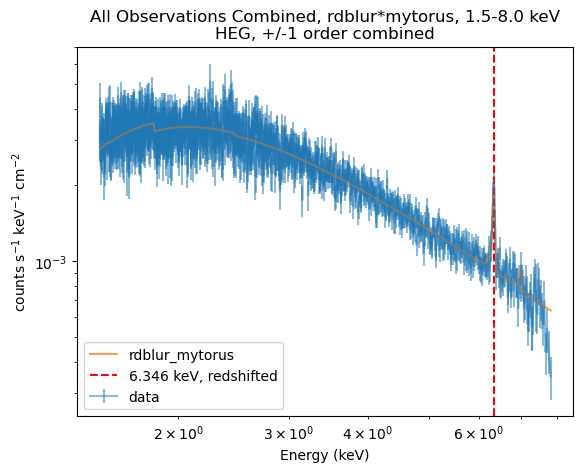

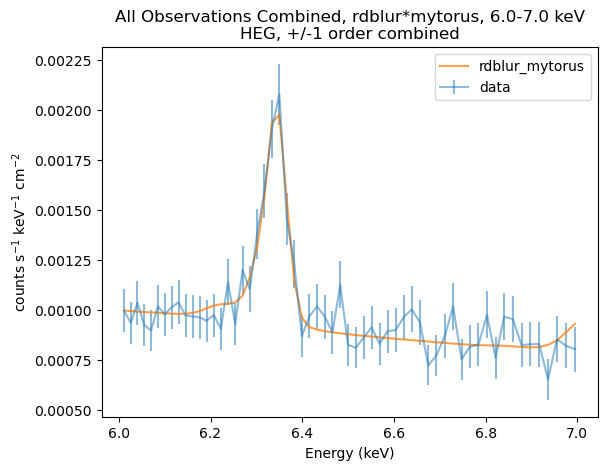

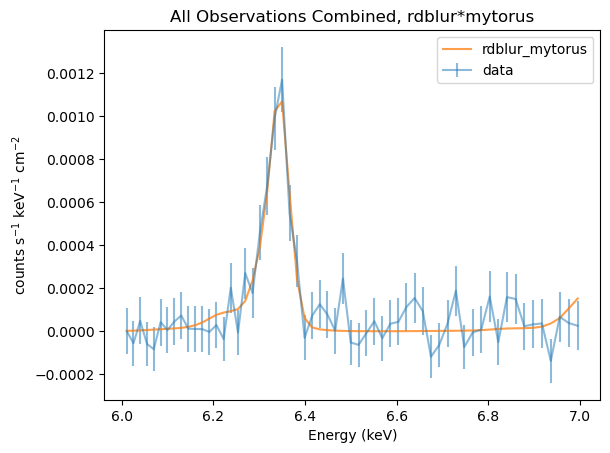

In [69]:
energy, counts, y_err, all_fit_rdblur_mytorus, data_continuum, all_rdblur_mytorus, all_delchi_err_rdblur_mytorus, flux, eqwidth, p, sigma, \
allobs_chisq_rdblur_mytorus, allobs_dof_rdblur_mytorus = analyze_spectra("rdblur_mytorus", "All Observations Combined, \
rdblur*mytorus", "1,3,5,8,9,10,14", fit_errors=True, find_eqwidth = True, return_indiv_comp=True, plot_eqwidth=False)

In [70]:
p, sigma

(0.9999999999990151, 7.036608155894722)

In [71]:
print_model_parameters(m_rdblur_mytorus,"rdblur_mytorus","total")

1st number is parameter value, 2nd is plus 1sigma error, 3rd is minus 1sigma error

nH (10^22 atoms cm^-2): 1.57, +0.04, -0.04
PhoIndex Γ (unitless): 1.70, +0.02, -0.02
Power law norm (10^-2 photons/keV/cm^2/s): 2.19, +0.08, -0.07
Emissitivity index q (unitless): 2.35, +0.48, -0.25
Inner radius R_in (GM/c^2): 638, +9291, -365
Inclination (deg): 11.97, +8.22, -3.65
Line Flux (10^-13 ergs cm^-2 s^-1): 8.21, +0.69, -0.69
Equivalent Width (eV): 104.5, +22.1, -9.5
chi_sq/dof: 921.2/1240 = 0.7429


### F-test between rdblur*mytorus and mytorus without rdblur's line broadening

In [75]:
#allobs_chisq_rdblur_mytorus, allobs_chisq_mytorus = 925.57, 940.11
#allobs_dof_rdblur_mytorus, allobs_dof_mytorus = 1240, 1243
allobs_chisq_mytorus, allobs_dof_mytorus = 940.11, 1243
allobs_dof_rdblur_mytorus, allobs_dof_mytorus

(1240, 1243)

In [76]:
allobs_p_ftest_rdblur_mytorus_vs_mytorus = Fit.ftest(allobs_chisq_rdblur_mytorus, allobs_dof_rdblur_mytorus, allobs_chisq_mytorus, allobs_dof_mytorus)

In [77]:
pvalue_to_sigma(allobs_p_ftest_rdblur_mytorus_vs_mytorus)

 F statistic value = 8.47394 and probability 1.41938e-05


4.186030217162189

### F-test between rdblur*mytorus and Gaussian with free sigma

In [72]:
allobs_dof_rdblur_mytorus, allobs_dof_sigma_vary

(1240, 1242)

In [73]:
allobs_p_ftest_rdblur_mytorus_vs_sigma_vary = Fit.ftest(allobs_chisq_rdblur_mytorus, allobs_dof_rdblur_mytorus, allobs_chisq_sigma_vary, allobs_dof_sigma_vary)

 F statistic value = 7.34481 and probability 0.000674427


In [74]:
pvalue_to_sigma(allobs_p_ftest_rdblur_mytorus_vs_sigma_vary)

3.2053776037466406

### rdblur*mytorus with q fixed to 3

In [ ]:
m_rdblur_mytorus = Model("zphabs(zpowerlw + cflux*rdblur*atable{mytl_V000010nEp000H500_v00.fits})","rdblur_mytorus")

components = [m_rdblur_mytorus.zphabs, m_rdblur_mytorus.zpowerlw]
for component in components:
    component.Redshift = 0.00849

components_2 = [m_rdblur_mytorus.MYTorusL]
for component in components_2:
    component.z = 0.00849

m_rdblur_mytorus.zpowerlw.PhoIndex = 1.9
m_rdblur_mytorus.MYTorusL.PhoIndx.link = m_rdblur_mytorus.zpowerlw.PhoIndex
m_rdblur_mytorus.MYTorusL.NH.link = m_rdblur_mytorus.zphabs.nH
m_rdblur_mytorus.MYTorusL.IncAng.frozen = False
m_rdblur_mytorus.MYTorusL.IncAng = 6.42
m_rdblur_mytorus.MYTorusL.norm.frozen = True
m_rdblur_mytorus.cflux.Emin = 6.2
m_rdblur_mytorus.cflux.Emax = 6.45
m_rdblur_mytorus.rdblur.Betor10 = -3
m_rdblur_mytorus.rdblur.Rin_M.frozen = False
m_rdblur_mytorus.rdblur.Rout_M = 1e6
m_rdblur_mytorus.rdblur.Incl.link = m_rdblur_mytorus.MYTorusL.IncAng

In [ ]:
m_rdblur_mytorus.show()

In [ ]:
energy, counts, y_err, all_fit_rdblur_mytorus, data_continuum, all_gauss_rdblur_mytorus, all_delchi_err_rdblur_mytorus, flux, eqwidth, p, sigma, \
allobs_chisq_rdblur_mytorus, allobs_dof_rdblur_mytorus = analyze_spectra("rdblur_mytorus", "All Observations Combined, \
rdblur*mytorus", "1,3,5,8,9,10,14", fit_errors=False, find_eqwidth = True, return_indiv_comp=True, plot_eqwidth=False)

In [ ]:
p, sigma

In [ ]:
print_model_parameters(m_rdblur_mytorus,"rdblur_mytorus","total")

### Fitting Gaussian convolved by rdblur with q fixed at -3

In [ ]:
m_rdblur = Model("zphabs*(zpowerlw+cflux*rdblur*zgauss)","rdblur")
components = [m_rdblur.zphabs, m_rdblur.zpowerlw, m_rdblur.zgauss]

# Set the redshifts for each component
for component in components:
    component.Redshift = 0.00849

# List of value floats [val,delta,min,bot,top,max]. Note: Cannot set min and max for frozen parameters.
# Also, need to set the min equal to bot, and top equal to max when setting values this way
m_rdblur.zpowerlw.PhoIndex = 1.4
m_rdblur.zgauss.LineE = 6.4
m_rdblur.zgauss.LineE.frozen = True
m_rdblur.zgauss.Sigma = 0
m_rdblur.zgauss.Sigma.frozen = True
m_rdblur.zgauss.norm.frozen = True
m_rdblur.cflux.Emin = 6.2
m_rdblur.cflux.Emax = 6.45
m_rdblur.rdblur.Betor10 = -3
m_rdblur.rdblur.Rin_M = 100
m_rdblur.rdblur.Rin_M.frozen = False
m_rdblur.rdblur.Rout_M = 1e06
m_rdblur.rdblur.Rout_M.frozen = True
m_rdblur.rdblur.Incl.values = 10
m_rdblur.rdblur.Incl.frozen = False

In [ ]:
m_rdblur.show()

In [ ]:
energy, counts, y_err, all_fit_rdblur_q_fixed, data_continuum, all_gauss_rdblur_q_fixed, all_delchi_err_rdblur_q_fixed, \
flux, eqwidth, p, sigma, allobs_chisq_rdblur_q_fixed, allobs_dof_rdblur_q_fixed \
= analyze_spectra("rdblur", "All Observations Combined, rdblurred", "1,3,5,8,10,12", fit_errors=True, \
                  find_eqwidth=True, return_indiv_comp=True)

In [ ]:
p, sigma

In [ ]:
print_model_parameters(m_rdblur, "rdblur_q_fixed", "total")

### Fitting Gaussian convolved with rdblur.

In [ ]:
m_rdblur.rdblur.Betor10.frozen = False
m_rdblur.rdblur.Betor10 = "-2.5,,-4.0,-4.0,-2.0,-2.0"

In [ ]:
m_rdblur.show()

In [ ]:
energy, counts, y_err, all_fit_rdblur, data_minus_continuum, all_gauss_rdblur, all_delchi_err_rdblur, \
flux, eqwidth, p, sigma, allobs_chisq_rdblur, allobs_dof_rdblur = analyze_spectra("rdblur", \
    "All Observations Combined, rdblurred", "1,3,5,8,9,10,12", fit_errors=True, find_eqwidth = True, \
                                                                                  plot_eqwidth=True, plot_entire_range=True)

In [ ]:
p, sigma

In [ ]:
print_model_parameters(m_rdblur, "rdblur", "total")

### F-test between Gaussian w/ sigma varying and rdblur q fixed

In [ ]:
#allobs_dof_rdblur_q_fixed, allobs_dof_sigma_vary

In [ ]:
#allobs_p_ftest_addrdblur = Fit.ftest(allobs_chisq_rdblur_q_fixed, allobs_dof_rdblur_q_fixed, allobs_chisq_sigma_vary, allobs_dof_sigma_vary)
allobs_p_ftest_addrdblur = Fit.ftest(924.21, 1241, 932.14, 1242)

In [ ]:
pvalue_to_sigma(allobs_p_ftest_addrdblur)

### F-test between fixed q and free q

In [ ]:
allobs_dof_rdblur, allobs_dof_rdblur_q_fixed

In [ ]:
allobs_p_ftest_q_vary = Fit.ftest(allobs_chisq_rdblur, allobs_dof_rdblur, allobs_chisq_rdblur_q_fixed, allobs_dof_rdblur_q_fixed)

In [ ]:
pvalue_to_sigma(allobs_p_ftest_q_vary)

### Doing F-test to see significance value of convolving with rdblur actually makes a difference in the fit.

In [ ]:
allobs_dof_rdblur, allobs_dof_sigma_vary # Looks right

In [ ]:
allobs_p_ftest_rdblur = Fit.ftest(allobs_chisq_rdblur, allobs_dof_rdblur, allobs_chisq_sigma_vary, allobs_dof_sigma_vary)

In [ ]:
pvalue_to_sigma(allobs_p_ftest_rdblur)

### Quick Look Plots

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(20,5))
axs[0].errorbar(all_energy, all_counts, all_y_err, color="black",alpha=0.5)
axs[0].plot(all_energy, all_fit_sigma_fixed,alpha=0.75)
axs[0].set_title("Gaussian fit\nSigma Fixed to Zero")
axs[1].errorbar(all_energy, all_counts, all_y_err, color="black",alpha=0.5)
axs[1].plot(all_energy, all_fit_sigma_vary,alpha=0.75)
axs[1].set_title("Gaussian fit\nSigma freely varying")
axs[2].errorbar(all_energy, all_counts, all_y_err, color="black",alpha=0.5)
axs[2].plot(all_energy, all_fit_xillver,alpha=0.75)
axs[2].set_title("xillver")
axs[3].errorbar(all_energy, all_counts, all_y_err, color="black",alpha=0.5)
axs[3].plot(all_energy, all_fit_rdblur_q_fixed,alpha=0.75)
axs[3].set_title("Gaussian convolved w/ rdblur")
fig.supylabel("Counts/sec/keV")
fig.supxlabel("Energy (keV)")
fig.suptitle("Total Observations")
plt.savefig("totalobs_with_xillver.png")

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(20,5))
axs[0].errorbar(all_energy, all_data_minus_continuum, all_y_err, color="black",alpha=0.5)
axs[0].plot(all_energy, all_gauss_sigma_fixed,alpha=0.75)
axs[0].set_title("Gaussian fit\nSigma Fixed to Zero")
axs[1].errorbar(all_energy, all_data_minus_continuum, all_y_err, color="black",alpha=0.5)
axs[1].plot(all_energy, all_gauss_sigma_vary,alpha=0.75)
axs[1].set_title("Gaussian fit\nSigma freely varying")
axs[2].errorbar(all_energy, all_data_minus_continuum, all_y_err, color="black",alpha=0.5)
axs[2].plot(all_energy, all_xillver,alpha=0.75)
axs[2].set_title("xillver")
axs[3].errorbar(all_energy, all_data_minus_continuum, all_y_err, color="black",alpha=0.5)
axs[3].plot(all_energy, all_gauss_rdblur_q_fixed,alpha=0.75)
axs[3].set_title("Gaussian convolved w/ rdblur")
fig.supylabel("Counts/sec/keV")
fig.supxlabel("Energy (keV)")
fig.suptitle("Total Observations with Continuum Subtracted")
plt.savefig("totalobs_continuum_subtracted_with_xillver.png")

# LaTeX format

In [ ]:
print_deluxetable()

In [ ]:
import matplotlib.ticker as tick

In [ ]:
fig, axs = plt.subplots(1,3, sharex=True, figsize=(30,5))

axs[0].errorbar(old_energy, old_data_minus_continuum, old_y_err, color="black", alpha=0.5)
axs[0].set_title("2000,2005",fontsize=20)
axs[0].set_ylabel("data - continuum",fontsize=15)
axs[0].axvline(6.48,linestyle="--",color="green",alpha=0.8)
axs[0].axvline(6.62,linestyle="--",color="green",alpha=0.8)
axs[0].axvline(6.68,linestyle="--",color="green",alpha=0.8)
axs[1].errorbar(new_energy, new_data_minus_continuum, new_y_err, color="black", alpha=0.5)
axs[1].set_title("2020",fontsize=20)
axs[1].axvline(6.48,linestyle="--",color="green",alpha=0.8)
axs[1].axvline(6.62,linestyle="--",color="green",alpha=0.8)
axs[1].axvline(6.68,linestyle="--",color="green",alpha=0.8)
axs[2].errorbar(all_energy, all_data_minus_continuum, all_y_err, color="black", alpha=0.5)
axs[2].set_title("Total",fontsize=20)
axs[2].axvline(6.48,linestyle="--",color="green",alpha=0.8)
axs[2].axvline(6.62,linestyle="--",color="green",alpha=0.8)
axs[2].axvline(6.68,linestyle="--",color="green",alpha=0.8)

fig.supylabel("counts s$^-1$ keV$^-1$ cm$^-2$",x=0.08,fontsize=15)

# Writing to CSV so I don't have to re-run the commands to get my data every time

In [78]:
import pandas as pd
data = {"old_energy": old_energy, 
        "old_counts": old_counts, 
        "old_y_err": old_y_err, 
        "old_data_minus_continuum": old_data_minus_continuum, 
        "old_gauss_sigma_fixed": old_gauss_sigma_fixed, 
        "old_delchi_err_sigma_fixed": old_delchi_err_sigma_fixed, 
        "old_gauss_sigma_vary": old_gauss_sigma_vary,
        "old_delchi_err_sigma_vary": old_delchi_err_sigma_vary,
        "old_xillver": old_xillver,
        "old_delchi_err_xillver": old_delchi_err_xillver,
        "old_rdblur_q_fixed": old_rdblur_q_fixed,
        "old_delchi_err_rdblur_q_fixed": old_delchi_err_rdblur_q_fixed,
        "old_rdblur": old_rdblur,
        "old_delchi_err_rdblur": old_delchi_err_rdblur,
        "old_mytorus": old_mytorus,
        "old_delchi_err_mytorus": old_delchi_err_mytorus,
        "old_rdblur_mytorus": old_rdblur_mytorus,
        "old_delchi_err_rdblur_mytorus": old_delchi_err_rdblur_mytorus,
        "new_energy": new_energy, 
        "new_counts": new_counts, 
        "new_y_err": new_y_err, 
        "new_data_minus_continuum": new_data_minus_continuum, 
        "new_gauss_sigma_fixed": new_gauss_sigma_fixed, 
        "new_delchi_err_sigma_fixed": new_delchi_err_sigma_fixed, 
        "new_gauss_sigma_vary": new_gauss_sigma_vary,
        "new_delchi_err_sigma_vary": new_delchi_err_sigma_vary,
        "new_xillver": new_xillver,
        "new_delchi_err_xillver": new_delchi_err_xillver,
        "new_rdblur_q_fixed": new_rdblur_q_fixed,
        "new_delchi_err_rdblur_q_fixed": new_delchi_err_rdblur_q_fixed,
        "new_rdblur": new_rdblur,
        "new_delchi_err_rdblur": new_delchi_err_rdblur,
        "new_mytorus": new_mytorus,
        "new_delchi_err_mytorus": new_delchi_err_mytorus,
        "new_rdblur_mytorus": new_rdblur_mytorus,
        "new_delchi_err_rdblur_mytorus": new_delchi_err_rdblur_mytorus,
        "all_energy": all_energy, 
        "all_counts": all_counts, 
        "all_y_err": all_y_err, 
        "all_data_minus_continuum": all_data_minus_continuum, 
        "all_gauss_sigma_fixed": all_gauss_sigma_fixed, 
        "all_delchi_err_sigma_fixed": all_delchi_err_sigma_fixed, 
        "all_gauss_sigma_vary": all_gauss_sigma_vary,
        "all_delchi_err_sigma_vary": all_delchi_err_sigma_vary,
        "all_xillver": all_xillver,
        "all_delchi_err_xillver": all_delchi_err_xillver,
        "all_rdblur_q_fixed": all_rdblur_q_fixed,
        "all_delchi_err_rdblur_q_fixed": all_delchi_err_rdblur_q_fixed,
        "all_rdblur": all_rdblur,
        "all_delchi_err_rdblur": all_delchi_err_rdblur,
        "all_mytorus": all_mytorus,
        "all_delchi_err_mytorus": all_delchi_err_mytorus,
        "all_rdblur_mytorus": all_rdblur_mytorus,
        "all_delchi_err_rdblur_mytorus": all_delchi_err_rdblur_mytorus,
       }
df = pd.concat([pd.DataFrame(value, columns=[key]) for key, value in data.items()], axis=1)
df.to_csv("./vary_rdblur_mytorus_best_spectral_data_by_time.csv")

In [1]:
import pandas as pd

df = pd.read_csv("spectral_fits.csv")

# View the first 5 rows
df.head()

,Unnamed: 0,old_energy,old_counts,old_y_err,old_data_minus_continuum,old_gauss_sigma_fixed,old_delchi_err_sigma_fixed,old_gauss_sigma_vary,old_delchi_err_sigma_vary,old_xillver,...,all_xillver,all_delchi_err_xillver,all_rdblur_q_fixed,all_delchi_err_rdblur_q_fixed,all_rdblur,all_delchi_err_rdblur,all_mytorus,all_delchi_err_mytorus,all_rdblur_mytorus,all_delchi_err_rdblur_mytorus
0,0,6.000464,0.000912,0.000161,-0.000242,8.447448e-08,1.0,1.090366e-07,1.0,0.000022,...,0.000023,1.0,1.301173e-07,1.0,1.387907e-07,1.0,0.000002,1.0,0.000003,1.0
1,1,6.022324,0.001200,0.000179,0.000053,9.727238e-08,1.0,1.262685e-07,1.0,0.000023,...,0.000024,1.0,1.439080e-07,1.0,1.537964e-07,1.0,0.000002,1.0,0.000003,1.0
2,2,6.040651,0.001323,0.000229,0.000181,1.101953e-07,1.0,1.432425e-07,1.0,0.000024,...,0.000025,1.0,1.600436e-07,1.0,1.714584e-07,1.0,0.000003,1.0,0.000005,1.0
3,3,6.055403,0.001142,0.000215,0.000004,1.226507e-07,1.0,1.596480e-07,1.0,0.000025,...,0.000026,1.0,1.791508e-07,1.0,1.925869e-07,1.0,0.000005,1.0,0.000006,1.0
4,4,6.073955,0.001060,0.000171,-0.000072,1.416453e-07,1.0,1.848096e-07,1.0,0.000026,...,0.000027,1.0,2.021330e-07,1.0,2.184788e-07,1.0,0.000006,1.0,0.000008,1.0


In [2]:
old_energy = df["old_energy"]
old_counts = df["old_counts"]
old_y_err = df['old_y_err']
old_data_minus_continuum = df['old_data_minus_continuum']
old_gauss_sigma_fixed = df['old_gauss_sigma_fixed']
old_delchi_err_sigma_fixed = df['old_delchi_err_sigma_fixed']
old_gauss_sigma_vary = df['old_gauss_sigma_vary']
old_delchi_err_sigma_vary = df['old_delchi_err_sigma_vary']
old_xillver = df['old_xillver']
old_delchi_err_xillver = df['old_delchi_err_xillver']
old_rdblur_q_fixed = df['old_rdblur_q_fixed']
old_delchi_err_rdblur_q_fixed = df['old_delchi_err_rdblur_q_fixed']
old_rdblur = df['old_rdblur']
old_delchi_err_rdblur = df['old_delchi_err_rdblur']
old_mytorus = df['old_mytorus']
old_delchi_err_mytorus = df['old_delchi_err_mytorus']
old_rdblur_mytorus = df['old_rdblur_mytorus']
old_delchi_err_rdblur_mytorus = df['old_delchi_err_rdblur_mytorus']
new_energy = df["new_energy"]
new_counts = df["new_counts"]
new_y_err = df['new_y_err']
new_data_minus_continuum = df['new_data_minus_continuum']
new_gauss_sigma_fixed = df['new_gauss_sigma_fixed']
new_delchi_err_sigma_fixed = df['new_delchi_err_sigma_fixed']
new_gauss_sigma_vary = df['new_gauss_sigma_vary']
new_delchi_err_sigma_vary = df['new_delchi_err_sigma_vary']
new_xillver = df['new_xillver']
new_delchi_err_xillver = df['new_delchi_err_xillver']
new_rdblur_q_fixed = df['new_rdblur_q_fixed']
new_delchi_err_rdblur_q_fixed = df['new_delchi_err_rdblur_q_fixed']
new_rdblur = df['new_rdblur']
new_delchi_err_rdblur = df['new_delchi_err_rdblur']
new_mytorus = df['new_mytorus']
new_delchi_err_mytorus = df['new_delchi_err_mytorus']
new_rdblur_mytorus = df['new_rdblur_mytorus']
new_delchi_err_rdblur_mytorus = df['new_delchi_err_rdblur_mytorus']
all_energy = df["all_energy"]
all_counts = df["all_counts"]
all_y_err = df['all_y_err']
all_data_minus_continuum = df['all_data_minus_continuum']
all_gauss_sigma_fixed = df['all_gauss_sigma_fixed']
all_delchi_err_sigma_fixed = df['all_delchi_err_sigma_fixed']
all_gauss_sigma_vary = df['all_gauss_sigma_vary']
all_delchi_err_sigma_vary = df['all_delchi_err_sigma_vary']
all_xillver = df['all_xillver']
all_delchi_err_xillver = df['all_delchi_err_xillver']
all_rdblur_q_fixed = df['all_rdblur_q_fixed']
all_delchi_err_rdblur_q_fixed = df['all_delchi_err_rdblur_q_fixed']
all_rdblur = df['all_rdblur']
all_delchi_err_rdblur = df['all_delchi_err_rdblur']
all_mytorus = df['all_mytorus']
all_delchi_err_mytorus = df['all_delchi_err_mytorus']
all_rdblur_mytorus = df['all_rdblur_mytorus']
all_delchi_err_rdblur_mytorus = df['all_delchi_err_rdblur_mytorus']

# Publication-ready figure

In [3]:
import matplotlib.ticker as tick
import matplotlib.pyplot as plt
import numpy as np

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


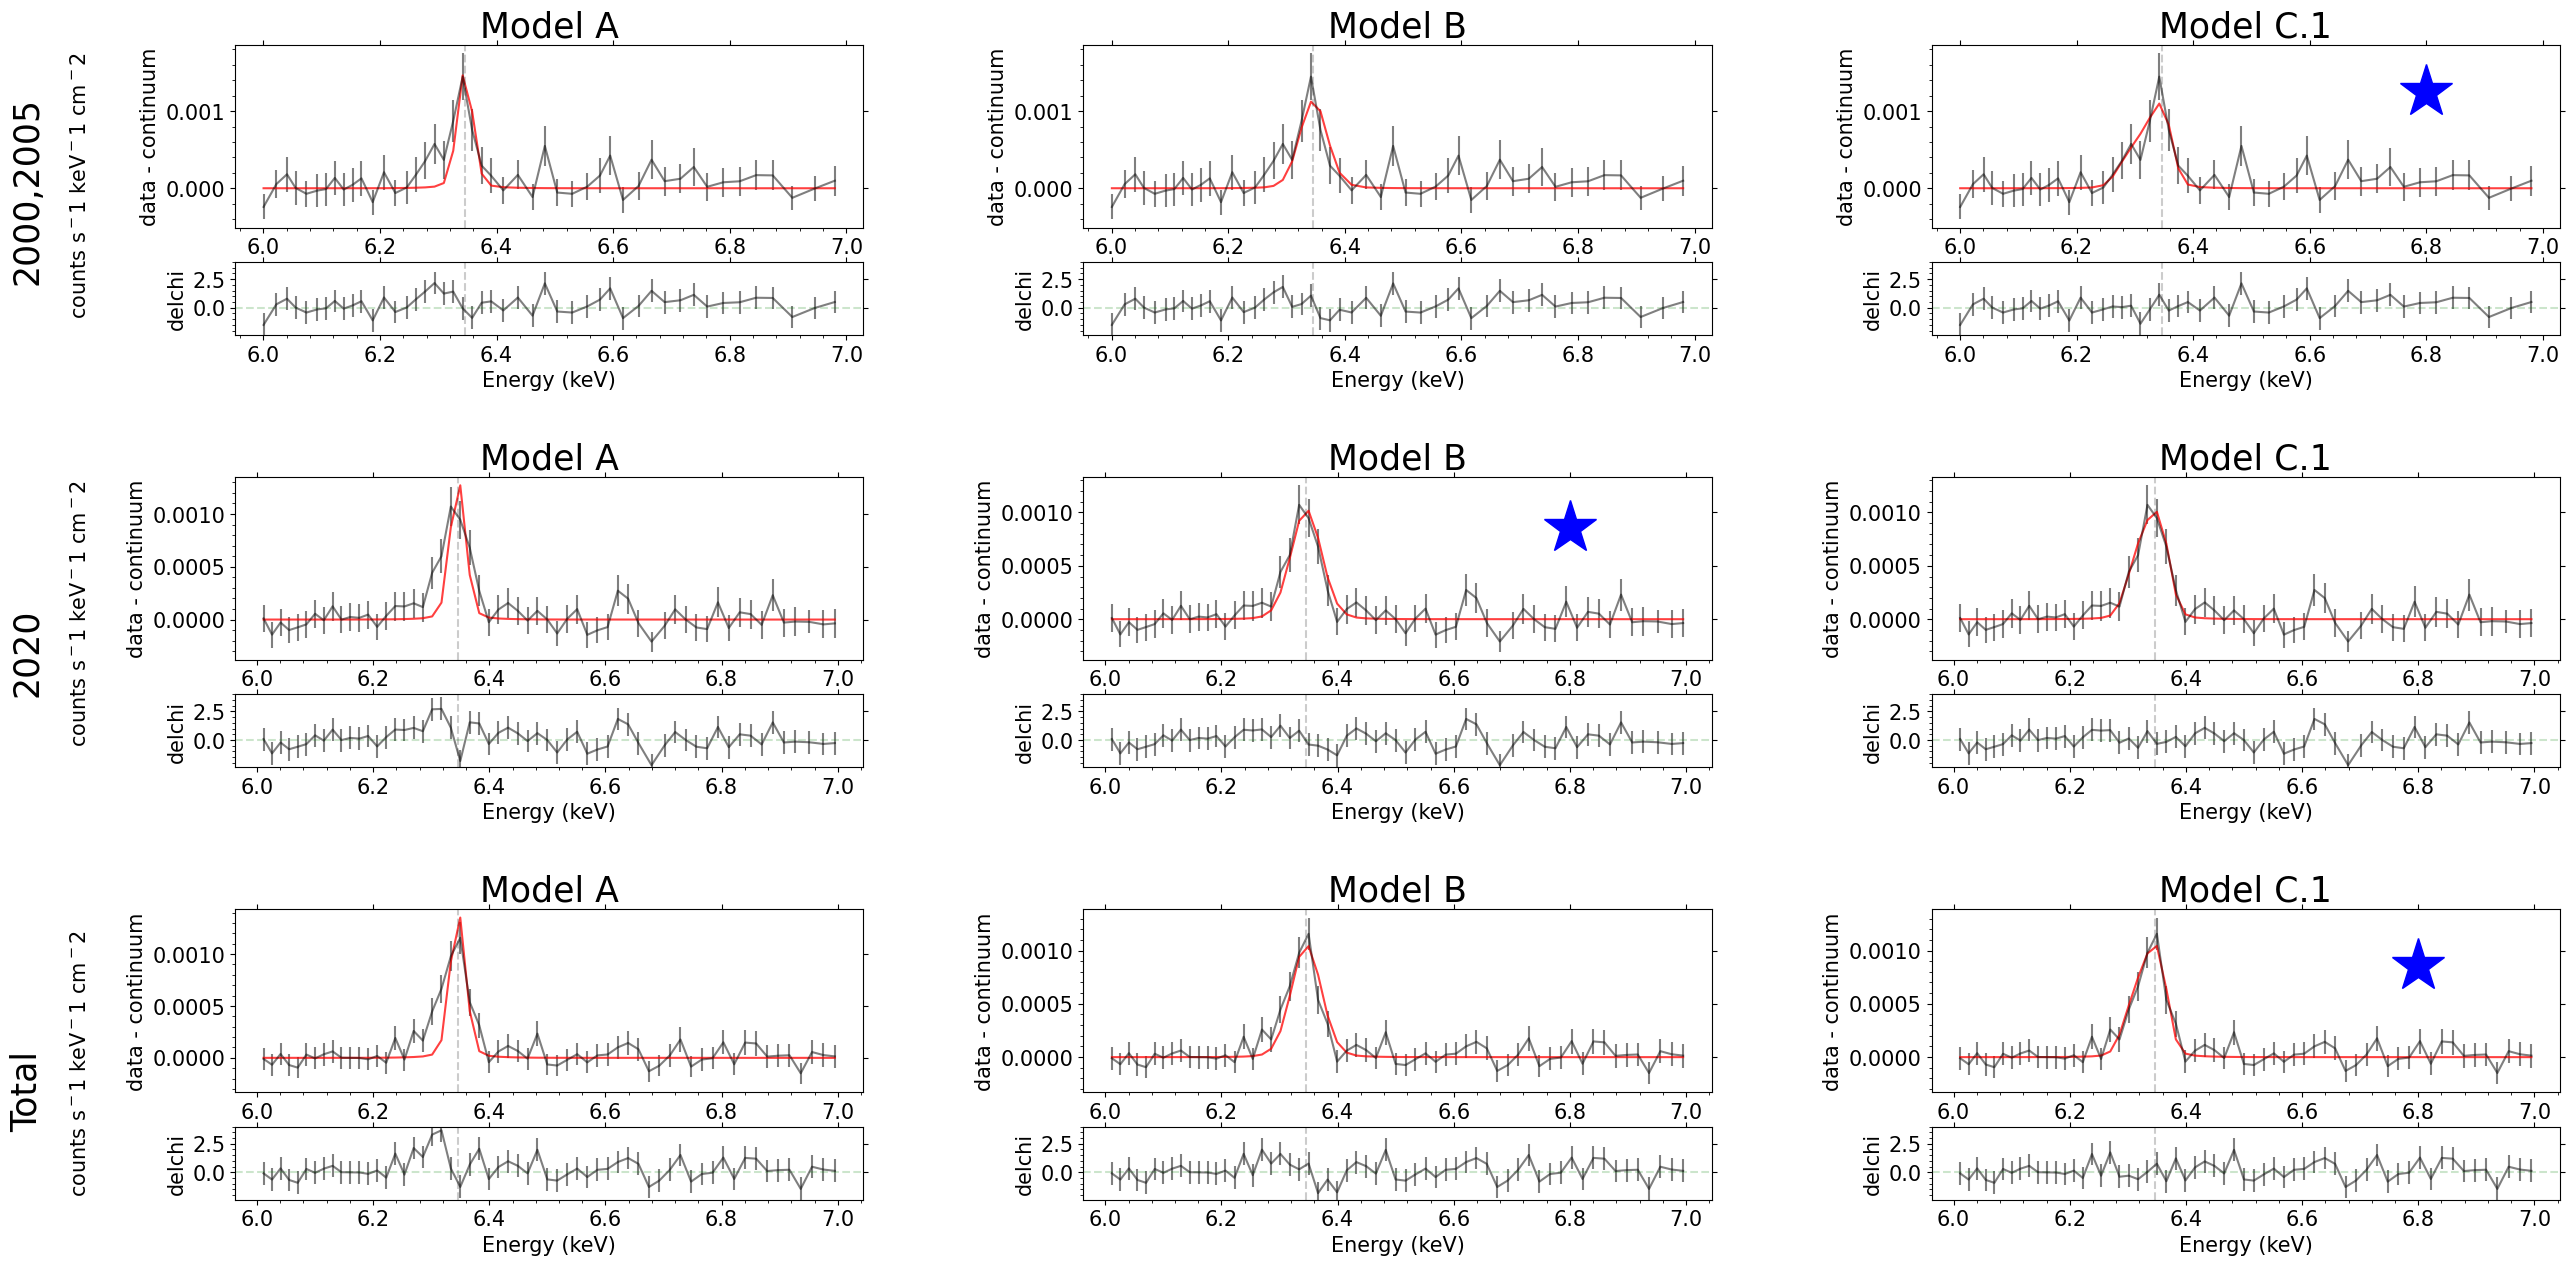

In [6]:
fig, axs = plt.subplots(8,3, sharex=False, figsize=(30,15), gridspec_kw={'height_ratios': [2.5, 1, 1, 2.5, 1, 1, 2.5, 1]})

def auxiliary_plotting(ax, spectrum=None, set_text=False, alpha_line=0.2):
    ax.minorticks_on()
    ax.xaxis.set_tick_params(bottom=True,top=True,left=True,right=True,labelsize=15)
    ax.yaxis.set_tick_params(bottom=True,top=True,left=True,right=True,labelsize=15)
    ax.xaxis.set_minor_locator(tick.AutoMinorLocator(n=5))
    ax.yaxis.set_minor_locator(tick.AutoMinorLocator(n=5))
    #ax.tick_params(axis='both', which='major', length=10)
    #ax.tick_params(which='minor', length=5)
    ax.axvline(6.346,linestyle="--",color="black",alpha=alpha_line,label='6.346 keV')
    if set_text:
        ax.text(0.02, 0.875, spectrum, transform=ax.transAxes,fontsize=20)
        ax.legend()

for ax in axs[2]:
    ax.axis("off")
for ax in axs[5]:
    ax.axis("off")
        
def plot_set_of_spectra(ax1, ax2, spectrum_name, energy, data_minus_continuum, y_err, model_names, models, model_delchi_errs, alpha1=0.5, alpha2=0.75, alpha_line=0.2, model_fontsize=25):
    for i in range(len(model_names)):
        ax1[i].errorbar(energy, data_minus_continuum, y_err, color="black", alpha=alpha1)
        ax1[i].plot(energy, models[i], color="red", alpha=alpha2)
        ax1[i].set_title(model_names[i],fontsize=model_fontsize)
        ax1[i].set_ylabel("data - continuum",fontsize=15)
        auxiliary_plotting(ax1[i], spectrum_name)
    
        ax2[i].errorbar(energy, (data_minus_continuum - models[i]) / y_err, model_delchi_errs[i], color="black", alpha=alpha1)
        ax2[i].set_xlabel("Energy (keV)",fontsize=15)
        ax2[i].set_ylabel("delchi",fontsize=15)
        ax2[i].set_ylim(-2.4,4)
        ax2[i].axhline(0,linestyle="--",color="green",alpha=alpha_line)
        auxiliary_plotting(ax2[i], set_text=False)
        
model_names = ["Model A", "Model B", "Model C.1"]
star_ms = 40

ax1, ax2 = axs[0], axs[1]
models = [old_gauss_sigma_fixed, old_gauss_sigma_vary, old_rdblur_q_fixed]
model_delchi_errs = [old_delchi_err_sigma_fixed, old_delchi_err_sigma_vary, old_delchi_err_rdblur_q_fixed]
plot_set_of_spectra(ax1, ax2, "2000,2005", old_energy, old_data_minus_continuum, old_y_err, model_names, models, model_delchi_errs)
axs[0][2].plot(6.8,0.00125, marker="*", color="blue", ms=star_ms)

ax1, ax2 = axs[3], axs[4]
models = [new_gauss_sigma_fixed, new_gauss_sigma_vary, new_rdblur_q_fixed]
model_delchi_errs = [new_delchi_err_sigma_fixed, new_delchi_err_sigma_vary, new_delchi_err_rdblur_q_fixed]
plot_set_of_spectra(ax1, ax2, "2020", new_energy, new_data_minus_continuum, new_y_err, model_names, models, model_delchi_errs)
axs[3][1].plot(6.8,0.00085, marker="*", color="blue", ms=star_ms)

ax1, ax2 = axs[6], axs[7]
models = [all_gauss_sigma_fixed, all_gauss_sigma_vary, all_rdblur_q_fixed]
model_delchi_errs = [all_delchi_err_sigma_fixed, all_delchi_err_sigma_vary, all_delchi_err_rdblur_q_fixed]
plot_set_of_spectra(ax1, ax2, "Total", all_energy, all_data_minus_continuum, all_y_err, model_names, models, model_delchi_errs)
axs[6][2].plot(6.8,0.00085, marker="*", color="blue", ms=star_ms)

fig.subplots_adjust(hspace=0.3,wspace=0.35)

fig.text(x=0.07,y=0.7,s="counts s$^-1$ keV$^-1$ cm$^-2$",rotation="vertical",fontsize=15)
fig.text(x=0.07,y=0.415,s="counts s$^-1$ keV$^-1$ cm$^-2$",rotation="vertical",fontsize=15)
fig.text(x=0.07,y=0.115,s="counts s$^-1$ keV$^-1$ cm$^-2$",rotation="vertical",fontsize=15)

fig.text(x=0.05,y=0.725,s="2000,2005",rotation="vertical",fontsize=25)
fig.text(x=0.05,y=0.45,s="2020",rotation="vertical",fontsize=25)
fig.text(x=0.05,y=0.16,s="Total",rotation="vertical",fontsize=25)

plt.setp(ax.get_xticklabels(), fontsize=12, fontweight="bold", 
         horizontalalignment="left")

fig.savefig("gaussian_spectra.eps",dpi=300,bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


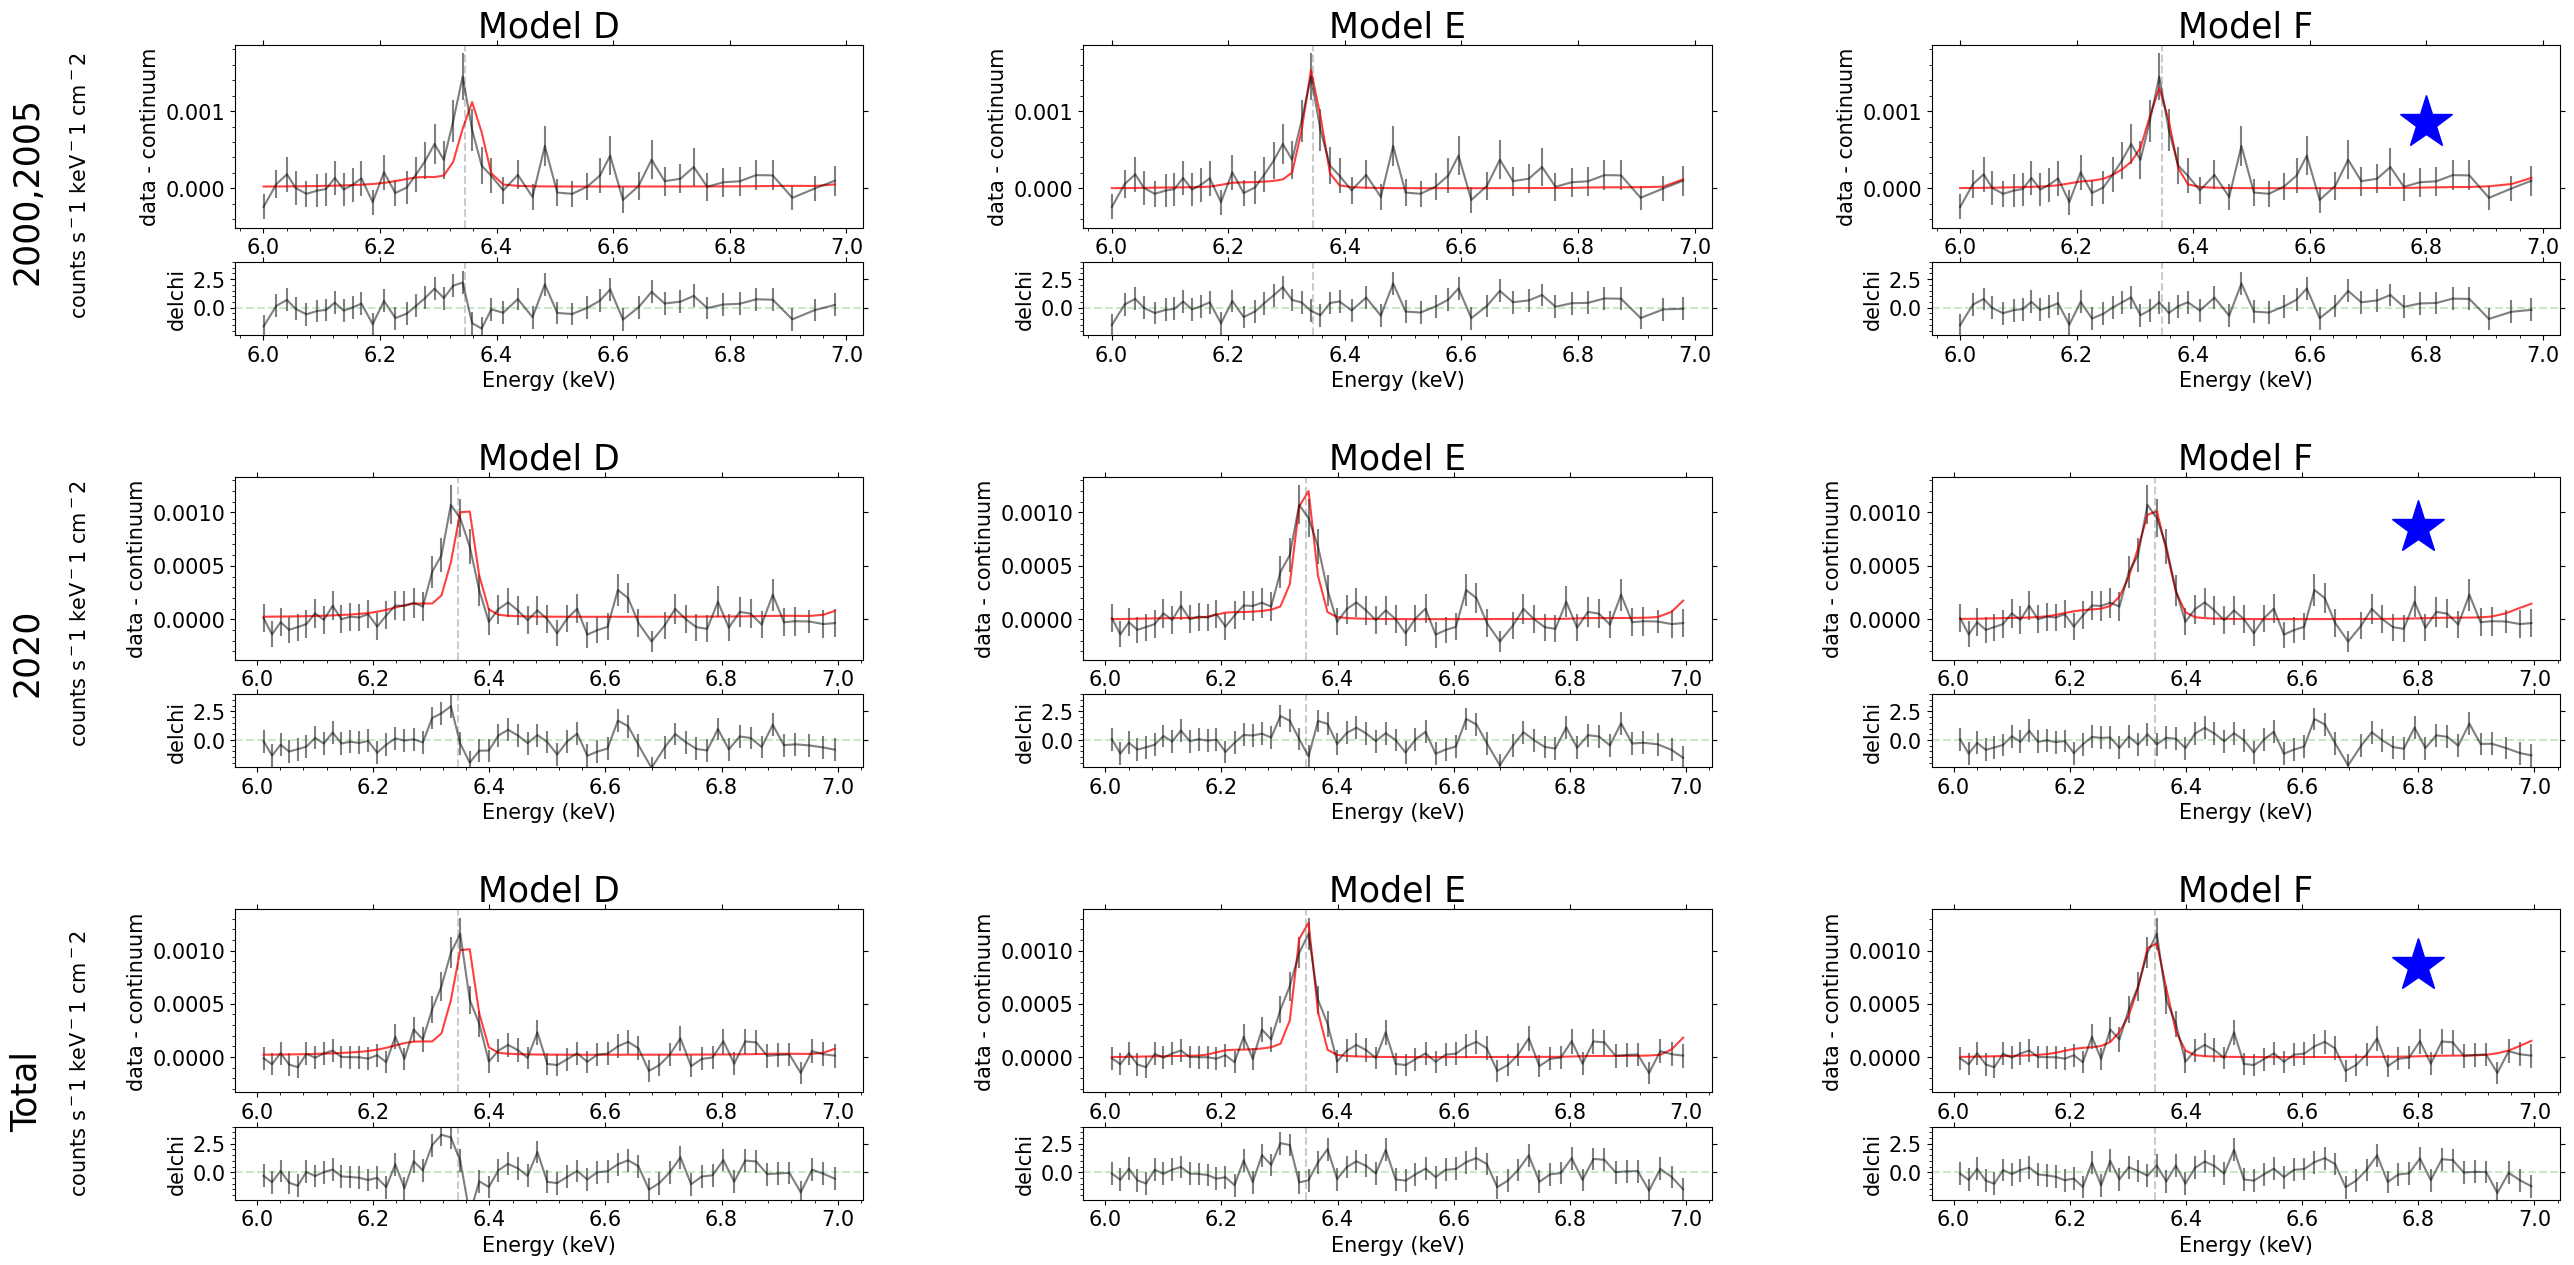

In [7]:
fig, axs = plt.subplots(8,3, sharex=False, figsize=(30,15), gridspec_kw={'height_ratios': [2.5, 1, 1, 2.5, 1, 1, 2.5, 1]})

def auxiliary_plotting(ax, spectrum=None, set_text=False, alpha_line=0.2):
    ax.minorticks_on()
    ax.xaxis.set_tick_params(bottom=True,top=True,left=True,right=True,labelsize=15)
    ax.yaxis.set_tick_params(bottom=True,top=True,left=True,right=True,labelsize=15)
    ax.xaxis.set_minor_locator(tick.AutoMinorLocator(n=5))
    ax.yaxis.set_minor_locator(tick.AutoMinorLocator(n=5))
    #ax.tick_params(axis='both', which='major', length=10)
    #ax.tick_params(which='minor', length=5)
    ax.axvline(6.346,linestyle="--",color="black",alpha=alpha_line,label='6.346 keV')
    if set_text:
        ax.text(0.02, 0.875, spectrum, transform=ax.transAxes,fontsize=20)
        ax.legend()

for ax in axs[2]:
    ax.axis("off")
for ax in axs[5]:
    ax.axis("off")
        
def plot_set_of_spectra(ax1, ax2, spectrum_name, energy, data_minus_continuum, y_err, model_names, models, model_delchi_errs, alpha1=0.5, alpha2=0.75, alpha_line=0.2, model_fontsize=25):
    for i in range(len(model_names)):
        ax1[i].errorbar(energy, data_minus_continuum, y_err, color="black", alpha=alpha1)
        ax1[i].plot(energy, models[i], color="red", alpha=alpha2)
        ax1[i].set_title(model_names[i],fontsize=model_fontsize)
        ax1[i].set_ylabel("data - continuum",fontsize=15)
        auxiliary_plotting(ax1[i], spectrum_name)
    
        ax2[i].errorbar(energy, (data_minus_continuum - models[i]) / y_err, model_delchi_errs[i], color="black", alpha=alpha1)
        ax2[i].set_xlabel("Energy (keV)",fontsize=15)
        ax2[i].set_ylabel("delchi",fontsize=15)
        ax2[i].set_ylim(-2.4,4)
        ax2[i].axhline(0,linestyle="--",color="green",alpha=alpha_line)
        auxiliary_plotting(ax2[i], set_text=False)
        
model_names = ["Model D", "Model E", "Model F"]
star_ms = 40

ax1, ax2 = axs[0], axs[1]
models = [old_xillver, old_mytorus, old_rdblur_mytorus]
model_delchi_errs = [old_delchi_err_xillver, old_delchi_err_mytorus, old_delchi_err_rdblur_mytorus]
plot_set_of_spectra(ax1, ax2, "2000,2005", old_energy, old_data_minus_continuum, old_y_err, model_names, models, model_delchi_errs)
axs[0][2].plot(6.8,0.00085, marker="*", color="blue", ms=star_ms)

ax1, ax2 = axs[3], axs[4]
models = [new_xillver, new_mytorus, new_rdblur_mytorus]
model_delchi_errs = [new_delchi_err_xillver, new_delchi_err_mytorus, new_delchi_err_rdblur_mytorus]
plot_set_of_spectra(ax1, ax2, "2020", new_energy, new_data_minus_continuum, new_y_err, model_names, models, model_delchi_errs)
axs[3][2].plot(6.8,0.00085, marker="*", color="blue", ms=star_ms)

ax1, ax2 = axs[6], axs[7]
models = [all_xillver, all_mytorus, all_rdblur_mytorus]
model_delchi_errs = [all_delchi_err_xillver, all_delchi_err_mytorus, all_delchi_err_rdblur_mytorus]
plot_set_of_spectra(ax1, ax2, "Total", all_energy, all_data_minus_continuum, all_y_err, model_names, models, model_delchi_errs)
axs[6][2].plot(6.8,0.00085, marker="*", color="blue", ms=star_ms)

fig.subplots_adjust(hspace=0.3,wspace=0.35)

fig.text(x=0.07,y=0.7,s="counts s$^-1$ keV$^-1$ cm$^-2$",rotation="vertical",fontsize=15)
fig.text(x=0.07,y=0.415,s="counts s$^-1$ keV$^-1$ cm$^-2$",rotation="vertical",fontsize=15)
fig.text(x=0.07,y=0.115,s="counts s$^-1$ keV$^-1$ cm$^-2$",rotation="vertical",fontsize=15)

fig.text(x=0.05,y=0.725,s="2000,2005",rotation="vertical",fontsize=25)
fig.text(x=0.05,y=0.45,s="2020",rotation="vertical",fontsize=25)
fig.text(x=0.05,y=0.16,s="Total",rotation="vertical",fontsize=25)

plt.setp(ax.get_xticklabels(), fontsize=12, fontweight="bold", 
         horizontalalignment="left")

fig.savefig("reflection_spectra.eps",dpi=300,bbox_inches='tight')